## End to End PNNL Surrogate Model Training and Testing

Important parameters:

channel = 1 or 2 # do others later

gridsize = 128 or 512 

w = 10 # anything from 1 to 499 (simLen) is okay. 

latentDim = 16 

## Imports

In [ ]:
# EXPORT
# --- Must haves ---
import os, sys
sys.path.append('..')

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.cuda as cuda
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from surrogates4sims.pnnlDatasets import CCSI_2D

from surrogates4sims.utils import create_opt, create_one_cycle, find_lr, printNumModelParams, \
                                    rmse, writeMessage, plotSampleWprediction, plotSampleWpredictionByChannel, \
                                    plotSample, curl, jacobian, stream2uv, create_movie, convertSimToImage, \
                                    pkl_save, pkl_load, create_1_channel_movie

from surrogates4sims.models import Generator, Encoder, AE_no_P, AE_xhat_z, AE_xhat_zV2

import numpy as np
from tqdm import tqdm
from copy import deepcopy
from glob import glob

## Settings

In [ ]:
# data 
eval_only=False
DEBUG = True
# model name, for tensorboard recording and checkpointing purposes.
versionName = "pnnl_1sim_end2end_plateau_train"

# GPU Numbers to use. Comma seprate them for multi-GPUs.
gpu_ids = "0"
versionName = versionName + '_GPUs{}'.format(gpu_ids.replace(',',''))
# path to load model weights.
pretrained_path = None

# rate at which to record metrics. (number of batches to average over when recording metrics, e.g. "every 5 batches")
tensorboard_rate = 5

# number of epochs to train. This is defined here so we can use the OneCycle LR Scheduler.
epochs = 1000

# Data Directory
channel = 1
gridsize = 128
dataDirec = '/data/ccsi/pnnl_liquid_inlet/channel_{}/gridsize_{}'.format(channel,gridsize)
preprocess = False # keep this as false until using the long runtime loader
testSplit = .2 # don't change this for now. 
AE = False
numWorkers = 2
physicsDim = 2 # inlet velocity and time sample

# checkpoint directory
cps = 'cps'
tensorboard_direc = "tb"

findLRs = False  

# LIN parameters
hiddenLayers = [128,128]
activation = nn.ELU()

# hyper-params
seed = 1234
np.random.seed(seed)
bz = 8
numSamplesToKeep = np.infty #if not debugging
latentDim = 16
window_size = 3
filters = 128
num_conv = 4 # breaks when less than 2
simLen = 4
stack = True
simVizIndex = 0 # sim in the test set to visualize
createStreamFcn = False
doJacobian = False
repeat = 0
skip_connection = False
patience = 2
if DEBUG:
    epochs = 10000
    numSamplesToKeep = 2 # 1 simulation
    
versionName = versionName + '_channel{}_gridsize{}_latentDim{}'.format(channel, gridsize, latentDim)
versionName

'pnnl_1sim_end2end_plateau_train_GPUs0_channel1_gridsize128_latentDim16'

## Select GPUs

In [ ]:
!nvidia-smi

Mon Nov  2 16:21:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:02:00.0 Off |                  N/A |
| 23%   20C    P8     8W / 250W |      1MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:03:00.0 Off |                  N/A |
| 23%   20C    P8     8W / 250W |   2377MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_ids

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
if device.type == 'cuda':
    print(cuda.is_available())
    print(cuda.device_count())
    print(cuda.current_device())
    print(cuda.get_device_name())

True
1
0
TITAN Xp


In [ ]:
a = torch.zeros(5, device=device.type)
!nvidia-smi

Mon Nov  2 16:21:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:02:00.0 Off |                  N/A |
| 23%   22C    P2    59W / 250W |    511MiB / 12196MiB |      3%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:03:00.0 Off |                  N/A |
| 23%   21C    P8     8W / 250W |   2377MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## Datasets & Loaders

In [ ]:
sims = glob(os.path.join(dataDirec,'*.pkl'))
numSims = len(sims)
idx = int(testSplit*numSims)
testInds = np.linspace(1,numSims-2,idx).astype('int')
trainInds = list(set(np.arange(0,numSims)).difference(set(testInds)))
# perm = np.random.permutation(numSims)
# testInds = perm[:idx]
# trainInds = perm[idx:]
testSimFiles = [sims[idx] for idx in testInds]
trainSimFiles = [sims[idx] for idx in trainInds]
len(testSimFiles), len(trainSimFiles)

(10, 40)

In [ ]:
## change the CCSI_2D class in 01_pnnl with this one later
from torch.utils.data import Dataset
class CCSI_2D(Dataset):
    def __init__(self, 
                 dataFiles,
                 txtFile = '/data/ccsi/pnnl_liquid_inlet/liquid_inlet_velocity.txt',
                 channel=1,
                 gridSize=128,
                 simLen = 500,
                 w = 10, # this is the length of the Y output to predict
                 AE = False, # this only return x,x, i.e. no y.
                 numToKeep=np.infty,doPreprocess=False): 
        
        self.dataFiles = dataFiles
        if numToKeep < len(self.dataFiles):
            self.dataFiles = self.dataFiles[:numToKeep]

        self.channel = channel
        self.gridSize = gridSize
        self.numToKeep = numToKeep
        self.simLen = simLen
        self.t = np.linspace(0,1,simLen).astype('float32')
        self.w = w
        self.AE = AE
        self.doPreprocess = doPreprocess
        
        # Get the inlet velocity
        with open(txtFile) as fid:
            txt = fid.read().splitlines()
        inletVelocity = np.array(list(map(float,txt[1:]))).astype('float32')
        self.inletMx = np.max(inletVelocity)
        self.inletMn = np.min(inletVelocity)
        
        data = []
        for fn in self.dataFiles:
            idx = int(fn.split('/')[-1].replace('.pkl','')) - 1
            D = pkl_load(fn)[:self.simLen]
            data.append((D,inletVelocity[idx]))
               
        self.data = data
    
    def __len__(self):
        return len(self.simLen*self.data)

    def __getitem__(self, idx):
        if len(self.data) == 1:
            q = 0
            r_idx = idx
        else:
            q,r = np.divmod(idx,self.simLen)
            #r_idx = np.random.randint(0,self.simLen-self.w)
            r_idx = 0
            
        X,p = self.data[q]
        x = X[r_idx:r_idx+1]
        #print(x.shape)
        y = X[r_idx+1:r_idx+self.w+1]
        #print(y.shape)
        if self.doPreprocess:
            x = self.preprocessFcn(x)
            y = self.preprocessFcn(y)
        
        y = np.expand_dims(y,1)
        p_x = np.hstack([p,self.t[r_idx]])
        p_y = np.vstack([p*np.ones((self.w,)),self.t[r_idx+1:r_idx+self.w+1]]).T
        X = x.astype('float32')
        Y = y.astype('float32')
        if self.AE:
            return X,X # this allows LR_finder to work
        else:
            return X, Y, p_x, p_y


In [ ]:
testDataset = CCSI_2D(testSimFiles,doPreprocess=preprocess,numToKeep=numSamplesToKeep,channel=channel,AE=AE,
                      w=window_size, simLen=simLen)
trainDataset = CCSI_2D(testSimFiles,doPreprocess=preprocess,numToKeep=numSamplesToKeep,channel=channel,AE=AE,
                      w=window_size,simLen=simLen)
len(testDataset), len(trainDataset)

(8, 8)

In [ ]:
trainDataLoader = DataLoader(dataset=trainDataset, batch_size=bz, shuffle=True, drop_last=True, 
                             num_workers=numWorkers, pin_memory=True)
testDataLoader = DataLoader(dataset=testDataset, batch_size=bz, num_workers=numWorkers, pin_memory=True)
len(trainDataLoader), len(testDataLoader)

(1, 1)

In [ ]:
X,Y,p_x, p_y = next(iter(trainDataLoader))
print(X.shape,Y.shape,p_x.shape, p_y.shape)

torch.Size([8, 1, 128, 128]) torch.Size([8, 3, 1, 128, 128]) torch.Size([8, 2]) torch.Size([8, 3, 2])


## Model

In [ ]:
X = X.to(device)
AE_model = AE_xhat_zV2(X, filters, latentDim, num_conv, repeat, 
                 skip_connection, stack, conv_k=3, last_k=3, 
                 act=nn.LeakyReLU(), return_z=True, stream=createStreamFcn, device=device)

if len(gpu_ids.split(',')) > 1:
    AE_model = nn.DataParallel(model)

[128, 8, 8]


In [ ]:
printNumModelParams(AE_model)

154 layers require gradients (unfrozen) out of 154 layers
8,761,361 parameters require gradients (unfrozen) out of 8,761,361 parameters


In [ ]:
Xhat,z = AE_model(X)
Xhat.shape, z.shape

(torch.Size([8, 1, 128, 128]), torch.Size([8, 16]))

In [ ]:
# AE_model.load_state_dict(torch.load(os.path.join('/home/widemann1/surrogates4sims/cps',
# 'plateau_train_GPUs2_latentDim16_filters128_bz16_numConv4_streamFalse_jacobianFalse_epochs1000_stackTrue_lr0.0001')))

In [ ]:
# LIN Model
class MLP(nn.Module):
    def __init__(self, X, hiddenLayerSizes = [1024], activation=nn.ELU()):
        super(MLP,self).__init__()
        
        self.activation = activation
        self.inputSize = X.shape[1:]
        self.modules = []
        self.modules.append(nn.Linear(np.prod(self.inputSize),hiddenLayerSizes[0]))
        self.modules.append(self.activation)
        for idx,sz in enumerate(hiddenLayerSizes[:-1]):
            self.modules.append(nn.Linear(hiddenLayerSizes[idx],hiddenLayerSizes[idx+1]))
            self.modules.append(self.activation)
                               
        self.modules.append(nn.Linear(hiddenLayerSizes[-1],np.prod(self.inputSize)))
        self.layers = nn.Sequential(*self.modules)
                                
        
    def forward(self,x):
        x = self.layers(x)
        return x

In [ ]:
LIN_model = MLP(z, hiddenLayerSizes=hiddenLayers, activation=activation)
LIN_model

MLP(
  (activation): ELU(alpha=1.0)
  (layers): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=128, out_features=16, bias=True)
  )
)

In [ ]:
# surrogate class
class Surrogate(nn.Module):
    
    def __init__(self, window,
                 z_size, p_size,
                LIN, encoder, decoder):
        super(Surrogate, self).__init__()
        self.window = window
        self.z_size = z_size # this does not include the size of p
        self.p_size = p_size
        self.c_size = z_size + p_size # this does include the size of p
        self.LIN = LIN
        self.encoder = encoder
        self.decoder = decoder
        
    def encode(self, U):
        
        return self.encoder(U)
        
    def decode(self, encoding):
        
        return self.decoder(encoding)
        
    def predict_next_w_encodings(self, encoding, p_y, window):
        '''
        use the LIN to predict the next w encodings for each 
        encoded U in the batch
        '''
            
        predicted_encodings = []
            
        # given a batch of encodings, advance each encoding window time steps.
        # save the result at each time step
        for i in range(window):
            encoding = self.LIN(encoding) + encoding # use LIN to predict delta in encoding
            # this was encoding[:,:,-self.p_size:] in 09_manta..., why the extra dimension?
            encoding[:,-self.p_size:] = p_y[:, i]
            predicted_encodings.append(encoding)
            
            
        return torch.stack(predicted_encodings)
    
    def forward(self, U, p_x, p_y, window = None):
        
        if window == None:
            window = self.window
        assert p_y.size(1) == window
            
        encoding = self.encode(U)
        encoding[:,-self.p_size:] = p_x # added this on 10/27/2020
        encoding_w = self.predict_next_w_encodings(encoding, p_y, window)
        # want to have this agree with U_y, which is [batch_size, window_size, channels, nx, ny]
        # right now, it's [window_size, batch_size, c_size], so transpose dimensions 0 and 1
        #print(encoding_w.shape)
        U = torch.stack([self.decode(encoding_i) for encoding_i in encoding_w])
        return U.transpose(0,1)
    

In [ ]:
surrogate = Surrogate(window_size, latentDim - physicsDim, physicsDim, LIN_model, AE_model.encoder, AE_model.generator)

In [ ]:
surrogate = surrogate.to(device)

In [ ]:
encoding = surrogate.encode(X)
encoding.shape

torch.Size([8, 16])

In [ ]:
decoding = surrogate.decode(encoding)
decoding.shape

torch.Size([8, 1, 128, 128])

In [ ]:
assert surrogate.c_size == latentDim
assert surrogate.p_size == physicsDim
assert encoding.shape[-1] == surrogate.c_size
assert decoding.shape == X.shape

In [ ]:
Xhat = surrogate.forward(X, p_x, p_y)
Xhat.shape

torch.Size([8, 3, 1, 128, 128])

In [ ]:
del surrogate, encoding, decoding, X, Y

surrogate = Surrogate(window_size, latentDim - physicsDim, physicsDim, LIN_model, 
                      AE_model.encoder, AE_model.generator).to(device)

if len(gpu_ids.split(',')) > 1:
    surrogate = nn.DataParallel(surrogate)

In [ ]:
max_lr = .0001
start_lr = 5*max_lr/10
#opt = create_opt(max_lr,model)
#lr_scheduler = create_one_cycle(opt,max_lr,epochs,trainDataLoader)
opt = torch.optim.Adam(surrogate.parameters(),lr=max_lr,betas=(.5,.999))
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,patience=patience)

In [ ]:
def L1_loss(pred, target):
    #return torch.mean(torch.abs(pred - target))
    return torch.norm(pred - target)/torch.norm(target)


def jacobian_loss(pred, target, device='cpu'):
    return L1_loss(jacobian(pred, device), jacobian(target, device))


def curl_loss(pred, target, device):
    return L1_loss(curl(pred, device), curl(target, device))


L = nn.MSELoss()


def p_loss(pred, target):
    return L(pred[:, -target.shape[1]:], target)


def loss(pred, target, device):
    
    if createStreamFcn:
        pred = stream2uv(pred, device)
        
    L1 = L1_loss(pred, target)
    Lj = 0
    if doJacobian:
        Lj = jacobian_loss(pred, target, device)
        
    return L1 + Lj

In [ ]:
def trainEpoch(myDataLoader, tensorboard_writer, model, opt, p_loss, loss,
               metric, lr_scheduler, tensorboard_rate, device,
               tensorboard_recorder_step, total_steps):
    running_loss = 0.0
    running_rmse = 0.0
    total_loss = 0.0
    running_ploss = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        # --- Main Training ---
        
        # gpu
        U_x, U_y, p_x, p_y = sampleBatch
        U_x = U_x.to(device)
        p_x = p_x.to(device)
        U_y = U_y.to(device)
        p_y = p_y.to(device)
            

        # zero the parameter gradients
        opt.zero_grad()

        U_hat = model(U_x, p_x, p_y)
        pl = 0
        ll = loss(U_hat, U_y, device)
        combined_loss = pl + ll
        combined_loss.backward()
        opt.step()
        
        # loss
        batch_loss = combined_loss.item()
        running_loss += batch_loss
        total_loss += batch_loss
        
        batch_ploss = pl
        running_ploss += batch_ploss

        # --- Metrics Recording ---

        # metrics
        r = metric(U_hat, U_y)
        running_rmse += r

        # record lr change
        total_steps += 1
        tensorboard_writer.add_scalar(tag="LR", scalar_value=opt.param_groups[0]['lr'], global_step=total_steps)
        #lr_scheduler.step()

        # tensorboard writes
        if (i % tensorboard_rate == 0):
            tensorboard_recorder_step += 1
            avg_running_loss = running_loss/tensorboard_rate
            avg_running_rmse = running_rmse/tensorboard_rate
            avg_running_ploss = running_ploss/tensorboard_rate
            tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
            tensorboard_writer.add_scalar(tag="p_loss", scalar_value=avg_running_ploss, global_step=tensorboard_recorder_step)
            tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)
            # reset running_loss for the next set of batches. (tensorboard_rate number of batches)
            running_loss = 0.0
            running_rmse = 0.0
            running_ploss = 0.0
            tensorboard_writer.flush()

    return total_loss/len(myDataLoader), tensorboard_recorder_step, total_steps

In [ ]:
def validEpoch(myDataLoader, tensorboard_writer, model, p_loss, loss, metric,
               device, tensorboard_recorder_step):
    running_loss = 0.0
    running_rmse = 0.0
    avgRelErr = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        # --- Metrics Recording ---

        # gpu
        U_x, U_y, p_x, p_y = sampleBatch
        U_x = U_x.to(device) # only squeeze away the window dimension (because batch size = 1)
        p_x = p_x.to(device) # only squeeze away the window dimension (because batch size = 1)
        U_y = U_y.to(device)
        p_y = p_y.to(device)
        
        perc = len(U_x)/len(myDataLoader.dataset)

        # forward, no gradient calculations
        with torch.no_grad():
            U_hat = model(U_x, p_x, p_y, window = window_size)

        # loss
        combined_loss = loss(U_hat, U_y, device)
        
        running_loss += perc*(combined_loss.item())

        # metrics
        r = metric(U_hat, U_y)
        running_rmse += perc*r
        
        # rel err
        d = torch.norm(U_hat-U_y)
        avgRelErr += perc*(d/torch.norm(U_y))

    avg_running_loss = running_loss
    avg_running_rmse = running_rmse
    tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
    tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)
    tensorboard_writer.flush()
    
    return running_loss, avgRelErr

In [ ]:
try:
    os.mkdir(cps)
except:
    print("checkpoints directory already exists :)")
    
# create a summary writer.
train_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'train'))
test_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'valid'))
tensorboard_recorder_step = 0
total_steps = 0

checkpoints directory already exists :)


In [ ]:
writeMessage('---------- Started Training ----------', versionName)
bestLoss = np.infty

if not eval_only:
    for epoch in tqdm(range(1, epochs+1)):  # loop over the dataset multiple times

        writeMessage("--- Epoch {0}/{1} ---".format(epoch, epochs), versionName)

        surrogate.train()
        trainLoss, tensorboard_recorder_step, total_steps = trainEpoch(trainDataLoader, 
                                                                       train_writer, surrogate,
                                                                       opt, p_loss, loss,
                                                                       rmse, lr_scheduler, 
                                                                       tensorboard_rate, device,
                                                                       tensorboard_recorder_step, total_steps)

        writeMessage("trainLoss: {:.4e}".format(trainLoss),versionName)
        writeMessage("LR: {:.4e}".format(opt.param_groups[0]['lr']),versionName)
#         if trainLoss < bestLoss:
#             bestLoss = trainLoss
#             writeMessage("Better trainLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
#             torch.save(surrogate.state_dict(), os.path.join(cps,versionName))

        surrogate.eval()
        valLoss, avgRelErr = validEpoch(testDataLoader, test_writer, surrogate, p_loss, loss, rmse, device, tensorboard_recorder_step)
        writeMessage("valLoss: {:.4e}".format(valLoss),versionName)
        writeMessage("val Avg Rel Err: {:.4e}".format(avgRelErr),versionName)

        # checkpoint progress
        if valLoss < bestLoss:
            bestLoss = valLoss
            writeMessage("Better valLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
            torch.save(surrogate.state_dict(), os.path.join(cps,versionName))

        #lr_scheduler.step(trainLoss)
        lr_scheduler.step(valLoss)
        
        if opt.param_groups[0]['lr'] < 5e-8:
            break
    writeMessage('---------- Finished Training ----------', versionName)

  0%|          | 0/10000 [00:00<?, ?it/s]

---------- Started Training ----------
--- Epoch 1/10000 ---
trainLoss: 2.9162e+00
LR: 1.0000e-04
valLoss: 1.9064e+00
val Avg Rel Err: 1.9064e+00
Better valLoss: 1.9064e+00, Saving models...


  0%|          | 1/10000 [00:00<2:02:52,  1.36it/s]

--- Epoch 2/10000 ---
trainLoss: 3.7980e+00
LR: 1.0000e-04


  0%|          | 2/10000 [00:01<1:54:17,  1.46it/s]

valLoss: 1.9826e+00
val Avg Rel Err: 1.9826e+00
--- Epoch 3/10000 ---
trainLoss: 2.5489e+00
LR: 1.0000e-04


  0%|          | 3/10000 [00:01<1:46:37,  1.56it/s]

valLoss: 1.9154e+00
val Avg Rel Err: 1.9154e+00
--- Epoch 4/10000 ---
trainLoss: 2.5104e+00
LR: 1.0000e-04
valLoss: 1.8459e+00
val Avg Rel Err: 1.8459e+00
Better valLoss: 1.8459e+00, Saving models...


  0%|          | 4/10000 [00:02<1:50:43,  1.50it/s]

--- Epoch 5/10000 ---
trainLoss: 2.0533e+00
LR: 1.0000e-04


  0%|          | 5/10000 [00:03<1:55:00,  1.45it/s]

valLoss: 1.7750e+00
val Avg Rel Err: 1.7750e+00
Better valLoss: 1.7750e+00, Saving models...
--- Epoch 6/10000 ---
trainLoss: 2.1412e+00
LR: 1.0000e-04
valLoss: 1.7416e+00
val Avg Rel Err: 1.7416e+00
Better valLoss: 1.7416e+00, Saving models...


  0%|          | 6/10000 [00:04<1:57:24,  1.42it/s]

--- Epoch 7/10000 ---
trainLoss: 2.1750e+00
LR: 1.0000e-04
valLoss: 1.7001e+00
val Avg Rel Err: 1.7001e+00
Better valLoss: 1.7001e+00, Saving models...


  0%|          | 7/10000 [00:04<1:56:55,  1.42it/s]

--- Epoch 8/10000 ---
trainLoss: 1.8813e+00
LR: 1.0000e-04


  0%|          | 8/10000 [00:05<1:48:55,  1.53it/s]

valLoss: 1.7523e+00
val Avg Rel Err: 1.7523e+00
--- Epoch 9/10000 ---
trainLoss: 2.1508e+00
LR: 1.0000e-04


  0%|          | 9/10000 [00:06<1:53:30,  1.47it/s]

valLoss: 1.6227e+00
val Avg Rel Err: 1.6227e+00
Better valLoss: 1.6227e+00, Saving models...
--- Epoch 10/10000 ---
trainLoss: 1.6947e+00
LR: 1.0000e-04
valLoss: 1.5954e+00


  0%|          | 10/10000 [00:06<1:54:44,  1.45it/s]

val Avg Rel Err: 1.5954e+00
Better valLoss: 1.5954e+00, Saving models...
--- Epoch 11/10000 ---
trainLoss: 1.7127e+00
LR: 1.0000e-04
valLoss: 1.5019e+00
val Avg Rel Err: 1.5019e+00
Better valLoss: 1.5019e+00, Saving models...


  0%|          | 11/10000 [00:07<2:10:14,  1.28it/s]

--- Epoch 12/10000 ---
trainLoss: 1.5937e+00
LR: 1.0000e-04
valLoss: 1.4864e+00
val Avg Rel Err: 1.4864e+00
Better valLoss: 1.4864e+00, Saving models...


  0%|          | 12/10000 [00:08<2:05:33,  1.33it/s]

--- Epoch 13/10000 ---
trainLoss: 1.6428e+00
LR: 1.0000e-04
valLoss: 1.4143e+00


  0%|          | 13/10000 [00:09<2:02:12,  1.36it/s]

val Avg Rel Err: 1.4143e+00
Better valLoss: 1.4143e+00, Saving models...
--- Epoch 14/10000 ---
trainLoss: 1.3388e+00
LR: 1.0000e-04


  0%|          | 14/10000 [00:09<1:53:07,  1.47it/s]

valLoss: 1.4253e+00
val Avg Rel Err: 1.4253e+00
--- Epoch 15/10000 ---
trainLoss: 1.5372e+00
LR: 1.0000e-04


  0%|          | 15/10000 [00:10<1:46:21,  1.56it/s]

valLoss: 1.4802e+00
val Avg Rel Err: 1.4802e+00
--- Epoch 16/10000 ---
trainLoss: 1.7745e+00
LR: 1.0000e-04


  0%|          | 16/10000 [00:10<1:49:17,  1.52it/s]

valLoss: 1.3756e+00
val Avg Rel Err: 1.3756e+00
Better valLoss: 1.3756e+00, Saving models...
--- Epoch 17/10000 ---
trainLoss: 1.3666e+00
LR: 1.0000e-04


  0%|          | 17/10000 [00:11<1:42:23,  1.62it/s]

valLoss: 1.4604e+00
val Avg Rel Err: 1.4604e+00
--- Epoch 18/10000 ---
trainLoss: 1.3736e+00
LR: 1.0000e-04


  0%|          | 18/10000 [00:11<1:38:03,  1.70it/s]

valLoss: 1.4070e+00
val Avg Rel Err: 1.4070e+00
--- Epoch 19/10000 ---
trainLoss: 1.3627e+00
LR: 1.0000e-04


  0%|          | 19/10000 [00:12<1:34:25,  1.76it/s]

valLoss: 1.5687e+00
val Avg Rel Err: 1.5687e+00
--- Epoch 20/10000 ---
trainLoss: 1.7859e+00
LR: 1.0000e-05
valLoss: 1.5042e+00


  0%|          | 20/10000 [00:13<1:33:44,  1.77it/s]

val Avg Rel Err: 1.5042e+00
--- Epoch 21/10000 ---
trainLoss: 1.6414e+00
LR: 1.0000e-05


  0%|          | 21/10000 [00:13<1:31:48,  1.81it/s]

valLoss: 1.4042e+00
val Avg Rel Err: 1.4042e+00
--- Epoch 22/10000 ---
trainLoss: 1.4090e+00
LR: 1.0000e-05


  0%|          | 22/10000 [00:14<1:40:04,  1.66it/s]

valLoss: 1.3324e+00
val Avg Rel Err: 1.3324e+00
Better valLoss: 1.3324e+00, Saving models...
--- Epoch 23/10000 ---
trainLoss: 1.1997e+00
LR: 1.0000e-05
valLoss: 1.3034e+00
val Avg Rel Err: 1.3034e+00
Better valLoss: 1.3034e+00, Saving models...


  0%|          | 23/10000 [00:14<1:45:39,  1.57it/s]

--- Epoch 24/10000 ---
trainLoss: 1.0531e+00
LR: 1.0000e-05
valLoss: 1.3004e+00
val Avg Rel Err: 1.3004e+00
Better valLoss: 1.3004e+00, Saving models...


  0%|          | 24/10000 [00:15<1:50:19,  1.51it/s]

--- Epoch 25/10000 ---
trainLoss: 9.7663e-01
LR: 1.0000e-05
valLoss: 1.3019e+00
val Avg Rel Err: 1.3019e+00


  0%|          | 25/10000 [00:16<1:44:51,  1.59it/s]

--- Epoch 26/10000 ---
trainLoss: 9.3701e-01
LR: 1.0000e-05


  0%|          | 26/10000 [00:16<1:40:05,  1.66it/s]

valLoss: 1.3012e+00
val Avg Rel Err: 1.3012e+00
--- Epoch 27/10000 ---
trainLoss: 9.1286e-01
LR: 1.0000e-05


  0%|          | 27/10000 [00:17<1:46:29,  1.56it/s]

valLoss: 1.3003e+00
val Avg Rel Err: 1.3003e+00
Better valLoss: 1.3003e+00, Saving models...
--- Epoch 28/10000 ---
trainLoss: 8.9850e-01
LR: 1.0000e-06
valLoss: 1.2985e+00
val Avg Rel Err: 1.2985e+00
Better valLoss: 1.2985e+00, Saving models...


  0%|          | 28/10000 [00:18<1:50:37,  1.50it/s]

--- Epoch 29/10000 ---
trainLoss: 8.9687e-01
LR: 1.0000e-06
valLoss: 1.2975e+00
val Avg Rel Err: 1.2975e+00
Better valLoss: 1.2975e+00, Saving models...


  0%|          | 29/10000 [00:18<1:52:28,  1.48it/s]

--- Epoch 30/10000 ---
trainLoss: 8.9492e-01
LR: 1.0000e-06
valLoss: 1.2969e+00
val Avg Rel Err: 1.2969e+00
Better valLoss: 1.2969e+00, Saving models...


  0%|          | 30/10000 [00:19<1:52:35,  1.48it/s]

--- Epoch 31/10000 ---
trainLoss: 8.9288e-01
LR: 1.0000e-06
valLoss: 1.2957e+00
val Avg Rel Err: 1.2957e+00
Better valLoss: 1.2957e+00, Saving models...


  0%|          | 31/10000 [00:20<1:56:30,  1.43it/s]

--- Epoch 32/10000 ---
trainLoss: 8.9085e-01
LR: 1.0000e-06


  0%|          | 32/10000 [00:21<1:59:31,  1.39it/s]

valLoss: 1.2942e+00
val Avg Rel Err: 1.2942e+00
Better valLoss: 1.2942e+00, Saving models...
--- Epoch 33/10000 ---
trainLoss: 8.8889e-01
LR: 1.0000e-06
valLoss: 1.2924e+00
val Avg Rel Err: 1.2924e+00


  0%|          | 33/10000 [00:21<1:58:16,  1.40it/s]

Better valLoss: 1.2924e+00, Saving models...
--- Epoch 34/10000 ---
trainLoss: 8.8702e-01
LR: 1.0000e-06
valLoss: 1.2907e+00
val Avg Rel Err: 1.2907e+00
Better valLoss: 1.2907e+00, Saving models...


  0%|          | 34/10000 [00:22<1:58:03,  1.41it/s]

--- Epoch 35/10000 ---
trainLoss: 8.8522e-01
LR: 1.0000e-06
valLoss: 1.2894e+00
val Avg Rel Err: 1.2894e+00
Better valLoss: 1.2894e+00, Saving models...


  0%|          | 35/10000 [00:23<1:55:35,  1.44it/s]

--- Epoch 36/10000 ---
trainLoss: 8.8349e-01
LR: 1.0000e-06
valLoss: 1.2883e+00
val Avg Rel Err: 1.2883e+00
Better valLoss: 1.2883e+00, Saving models...


  0%|          | 36/10000 [00:23<1:55:32,  1.44it/s]

--- Epoch 37/10000 ---
trainLoss: 8.8182e-01
LR: 1.0000e-06


  0%|          | 37/10000 [00:24<1:57:40,  1.41it/s]

valLoss: 1.2865e+00
val Avg Rel Err: 1.2865e+00
Better valLoss: 1.2865e+00, Saving models...
--- Epoch 38/10000 ---
trainLoss: 8.8020e-01
LR: 1.0000e-06


  0%|          | 38/10000 [00:25<1:58:37,  1.40it/s]

valLoss: 1.2838e+00
val Avg Rel Err: 1.2838e+00
Better valLoss: 1.2838e+00, Saving models...
--- Epoch 39/10000 ---
trainLoss: 8.7863e-01
LR: 1.0000e-06
valLoss: 1.2808e+00
val Avg Rel Err: 1.2808e+00
Better valLoss: 1.2808e+00, Saving models...


  0%|          | 39/10000 [00:26<1:58:50,  1.40it/s]

--- Epoch 40/10000 ---
trainLoss: 8.7709e-01
LR: 1.0000e-06
valLoss: 1.2783e+00
val Avg Rel Err: 1.2783e+00
Better valLoss: 1.2783e+00, Saving models...


  0%|          | 40/10000 [00:26<1:55:12,  1.44it/s]

--- Epoch 41/10000 ---
trainLoss: 8.7558e-01
LR: 1.0000e-06
valLoss: 1.2762e+00
val Avg Rel Err: 1.2762e+00
Better valLoss: 1.2762e+00, Saving models...


  0%|          | 41/10000 [00:27<1:52:49,  1.47it/s]

--- Epoch 42/10000 ---
trainLoss: 8.7408e-01
LR: 1.0000e-06


  0%|          | 42/10000 [00:28<1:55:41,  1.43it/s]

valLoss: 1.2744e+00
val Avg Rel Err: 1.2744e+00
Better valLoss: 1.2744e+00, Saving models...
--- Epoch 43/10000 ---
trainLoss: 8.7260e-01
LR: 1.0000e-06
valLoss: 1.2723e+00
val Avg Rel Err: 1.2723e+00


  0%|          | 43/10000 [00:28<1:54:15,  1.45it/s]

Better valLoss: 1.2723e+00, Saving models...
--- Epoch 44/10000 ---
trainLoss: 8.7114e-01
LR: 1.0000e-06
valLoss: 1.2706e+00
val Avg Rel Err: 1.2706e+00
Better valLoss: 1.2706e+00, Saving models...


  0%|          | 44/10000 [00:29<1:54:34,  1.45it/s]

--- Epoch 45/10000 ---
trainLoss: 8.6969e-01
LR: 1.0000e-06


  0%|          | 45/10000 [00:30<1:56:59,  1.42it/s]

valLoss: 1.2694e+00
val Avg Rel Err: 1.2694e+00
Better valLoss: 1.2694e+00, Saving models...
--- Epoch 46/10000 ---
trainLoss: 8.6825e-01
LR: 1.0000e-06


  0%|          | 46/10000 [00:30<1:59:05,  1.39it/s]

valLoss: 1.2681e+00
val Avg Rel Err: 1.2681e+00
Better valLoss: 1.2681e+00, Saving models...
--- Epoch 47/10000 ---
trainLoss: 8.6683e-01
LR: 1.0000e-06
valLoss: 1.2677e+00
val Avg Rel Err: 1.2677e+00
Better valLoss: 1.2677e+00, Saving models...


  0%|          | 47/10000 [00:31<1:59:35,  1.39it/s]

--- Epoch 48/10000 ---
trainLoss: 8.6541e-01
LR: 1.0000e-06


  0%|          | 48/10000 [00:32<1:56:19,  1.43it/s]

valLoss: 1.2668e+00
val Avg Rel Err: 1.2668e+00
Better valLoss: 1.2668e+00, Saving models...
--- Epoch 49/10000 ---
trainLoss: 8.6400e-01
LR: 1.0000e-06


  0%|          | 49/10000 [00:33<1:56:04,  1.43it/s]

valLoss: 1.2658e+00
val Avg Rel Err: 1.2658e+00
Better valLoss: 1.2658e+00, Saving models...
--- Epoch 50/10000 ---
trainLoss: 8.6259e-01
LR: 1.0000e-06


  0%|          | 50/10000 [00:33<1:57:21,  1.41it/s]

valLoss: 1.2654e+00
val Avg Rel Err: 1.2654e+00
Better valLoss: 1.2654e+00, Saving models...
--- Epoch 51/10000 ---
trainLoss: 8.6120e-01
LR: 1.0000e-06
valLoss: 1.2641e+00
val Avg Rel Err: 1.2641e+00
Better valLoss: 1.2641e+00, Saving models...


  1%|          | 51/10000 [00:34<1:54:25,  1.45it/s]

--- Epoch 52/10000 ---
trainLoss: 8.5981e-01
LR: 1.0000e-06
valLoss: 1.2617e+00


  1%|          | 52/10000 [00:35<1:56:00,  1.43it/s]

val Avg Rel Err: 1.2617e+00
Better valLoss: 1.2617e+00, Saving models...
--- Epoch 53/10000 ---
trainLoss: 8.5843e-01
LR: 1.0000e-06


  1%|          | 53/10000 [00:35<1:56:41,  1.42it/s]

valLoss: 1.2583e+00
val Avg Rel Err: 1.2583e+00
Better valLoss: 1.2583e+00, Saving models...
--- Epoch 54/10000 ---
trainLoss: 8.5705e-01
LR: 1.0000e-06


  1%|          | 54/10000 [00:36<2:00:34,  1.37it/s]

valLoss: 1.2542e+00
val Avg Rel Err: 1.2542e+00
Better valLoss: 1.2542e+00, Saving models...
--- Epoch 55/10000 ---
trainLoss: 8.5568e-01
LR: 1.0000e-06


  1%|          | 55/10000 [00:37<2:01:17,  1.37it/s]

valLoss: 1.2505e+00
val Avg Rel Err: 1.2505e+00
Better valLoss: 1.2505e+00, Saving models...
--- Epoch 56/10000 ---
trainLoss: 8.5431e-01
LR: 1.0000e-06
valLoss: 1.2463e+00
val Avg Rel Err: 1.2463e+00
Better valLoss: 1.2463e+00, Saving models...


  1%|          | 56/10000 [00:38<2:00:22,  1.38it/s]

--- Epoch 57/10000 ---
trainLoss: 8.5295e-01
LR: 1.0000e-06


  1%|          | 57/10000 [00:38<2:00:04,  1.38it/s]

valLoss: 1.2429e+00
val Avg Rel Err: 1.2429e+00
Better valLoss: 1.2429e+00, Saving models...
--- Epoch 58/10000 ---
trainLoss: 8.5159e-01
LR: 1.0000e-06


  1%|          | 58/10000 [00:39<1:59:36,  1.39it/s]

valLoss: 1.2373e+00
val Avg Rel Err: 1.2373e+00
Better valLoss: 1.2373e+00, Saving models...
--- Epoch 59/10000 ---
trainLoss: 8.5024e-01
LR: 1.0000e-06


  1%|          | 59/10000 [00:40<2:00:45,  1.37it/s]

valLoss: 1.2274e+00
val Avg Rel Err: 1.2274e+00
Better valLoss: 1.2274e+00, Saving models...
--- Epoch 60/10000 ---
trainLoss: 8.4890e-01
LR: 1.0000e-06


  1%|          | 60/10000 [00:41<2:02:38,  1.35it/s]

valLoss: 1.2161e+00
val Avg Rel Err: 1.2161e+00
Better valLoss: 1.2161e+00, Saving models...
--- Epoch 61/10000 ---
trainLoss: 8.4755e-01
LR: 1.0000e-06


  1%|          | 61/10000 [00:41<2:01:39,  1.36it/s]

valLoss: 1.2055e+00
val Avg Rel Err: 1.2055e+00
Better valLoss: 1.2055e+00, Saving models...
--- Epoch 62/10000 ---
trainLoss: 8.4622e-01
LR: 1.0000e-06
valLoss: 1.1948e+00
val Avg Rel Err: 1.1948e+00
Better valLoss: 1.1948e+00, Saving models...


  1%|          | 62/10000 [00:42<1:59:03,  1.39it/s]

--- Epoch 63/10000 ---
trainLoss: 8.4489e-01
LR: 1.0000e-06


  1%|          | 63/10000 [00:43<1:58:03,  1.40it/s]

valLoss: 1.1840e+00
val Avg Rel Err: 1.1840e+00
Better valLoss: 1.1840e+00, Saving models...
--- Epoch 64/10000 ---
trainLoss: 8.4356e-01
LR: 1.0000e-06
valLoss: 1.1726e+00
val Avg Rel Err: 1.1726e+00
Better valLoss: 1.1726e+00, Saving models...


  1%|          | 64/10000 [00:43<1:59:51,  1.38it/s]

--- Epoch 65/10000 ---
trainLoss: 8.4224e-01
LR: 1.0000e-06


  1%|          | 65/10000 [00:44<2:02:07,  1.36it/s]

valLoss: 1.1614e+00
val Avg Rel Err: 1.1614e+00
Better valLoss: 1.1614e+00, Saving models...
--- Epoch 66/10000 ---
trainLoss: 8.4092e-01
LR: 1.0000e-06


  1%|          | 66/10000 [00:45<2:00:52,  1.37it/s]

valLoss: 1.1521e+00
val Avg Rel Err: 1.1521e+00
Better valLoss: 1.1521e+00, Saving models...
--- Epoch 67/10000 ---
trainLoss: 8.3960e-01
LR: 1.0000e-06


  1%|          | 67/10000 [00:46<2:00:05,  1.38it/s]

valLoss: 1.1447e+00
val Avg Rel Err: 1.1447e+00
Better valLoss: 1.1447e+00, Saving models...
--- Epoch 68/10000 ---
trainLoss: 8.3829e-01
LR: 1.0000e-06


  1%|          | 68/10000 [00:46<1:58:57,  1.39it/s]

valLoss: 1.1372e+00
val Avg Rel Err: 1.1372e+00
Better valLoss: 1.1372e+00, Saving models...
--- Epoch 69/10000 ---
trainLoss: 8.3698e-01
LR: 1.0000e-06
valLoss: 1.1278e+00
val Avg Rel Err: 1.1278e+00
Better valLoss: 1.1278e+00, Saving models...


  1%|          | 69/10000 [00:47<1:55:38,  1.43it/s]

--- Epoch 70/10000 ---
trainLoss: 8.3567e-01
LR: 1.0000e-06


  1%|          | 70/10000 [00:48<1:56:25,  1.42it/s]

valLoss: 1.1194e+00
val Avg Rel Err: 1.1194e+00
Better valLoss: 1.1194e+00, Saving models...
--- Epoch 71/10000 ---
trainLoss: 8.3437e-01
LR: 1.0000e-06
valLoss: 1.1127e+00
val Avg Rel Err: 1.1127e+00
Better valLoss: 1.1127e+00, Saving models...


  1%|          | 71/10000 [00:48<1:54:42,  1.44it/s]

--- Epoch 72/10000 ---
trainLoss: 8.3307e-01
LR: 1.0000e-06


  1%|          | 72/10000 [00:49<1:54:13,  1.45it/s]

valLoss: 1.1059e+00
val Avg Rel Err: 1.1059e+00
Better valLoss: 1.1059e+00, Saving models...
--- Epoch 73/10000 ---
trainLoss: 8.3177e-01
LR: 1.0000e-06


  1%|          | 73/10000 [00:50<1:53:33,  1.46it/s]

valLoss: 1.0975e+00
val Avg Rel Err: 1.0975e+00
Better valLoss: 1.0975e+00, Saving models...
--- Epoch 74/10000 ---
trainLoss: 8.3047e-01
LR: 1.0000e-06
valLoss: 1.0876e+00
val Avg Rel Err: 1.0876e+00
Better valLoss: 1.0876e+00, Saving models...


  1%|          | 74/10000 [00:50<1:50:47,  1.49it/s]

--- Epoch 75/10000 ---
trainLoss: 8.2918e-01
LR: 1.0000e-06
valLoss: 1.0777e+00
val Avg Rel Err: 1.0777e+00
Better valLoss: 1.0777e+00, Saving models...


  1%|          | 75/10000 [00:51<1:50:26,  1.50it/s]

--- Epoch 76/10000 ---
trainLoss: 8.2789e-01
LR: 1.0000e-06
valLoss: 1.0670e+00
val Avg Rel Err: 1.0670e+00
Better valLoss: 1.0670e+00, Saving models...


  1%|          | 76/10000 [00:52<1:48:58,  1.52it/s]

--- Epoch 77/10000 ---
trainLoss: 8.2661e-01
LR: 1.0000e-06
valLoss: 1.0553e+00
val Avg Rel Err: 1.0553e+00
Better valLoss: 1.0553e+00, Saving models...


  1%|          | 77/10000 [00:52<1:48:07,  1.53it/s]

--- Epoch 78/10000 ---
trainLoss: 8.2533e-01
LR: 1.0000e-06
valLoss: 1.0416e+00
val Avg Rel Err: 1.0416e+00
Better valLoss: 1.0416e+00, Saving models...


  1%|          | 78/10000 [00:53<1:47:24,  1.54it/s]

--- Epoch 79/10000 ---
trainLoss: 8.2405e-01
LR: 1.0000e-06
valLoss: 1.0263e+00


  1%|          | 79/10000 [00:54<1:48:03,  1.53it/s]

val Avg Rel Err: 1.0263e+00
Better valLoss: 1.0263e+00, Saving models...
--- Epoch 80/10000 ---
trainLoss: 8.2277e-01
LR: 1.0000e-06
valLoss: 1.0112e+00
val Avg Rel Err: 1.0112e+00
Better valLoss: 1.0112e+00, Saving models...


  1%|          | 80/10000 [00:54<1:48:36,  1.52it/s]

--- Epoch 81/10000 ---
trainLoss: 8.2150e-01
LR: 1.0000e-06
valLoss: 9.9713e-01
val Avg Rel Err: 9.9713e-01
Better valLoss: 9.9713e-01, Saving models...


  1%|          | 81/10000 [00:55<1:50:58,  1.49it/s]

--- Epoch 82/10000 ---
trainLoss: 8.2023e-01
LR: 1.0000e-06
valLoss: 9.8388e-01
val Avg Rel Err: 9.8388e-01
Better valLoss: 9.8388e-01, Saving models...


  1%|          | 82/10000 [00:56<1:52:07,  1.47it/s]

--- Epoch 83/10000 ---
trainLoss: 8.1896e-01
LR: 1.0000e-06


  1%|          | 83/10000 [00:56<1:53:45,  1.45it/s]

valLoss: 9.7231e-01
val Avg Rel Err: 9.7231e-01
Better valLoss: 9.7231e-01, Saving models...
--- Epoch 84/10000 ---
trainLoss: 8.1770e-01
LR: 1.0000e-06
valLoss: 9.6218e-01


  1%|          | 84/10000 [00:57<1:54:02,  1.45it/s]

val Avg Rel Err: 9.6218e-01
Better valLoss: 9.6218e-01, Saving models...
--- Epoch 85/10000 ---
trainLoss: 8.1643e-01
LR: 1.0000e-06
valLoss: 9.5260e-01
val Avg Rel Err: 9.5260e-01
Better valLoss: 9.5260e-01, Saving models...


  1%|          | 85/10000 [00:58<1:53:23,  1.46it/s]

--- Epoch 86/10000 ---
trainLoss: 8.1518e-01
LR: 1.0000e-06


  1%|          | 86/10000 [00:58<1:53:57,  1.45it/s]

valLoss: 9.4360e-01
val Avg Rel Err: 9.4360e-01
Better valLoss: 9.4360e-01, Saving models...
--- Epoch 87/10000 ---
trainLoss: 8.1392e-01
LR: 1.0000e-06
valLoss: 9.3426e-01
val Avg Rel Err: 9.3426e-01
Better valLoss: 9.3426e-01, Saving models...


  1%|          | 87/10000 [00:59<1:54:59,  1.44it/s]

--- Epoch 88/10000 ---
trainLoss: 8.1267e-01
LR: 1.0000e-06


  1%|          | 88/10000 [01:00<1:57:06,  1.41it/s]

valLoss: 9.2544e-01
val Avg Rel Err: 9.2544e-01
Better valLoss: 9.2544e-01, Saving models...
--- Epoch 89/10000 ---
trainLoss: 8.1142e-01
LR: 1.0000e-06


  1%|          | 89/10000 [01:01<1:59:24,  1.38it/s]

valLoss: 9.1726e-01
val Avg Rel Err: 9.1726e-01
Better valLoss: 9.1726e-01, Saving models...
--- Epoch 90/10000 ---
trainLoss: 8.1017e-01
LR: 1.0000e-06
valLoss: 9.0944e-01
val Avg Rel Err: 9.0944e-01
Better valLoss: 9.0944e-01, Saving models...


  1%|          | 90/10000 [01:01<1:57:16,  1.41it/s]

--- Epoch 91/10000 ---
trainLoss: 8.0893e-01
LR: 1.0000e-06


  1%|          | 91/10000 [01:02<1:57:12,  1.41it/s]

valLoss: 9.0203e-01
val Avg Rel Err: 9.0203e-01
Better valLoss: 9.0203e-01, Saving models...
--- Epoch 92/10000 ---
trainLoss: 8.0768e-01
LR: 1.0000e-06


  1%|          | 92/10000 [01:03<1:57:51,  1.40it/s]

valLoss: 8.9527e-01
val Avg Rel Err: 8.9527e-01
Better valLoss: 8.9527e-01, Saving models...
--- Epoch 93/10000 ---
trainLoss: 8.0645e-01
LR: 1.0000e-06


  1%|          | 93/10000 [01:03<1:56:00,  1.42it/s]

valLoss: 8.8959e-01
val Avg Rel Err: 8.8959e-01
Better valLoss: 8.8959e-01, Saving models...
--- Epoch 94/10000 ---
trainLoss: 8.0521e-01
LR: 1.0000e-06


  1%|          | 94/10000 [01:04<1:59:04,  1.39it/s]

valLoss: 8.8421e-01
val Avg Rel Err: 8.8421e-01
Better valLoss: 8.8421e-01, Saving models...
--- Epoch 95/10000 ---
trainLoss: 8.0398e-01
LR: 1.0000e-06


  1%|          | 95/10000 [01:05<2:00:15,  1.37it/s]

valLoss: 8.7956e-01
val Avg Rel Err: 8.7956e-01
Better valLoss: 8.7956e-01, Saving models...
--- Epoch 96/10000 ---
trainLoss: 8.0275e-01
LR: 1.0000e-06
valLoss: 8.7529e-01
val Avg Rel Err: 8.7529e-01
Better valLoss: 8.7529e-01, Saving models...


  1%|          | 96/10000 [01:06<1:57:20,  1.41it/s]

--- Epoch 97/10000 ---
trainLoss: 8.0152e-01
LR: 1.0000e-06


  1%|          | 97/10000 [01:06<1:55:32,  1.43it/s]

valLoss: 8.7136e-01
val Avg Rel Err: 8.7136e-01
Better valLoss: 8.7136e-01, Saving models...
--- Epoch 98/10000 ---
trainLoss: 8.0029e-01
LR: 1.0000e-06


  1%|          | 98/10000 [01:07<1:55:29,  1.43it/s]

valLoss: 8.6788e-01
val Avg Rel Err: 8.6788e-01
Better valLoss: 8.6788e-01, Saving models...
--- Epoch 99/10000 ---
trainLoss: 7.9907e-01
LR: 1.0000e-06
valLoss: 8.6471e-01


  1%|          | 99/10000 [01:08<1:55:33,  1.43it/s]

val Avg Rel Err: 8.6471e-01
Better valLoss: 8.6471e-01, Saving models...
--- Epoch 100/10000 ---
trainLoss: 7.9785e-01
LR: 1.0000e-06
valLoss: 8.6181e-01
val Avg Rel Err: 8.6181e-01
Better valLoss: 8.6181e-01, Saving models...


  1%|          | 100/10000 [01:08<1:54:45,  1.44it/s]

--- Epoch 101/10000 ---
trainLoss: 7.9663e-01
LR: 1.0000e-06


  1%|          | 101/10000 [01:09<1:54:16,  1.44it/s]

valLoss: 8.5930e-01
val Avg Rel Err: 8.5930e-01
Better valLoss: 8.5930e-01, Saving models...
--- Epoch 102/10000 ---
trainLoss: 7.9541e-01
LR: 1.0000e-06


  1%|          | 102/10000 [01:10<1:55:40,  1.43it/s]

valLoss: 8.5705e-01
val Avg Rel Err: 8.5705e-01
Better valLoss: 8.5705e-01, Saving models...
--- Epoch 103/10000 ---
trainLoss: 7.9420e-01
LR: 1.0000e-06
valLoss: 8.5504e-01
val Avg Rel Err: 8.5504e-01
Better valLoss: 8.5504e-01, Saving models...


  1%|          | 103/10000 [01:10<1:55:18,  1.43it/s]

--- Epoch 104/10000 ---
trainLoss: 7.9298e-01
LR: 1.0000e-06
valLoss: 8.5323e-01
val Avg Rel Err: 8.5323e-01
Better valLoss: 8.5323e-01, Saving models...


  1%|          | 104/10000 [01:11<1:55:16,  1.43it/s]

--- Epoch 105/10000 ---
trainLoss: 7.9177e-01
LR: 1.0000e-06


  1%|          | 105/10000 [01:12<1:55:28,  1.43it/s]

valLoss: 8.5158e-01
val Avg Rel Err: 8.5158e-01
Better valLoss: 8.5158e-01, Saving models...
--- Epoch 106/10000 ---
trainLoss: 7.9057e-01
LR: 1.0000e-06


  1%|          | 106/10000 [01:13<1:57:05,  1.41it/s]

valLoss: 8.5005e-01
val Avg Rel Err: 8.5005e-01
Better valLoss: 8.5005e-01, Saving models...
--- Epoch 107/10000 ---
trainLoss: 7.8936e-01
LR: 1.0000e-06


  1%|          | 107/10000 [01:13<1:57:02,  1.41it/s]

valLoss: 8.4864e-01
val Avg Rel Err: 8.4864e-01
Better valLoss: 8.4864e-01, Saving models...
--- Epoch 108/10000 ---
trainLoss: 7.8816e-01
LR: 1.0000e-06


  1%|          | 108/10000 [01:14<1:56:37,  1.41it/s]

valLoss: 8.4735e-01
val Avg Rel Err: 8.4735e-01
Better valLoss: 8.4735e-01, Saving models...
--- Epoch 109/10000 ---
trainLoss: 7.8696e-01
LR: 1.0000e-06
valLoss: 8.4619e-01
val Avg Rel Err: 8.4619e-01
Better valLoss: 8.4619e-01, Saving models...


  1%|          | 109/10000 [01:15<1:53:28,  1.45it/s]

--- Epoch 110/10000 ---
trainLoss: 7.8576e-01
LR: 1.0000e-06
valLoss: 8.4510e-01
val Avg Rel Err: 8.4510e-01
Better valLoss: 8.4510e-01, Saving models...


  1%|          | 110/10000 [01:15<1:50:48,  1.49it/s]

--- Epoch 111/10000 ---
trainLoss: 7.8456e-01
LR: 1.0000e-06


  1%|          | 111/10000 [01:16<1:52:06,  1.47it/s]

valLoss: 8.4409e-01
val Avg Rel Err: 8.4409e-01
Better valLoss: 8.4409e-01, Saving models...
--- Epoch 112/10000 ---
trainLoss: 7.8336e-01
LR: 1.0000e-06
valLoss: 8.4311e-01


  1%|          | 112/10000 [01:17<1:52:53,  1.46it/s]

val Avg Rel Err: 8.4311e-01
Better valLoss: 8.4311e-01, Saving models...
--- Epoch 113/10000 ---
trainLoss: 7.8217e-01
LR: 1.0000e-06


  1%|          | 113/10000 [01:17<1:53:35,  1.45it/s]

valLoss: 8.4216e-01
val Avg Rel Err: 8.4216e-01
Better valLoss: 8.4216e-01, Saving models...
--- Epoch 114/10000 ---
trainLoss: 7.8098e-01
LR: 1.0000e-06


  1%|          | 114/10000 [01:18<1:54:46,  1.44it/s]

valLoss: 8.4123e-01
val Avg Rel Err: 8.4123e-01
Better valLoss: 8.4123e-01, Saving models...
--- Epoch 115/10000 ---
trainLoss: 7.7979e-01
LR: 1.0000e-06


  1%|          | 115/10000 [01:19<1:54:11,  1.44it/s]

valLoss: 8.4033e-01
val Avg Rel Err: 8.4033e-01
Better valLoss: 8.4033e-01, Saving models...
--- Epoch 116/10000 ---
trainLoss: 7.7860e-01
LR: 1.0000e-06


  1%|          | 116/10000 [01:19<1:53:55,  1.45it/s]

valLoss: 8.3944e-01
val Avg Rel Err: 8.3944e-01
Better valLoss: 8.3944e-01, Saving models...
--- Epoch 117/10000 ---
trainLoss: 7.7742e-01
LR: 1.0000e-06
valLoss: 8.3856e-01
val Avg Rel Err: 8.3856e-01
Better valLoss: 8.3856e-01, Saving models...


  1%|          | 117/10000 [01:20<1:54:07,  1.44it/s]

--- Epoch 118/10000 ---
trainLoss: 7.7624e-01
LR: 1.0000e-06
valLoss: 8.3769e-01
val Avg Rel Err: 8.3769e-01
Better valLoss: 8.3769e-01, Saving models...


  1%|          | 118/10000 [01:21<1:52:50,  1.46it/s]

--- Epoch 119/10000 ---
trainLoss: 7.7506e-01
LR: 1.0000e-06


  1%|          | 119/10000 [01:22<1:55:22,  1.43it/s]

valLoss: 8.3684e-01
val Avg Rel Err: 8.3684e-01
Better valLoss: 8.3684e-01, Saving models...
--- Epoch 120/10000 ---
trainLoss: 7.7388e-01
LR: 1.0000e-06
valLoss: 8.3600e-01
val Avg Rel Err: 8.3600e-01


  1%|          | 120/10000 [01:22<1:54:37,  1.44it/s]

Better valLoss: 8.3600e-01, Saving models...
--- Epoch 121/10000 ---
trainLoss: 7.7270e-01
LR: 1.0000e-06
valLoss: 8.3516e-01
val Avg Rel Err: 8.3516e-01


  1%|          | 121/10000 [01:23<1:53:59,  1.44it/s]

Better valLoss: 8.3516e-01, Saving models...
--- Epoch 122/10000 ---
trainLoss: 7.7153e-01
LR: 1.0000e-06
valLoss: 8.3432e-01
val Avg Rel Err: 8.3432e-01
Better valLoss: 8.3432e-01, Saving models...


  1%|          | 122/10000 [01:24<1:53:13,  1.45it/s]

--- Epoch 123/10000 ---
trainLoss: 7.7036e-01
LR: 1.0000e-06


  1%|          | 123/10000 [01:24<1:54:40,  1.44it/s]

valLoss: 8.3348e-01
val Avg Rel Err: 8.3348e-01
Better valLoss: 8.3348e-01, Saving models...
--- Epoch 124/10000 ---
trainLoss: 7.6919e-01
LR: 1.0000e-06


  1%|          | 124/10000 [01:25<1:57:15,  1.40it/s]

valLoss: 8.3264e-01
val Avg Rel Err: 8.3264e-01
Better valLoss: 8.3264e-01, Saving models...
--- Epoch 125/10000 ---
trainLoss: 7.6802e-01
LR: 1.0000e-06


  1%|▏         | 125/10000 [01:26<1:57:51,  1.40it/s]

valLoss: 8.3181e-01
val Avg Rel Err: 8.3181e-01
Better valLoss: 8.3181e-01, Saving models...
--- Epoch 126/10000 ---
trainLoss: 7.6686e-01
LR: 1.0000e-06


  1%|▏         | 126/10000 [01:26<1:56:22,  1.41it/s]

valLoss: 8.3097e-01
val Avg Rel Err: 8.3097e-01
Better valLoss: 8.3097e-01, Saving models...
--- Epoch 127/10000 ---
trainLoss: 7.6569e-01
LR: 1.0000e-06
valLoss: 8.3013e-01
val Avg Rel Err: 8.3013e-01
Better valLoss: 8.3013e-01, Saving models...


  1%|▏         | 127/10000 [01:27<1:55:29,  1.42it/s]

--- Epoch 128/10000 ---
trainLoss: 7.6453e-01
LR: 1.0000e-06


  1%|▏         | 128/10000 [01:28<1:55:26,  1.43it/s]

valLoss: 8.2929e-01
val Avg Rel Err: 8.2929e-01
Better valLoss: 8.2929e-01, Saving models...
--- Epoch 129/10000 ---
trainLoss: 7.6337e-01
LR: 1.0000e-06


  1%|▏         | 129/10000 [01:29<1:55:29,  1.42it/s]

valLoss: 8.2845e-01
val Avg Rel Err: 8.2845e-01
Better valLoss: 8.2845e-01, Saving models...
--- Epoch 130/10000 ---
trainLoss: 7.6221e-01
LR: 1.0000e-06


  1%|▏         | 130/10000 [01:29<1:55:18,  1.43it/s]

valLoss: 8.2761e-01
val Avg Rel Err: 8.2761e-01
Better valLoss: 8.2761e-01, Saving models...
--- Epoch 131/10000 ---
trainLoss: 7.6105e-01
LR: 1.0000e-06


  1%|▏         | 131/10000 [01:30<1:53:29,  1.45it/s]

valLoss: 8.2677e-01
val Avg Rel Err: 8.2677e-01
Better valLoss: 8.2677e-01, Saving models...
--- Epoch 132/10000 ---
trainLoss: 7.5990e-01
LR: 1.0000e-06
valLoss: 8.2592e-01
val Avg Rel Err: 8.2592e-01
Better valLoss: 8.2592e-01, Saving models...


  1%|▏         | 132/10000 [01:31<1:54:08,  1.44it/s]

--- Epoch 133/10000 ---
trainLoss: 7.5875e-01
LR: 1.0000e-06
valLoss: 8.2508e-01
val Avg Rel Err: 8.2508e-01
Better valLoss: 8.2508e-01, Saving models...


  1%|▏         | 133/10000 [01:31<1:51:44,  1.47it/s]

--- Epoch 134/10000 ---
trainLoss: 7.5760e-01
LR: 1.0000e-06
valLoss: 8.2424e-01
val Avg Rel Err: 8.2424e-01
Better valLoss: 8.2424e-01, Saving models...


  1%|▏         | 134/10000 [01:32<1:50:18,  1.49it/s]

--- Epoch 135/10000 ---
trainLoss: 7.5645e-01
LR: 1.0000e-06


  1%|▏         | 135/10000 [01:33<1:50:25,  1.49it/s]

valLoss: 8.2339e-01
val Avg Rel Err: 8.2339e-01
Better valLoss: 8.2339e-01, Saving models...
--- Epoch 136/10000 ---
trainLoss: 7.5530e-01
LR: 1.0000e-06


  1%|▏         | 136/10000 [01:33<1:53:07,  1.45it/s]

valLoss: 8.2255e-01
val Avg Rel Err: 8.2255e-01
Better valLoss: 8.2255e-01, Saving models...
--- Epoch 137/10000 ---
trainLoss: 7.5416e-01
LR: 1.0000e-06


  1%|▏         | 137/10000 [01:34<1:52:49,  1.46it/s]

valLoss: 8.2170e-01
val Avg Rel Err: 8.2170e-01
Better valLoss: 8.2170e-01, Saving models...
--- Epoch 138/10000 ---
trainLoss: 7.5302e-01
LR: 1.0000e-06


  1%|▏         | 138/10000 [01:35<1:53:15,  1.45it/s]

valLoss: 8.2086e-01
val Avg Rel Err: 8.2086e-01
Better valLoss: 8.2086e-01, Saving models...
--- Epoch 139/10000 ---
trainLoss: 7.5188e-01
LR: 1.0000e-06
valLoss: 8.2002e-01
val Avg Rel Err: 8.2002e-01
Better valLoss: 8.2002e-01, Saving models...


  1%|▏         | 139/10000 [01:35<1:52:32,  1.46it/s]

--- Epoch 140/10000 ---
trainLoss: 7.5074e-01
LR: 1.0000e-06


  1%|▏         | 140/10000 [01:36<1:53:20,  1.45it/s]

valLoss: 8.1918e-01
val Avg Rel Err: 8.1918e-01
Better valLoss: 8.1918e-01, Saving models...
--- Epoch 141/10000 ---
trainLoss: 7.4961e-01
LR: 1.0000e-06


  1%|▏         | 141/10000 [01:37<1:55:28,  1.42it/s]

valLoss: 8.1834e-01
val Avg Rel Err: 8.1834e-01
Better valLoss: 8.1834e-01, Saving models...
--- Epoch 142/10000 ---
trainLoss: 7.4847e-01
LR: 1.0000e-06


  1%|▏         | 142/10000 [01:38<1:55:57,  1.42it/s]

valLoss: 8.1749e-01
val Avg Rel Err: 8.1749e-01
Better valLoss: 8.1749e-01, Saving models...
--- Epoch 143/10000 ---
trainLoss: 7.4735e-01
LR: 1.0000e-06


  1%|▏         | 143/10000 [01:38<1:57:10,  1.40it/s]

valLoss: 8.1665e-01
val Avg Rel Err: 8.1665e-01
Better valLoss: 8.1665e-01, Saving models...
--- Epoch 144/10000 ---
trainLoss: 7.4622e-01
LR: 1.0000e-06
valLoss: 8.1581e-01
val Avg Rel Err: 8.1581e-01
Better valLoss: 8.1581e-01, Saving models...


  1%|▏         | 144/10000 [01:39<1:57:29,  1.40it/s]

--- Epoch 145/10000 ---
trainLoss: 7.4510e-01
LR: 1.0000e-06
valLoss: 8.1497e-01
val Avg Rel Err: 8.1497e-01
Better valLoss: 8.1497e-01, Saving models...


  1%|▏         | 145/10000 [01:40<1:56:08,  1.41it/s]

--- Epoch 146/10000 ---
trainLoss: 7.4397e-01
LR: 1.0000e-06


  1%|▏         | 146/10000 [01:40<1:57:22,  1.40it/s]

valLoss: 8.1413e-01
val Avg Rel Err: 8.1413e-01
Better valLoss: 8.1413e-01, Saving models...
--- Epoch 147/10000 ---
trainLoss: 7.4285e-01
LR: 1.0000e-06
valLoss: 8.1329e-01
val Avg Rel Err: 8.1329e-01
Better valLoss: 8.1329e-01, Saving models...


  1%|▏         | 147/10000 [01:41<1:54:15,  1.44it/s]

--- Epoch 148/10000 ---
trainLoss: 7.4174e-01
LR: 1.0000e-06
valLoss: 8.1245e-01
val Avg Rel Err: 8.1245e-01
Better valLoss: 8.1245e-01, Saving models...


  1%|▏         | 148/10000 [01:42<1:52:22,  1.46it/s]

--- Epoch 149/10000 ---
trainLoss: 7.4062e-01
LR: 1.0000e-06


  1%|▏         | 149/10000 [01:42<1:54:30,  1.43it/s]

valLoss: 8.1161e-01
val Avg Rel Err: 8.1161e-01
Better valLoss: 8.1161e-01, Saving models...
--- Epoch 150/10000 ---
trainLoss: 7.3951e-01
LR: 1.0000e-06


  2%|▏         | 150/10000 [01:43<1:56:04,  1.41it/s]

valLoss: 8.1077e-01
val Avg Rel Err: 8.1077e-01
Better valLoss: 8.1077e-01, Saving models...
--- Epoch 151/10000 ---
trainLoss: 7.3840e-01
LR: 1.0000e-06


  2%|▏         | 151/10000 [01:44<1:56:54,  1.40it/s]

valLoss: 8.0993e-01
val Avg Rel Err: 8.0993e-01
Better valLoss: 8.0993e-01, Saving models...
--- Epoch 152/10000 ---
trainLoss: 7.3729e-01
LR: 1.0000e-06
valLoss: 8.0910e-01


  2%|▏         | 152/10000 [01:45<1:53:25,  1.45it/s]

val Avg Rel Err: 8.0910e-01
Better valLoss: 8.0910e-01, Saving models...
--- Epoch 153/10000 ---
trainLoss: 7.3618e-01
LR: 1.0000e-06
valLoss: 8.0827e-01
val Avg Rel Err: 8.0827e-01
Better valLoss: 8.0827e-01, Saving models...


  2%|▏         | 153/10000 [01:45<1:51:44,  1.47it/s]

--- Epoch 154/10000 ---
trainLoss: 7.3508e-01
LR: 1.0000e-06
valLoss: 8.0743e-01
val Avg Rel Err: 8.0743e-01
Better valLoss: 8.0743e-01, Saving models...


  2%|▏         | 154/10000 [01:46<1:52:09,  1.46it/s]

--- Epoch 155/10000 ---
trainLoss: 7.3398e-01
LR: 1.0000e-06
valLoss: 8.0660e-01


  2%|▏         | 155/10000 [01:47<1:52:59,  1.45it/s]

val Avg Rel Err: 8.0660e-01
Better valLoss: 8.0660e-01, Saving models...
--- Epoch 156/10000 ---
trainLoss: 7.3288e-01
LR: 1.0000e-06
valLoss: 8.0577e-01
val Avg Rel Err: 8.0577e-01
Better valLoss: 8.0577e-01, Saving models...


  2%|▏         | 156/10000 [01:47<1:50:47,  1.48it/s]

--- Epoch 157/10000 ---
trainLoss: 7.3178e-01
LR: 1.0000e-06
valLoss: 8.0494e-01
val Avg Rel Err: 8.0494e-01
Better valLoss: 8.0494e-01, Saving models...


  2%|▏         | 157/10000 [01:48<1:49:34,  1.50it/s]

--- Epoch 158/10000 ---
trainLoss: 7.3069e-01
LR: 1.0000e-06
valLoss: 8.0411e-01
val Avg Rel Err: 8.0411e-01
Better valLoss: 8.0411e-01, Saving models...


  2%|▏         | 158/10000 [01:49<1:53:14,  1.45it/s]

--- Epoch 159/10000 ---
trainLoss: 7.2960e-01
LR: 1.0000e-06
valLoss: 8.0329e-01
val Avg Rel Err: 8.0329e-01
Better valLoss: 8.0329e-01, Saving models...


  2%|▏         | 159/10000 [01:49<1:52:24,  1.46it/s]

--- Epoch 160/10000 ---
trainLoss: 7.2851e-01
LR: 1.0000e-06


  2%|▏         | 160/10000 [01:50<1:53:49,  1.44it/s]

valLoss: 8.0246e-01
val Avg Rel Err: 8.0246e-01
Better valLoss: 8.0246e-01, Saving models...
--- Epoch 161/10000 ---
trainLoss: 7.2742e-01
LR: 1.0000e-06
valLoss: 8.0164e-01
val Avg Rel Err: 8.0164e-01
Better valLoss: 8.0164e-01, Saving models...


  2%|▏         | 161/10000 [01:51<1:52:55,  1.45it/s]

--- Epoch 162/10000 ---
trainLoss: 7.2633e-01
LR: 1.0000e-06


  2%|▏         | 162/10000 [01:51<1:55:09,  1.42it/s]

valLoss: 8.0081e-01
val Avg Rel Err: 8.0081e-01
Better valLoss: 8.0081e-01, Saving models...
--- Epoch 163/10000 ---
trainLoss: 7.2525e-01
LR: 1.0000e-06
valLoss: 8.0000e-01
val Avg Rel Err: 8.0000e-01
Better valLoss: 8.0000e-01, Saving models...


  2%|▏         | 163/10000 [01:52<1:54:13,  1.44it/s]

--- Epoch 164/10000 ---
trainLoss: 7.2416e-01
LR: 1.0000e-06
valLoss: 7.9918e-01
val Avg Rel Err: 7.9918e-01
Better valLoss: 7.9918e-01, Saving models...


  2%|▏         | 164/10000 [01:53<1:52:58,  1.45it/s]

--- Epoch 165/10000 ---
trainLoss: 7.2308e-01
LR: 1.0000e-06
valLoss: 7.9837e-01
val Avg Rel Err: 7.9837e-01
Better valLoss: 7.9837e-01, Saving models...


  2%|▏         | 165/10000 [01:53<1:51:04,  1.48it/s]

--- Epoch 166/10000 ---
trainLoss: 7.2201e-01
LR: 1.0000e-06
valLoss: 7.9754e-01


  2%|▏         | 166/10000 [01:54<1:50:40,  1.48it/s]

val Avg Rel Err: 7.9754e-01
Better valLoss: 7.9754e-01, Saving models...
--- Epoch 167/10000 ---
trainLoss: 7.2093e-01
LR: 1.0000e-06
valLoss: 7.9673e-01
val Avg Rel Err: 7.9673e-01
Better valLoss: 7.9673e-01, Saving models...


  2%|▏         | 167/10000 [01:55<1:50:44,  1.48it/s]

--- Epoch 168/10000 ---
trainLoss: 7.1985e-01
LR: 1.0000e-06


  2%|▏         | 168/10000 [01:55<1:51:35,  1.47it/s]

valLoss: 7.9592e-01
val Avg Rel Err: 7.9592e-01
Better valLoss: 7.9592e-01, Saving models...
--- Epoch 169/10000 ---
trainLoss: 7.1878e-01
LR: 1.0000e-06


  2%|▏         | 169/10000 [01:56<1:52:18,  1.46it/s]

valLoss: 7.9510e-01
val Avg Rel Err: 7.9510e-01
Better valLoss: 7.9510e-01, Saving models...
--- Epoch 170/10000 ---
trainLoss: 7.1771e-01
LR: 1.0000e-06
valLoss: 7.9430e-01
val Avg Rel Err: 7.9430e-01
Better valLoss: 7.9430e-01, Saving models...


  2%|▏         | 170/10000 [01:57<1:52:55,  1.45it/s]

--- Epoch 171/10000 ---
trainLoss: 7.1664e-01
LR: 1.0000e-06


  2%|▏         | 171/10000 [01:58<1:52:26,  1.46it/s]

valLoss: 7.9348e-01
val Avg Rel Err: 7.9348e-01
Better valLoss: 7.9348e-01, Saving models...
--- Epoch 172/10000 ---
trainLoss: 7.1558e-01
LR: 1.0000e-06


  2%|▏         | 172/10000 [01:58<1:53:37,  1.44it/s]

valLoss: 7.9268e-01
val Avg Rel Err: 7.9268e-01
Better valLoss: 7.9268e-01, Saving models...
--- Epoch 173/10000 ---
trainLoss: 7.1451e-01
LR: 1.0000e-06


  2%|▏         | 173/10000 [01:59<1:51:42,  1.47it/s]

valLoss: 7.9187e-01
val Avg Rel Err: 7.9187e-01
Better valLoss: 7.9187e-01, Saving models...
--- Epoch 174/10000 ---
trainLoss: 7.1345e-01
LR: 1.0000e-06


  2%|▏         | 174/10000 [02:00<1:53:23,  1.44it/s]

valLoss: 7.9107e-01
val Avg Rel Err: 7.9107e-01
Better valLoss: 7.9107e-01, Saving models...
--- Epoch 175/10000 ---
trainLoss: 7.1239e-01
LR: 1.0000e-06


  2%|▏         | 175/10000 [02:00<1:55:09,  1.42it/s]

valLoss: 7.9027e-01
val Avg Rel Err: 7.9027e-01
Better valLoss: 7.9027e-01, Saving models...
--- Epoch 176/10000 ---
trainLoss: 7.1133e-01
LR: 1.0000e-06


  2%|▏         | 176/10000 [02:01<1:55:35,  1.42it/s]

valLoss: 7.8947e-01
val Avg Rel Err: 7.8947e-01
Better valLoss: 7.8947e-01, Saving models...
--- Epoch 177/10000 ---
trainLoss: 7.1028e-01
LR: 1.0000e-06


  2%|▏         | 177/10000 [02:02<1:57:49,  1.39it/s]

valLoss: 7.8866e-01
val Avg Rel Err: 7.8866e-01
Better valLoss: 7.8866e-01, Saving models...
--- Epoch 178/10000 ---
trainLoss: 7.0922e-01
LR: 1.0000e-06
valLoss: 7.8787e-01
val Avg Rel Err: 7.8787e-01
Better valLoss: 7.8787e-01, Saving models...


  2%|▏         | 178/10000 [02:03<1:56:43,  1.40it/s]

--- Epoch 179/10000 ---
trainLoss: 7.0817e-01
LR: 1.0000e-06


  2%|▏         | 179/10000 [02:03<1:56:25,  1.41it/s]

valLoss: 7.8708e-01
val Avg Rel Err: 7.8708e-01
Better valLoss: 7.8708e-01, Saving models...
--- Epoch 180/10000 ---
trainLoss: 7.0712e-01
LR: 1.0000e-06


  2%|▏         | 180/10000 [02:04<1:57:23,  1.39it/s]

valLoss: 7.8628e-01
val Avg Rel Err: 7.8628e-01
Better valLoss: 7.8628e-01, Saving models...
--- Epoch 181/10000 ---
trainLoss: 7.0607e-01
LR: 1.0000e-06


  2%|▏         | 181/10000 [02:05<1:58:41,  1.38it/s]

valLoss: 7.8548e-01
val Avg Rel Err: 7.8548e-01
Better valLoss: 7.8548e-01, Saving models...
--- Epoch 182/10000 ---
trainLoss: 7.0502e-01
LR: 1.0000e-06


  2%|▏         | 182/10000 [02:05<2:00:02,  1.36it/s]

valLoss: 7.8469e-01
val Avg Rel Err: 7.8469e-01
Better valLoss: 7.8469e-01, Saving models...
--- Epoch 183/10000 ---
trainLoss: 7.0398e-01
LR: 1.0000e-06


  2%|▏         | 183/10000 [02:06<1:59:11,  1.37it/s]

valLoss: 7.8389e-01
val Avg Rel Err: 7.8389e-01
Better valLoss: 7.8389e-01, Saving models...
--- Epoch 184/10000 ---
trainLoss: 7.0294e-01
LR: 1.0000e-06
valLoss: 7.8311e-01
val Avg Rel Err: 7.8311e-01
Better valLoss: 7.8311e-01, Saving models...


  2%|▏         | 184/10000 [02:07<1:57:43,  1.39it/s]

--- Epoch 185/10000 ---
trainLoss: 7.0190e-01
LR: 1.0000e-06


  2%|▏         | 185/10000 [02:08<1:56:06,  1.41it/s]

valLoss: 7.8231e-01
val Avg Rel Err: 7.8231e-01
Better valLoss: 7.8231e-01, Saving models...
--- Epoch 186/10000 ---
trainLoss: 7.0086e-01
LR: 1.0000e-06


  2%|▏         | 186/10000 [02:08<1:56:06,  1.41it/s]

valLoss: 7.8154e-01
val Avg Rel Err: 7.8154e-01
Better valLoss: 7.8154e-01, Saving models...
--- Epoch 187/10000 ---
trainLoss: 6.9983e-01
LR: 1.0000e-06
valLoss: 7.8075e-01
val Avg Rel Err: 7.8075e-01
Better valLoss: 7.8075e-01, Saving models...


  2%|▏         | 187/10000 [02:09<1:53:39,  1.44it/s]

--- Epoch 188/10000 ---
trainLoss: 6.9880e-01
LR: 1.0000e-06
valLoss: 7.7997e-01
val Avg Rel Err: 7.7997e-01
Better valLoss: 7.7997e-01, Saving models...


  2%|▏         | 188/10000 [02:10<1:52:05,  1.46it/s]

--- Epoch 189/10000 ---
trainLoss: 6.9777e-01
LR: 1.0000e-06
valLoss: 7.7918e-01
val Avg Rel Err: 7.7918e-01
Better valLoss: 7.7918e-01, Saving models...


  2%|▏         | 189/10000 [02:10<1:50:04,  1.49it/s]

--- Epoch 190/10000 ---
trainLoss: 6.9674e-01
LR: 1.0000e-06
valLoss: 7.7841e-01
val Avg Rel Err: 7.7841e-01
Better valLoss: 7.7841e-01, Saving models...


  2%|▏         | 190/10000 [02:11<1:50:31,  1.48it/s]

--- Epoch 191/10000 ---
trainLoss: 6.9571e-01
LR: 1.0000e-06


  2%|▏         | 191/10000 [02:12<1:51:36,  1.46it/s]

valLoss: 7.7762e-01
val Avg Rel Err: 7.7762e-01
Better valLoss: 7.7762e-01, Saving models...
--- Epoch 192/10000 ---
trainLoss: 6.9469e-01
LR: 1.0000e-06
valLoss: 7.7685e-01


  2%|▏         | 192/10000 [02:12<1:51:47,  1.46it/s]

val Avg Rel Err: 7.7685e-01
Better valLoss: 7.7685e-01, Saving models...
--- Epoch 193/10000 ---
trainLoss: 6.9366e-01
LR: 1.0000e-06


  2%|▏         | 193/10000 [02:13<1:51:12,  1.47it/s]

valLoss: 7.7606e-01
val Avg Rel Err: 7.7606e-01
Better valLoss: 7.7606e-01, Saving models...
--- Epoch 194/10000 ---
trainLoss: 6.9264e-01
LR: 1.0000e-06
valLoss: 7.7529e-01
val Avg Rel Err: 7.7529e-01
Better valLoss: 7.7529e-01, Saving models...


  2%|▏         | 194/10000 [02:14<1:50:39,  1.48it/s]

--- Epoch 195/10000 ---
trainLoss: 6.9162e-01
LR: 1.0000e-06
valLoss: 7.7452e-01
val Avg Rel Err: 7.7452e-01
Better valLoss: 7.7452e-01, Saving models...


  2%|▏         | 195/10000 [02:14<1:49:01,  1.50it/s]

--- Epoch 196/10000 ---
trainLoss: 6.9061e-01
LR: 1.0000e-06


  2%|▏         | 196/10000 [02:15<1:50:29,  1.48it/s]

valLoss: 7.7375e-01
val Avg Rel Err: 7.7375e-01
Better valLoss: 7.7375e-01, Saving models...
--- Epoch 197/10000 ---
trainLoss: 6.8959e-01
LR: 1.0000e-06


  2%|▏         | 197/10000 [02:16<1:51:33,  1.46it/s]

valLoss: 7.7297e-01
val Avg Rel Err: 7.7297e-01
Better valLoss: 7.7297e-01, Saving models...
--- Epoch 198/10000 ---
trainLoss: 6.8858e-01
LR: 1.0000e-06


  2%|▏         | 198/10000 [02:16<1:52:49,  1.45it/s]

valLoss: 7.7221e-01
val Avg Rel Err: 7.7221e-01
Better valLoss: 7.7221e-01, Saving models...
--- Epoch 199/10000 ---
trainLoss: 6.8757e-01
LR: 1.0000e-06
valLoss: 7.7142e-01
val Avg Rel Err: 7.7142e-01
Better valLoss: 7.7142e-01, Saving models...


  2%|▏         | 199/10000 [02:17<1:50:13,  1.48it/s]

--- Epoch 200/10000 ---
trainLoss: 6.8656e-01
LR: 1.0000e-06


  2%|▏         | 200/10000 [02:18<1:52:25,  1.45it/s]

valLoss: 7.7067e-01
val Avg Rel Err: 7.7067e-01
Better valLoss: 7.7067e-01, Saving models...
--- Epoch 201/10000 ---
trainLoss: 6.8555e-01
LR: 1.0000e-06
valLoss: 7.6989e-01
val Avg Rel Err: 7.6989e-01
Better valLoss: 7.6989e-01, Saving models...


  2%|▏         | 201/10000 [02:18<1:51:23,  1.47it/s]

--- Epoch 202/10000 ---
trainLoss: 6.8454e-01
LR: 1.0000e-06
valLoss: 7.6914e-01
val Avg Rel Err: 7.6914e-01
Better valLoss: 7.6914e-01, Saving models...


  2%|▏         | 202/10000 [02:19<1:48:24,  1.51it/s]

--- Epoch 203/10000 ---
trainLoss: 6.8354e-01
LR: 1.0000e-06
valLoss: 7.6836e-01
val Avg Rel Err: 7.6836e-01
Better valLoss: 7.6836e-01, Saving models...


  2%|▏         | 203/10000 [02:20<1:47:06,  1.52it/s]

--- Epoch 204/10000 ---
trainLoss: 6.8254e-01
LR: 1.0000e-06
valLoss: 7.6760e-01
val Avg Rel Err: 7.6760e-01
Better valLoss: 7.6760e-01, Saving models...


  2%|▏         | 204/10000 [02:20<1:44:48,  1.56it/s]

--- Epoch 205/10000 ---
trainLoss: 6.8153e-01
LR: 1.0000e-06


  2%|▏         | 205/10000 [02:21<1:47:34,  1.52it/s]

valLoss: 7.6683e-01
val Avg Rel Err: 7.6683e-01
Better valLoss: 7.6683e-01, Saving models...
--- Epoch 206/10000 ---
trainLoss: 6.8053e-01
LR: 1.0000e-06
valLoss: 7.6607e-01
val Avg Rel Err: 7.6607e-01
Better valLoss: 7.6607e-01, Saving models...


  2%|▏         | 206/10000 [02:22<1:50:35,  1.48it/s]

--- Epoch 207/10000 ---
trainLoss: 6.7954e-01
LR: 1.0000e-06
valLoss: 7.6531e-01
val Avg Rel Err: 7.6531e-01
Better valLoss: 7.6531e-01, Saving models...


  2%|▏         | 207/10000 [02:22<1:51:16,  1.47it/s]

--- Epoch 208/10000 ---
trainLoss: 6.7854e-01
LR: 1.0000e-06
valLoss: 7.6455e-01
val Avg Rel Err: 7.6455e-01
Better valLoss: 7.6455e-01, Saving models...


  2%|▏         | 208/10000 [02:23<1:51:48,  1.46it/s]

--- Epoch 209/10000 ---
trainLoss: 6.7755e-01
LR: 1.0000e-06


  2%|▏         | 209/10000 [02:24<1:54:14,  1.43it/s]

valLoss: 7.6380e-01
val Avg Rel Err: 7.6380e-01
Better valLoss: 7.6380e-01, Saving models...
--- Epoch 210/10000 ---
trainLoss: 6.7656e-01
LR: 1.0000e-06
valLoss: 7.6304e-01
val Avg Rel Err: 7.6304e-01
Better valLoss: 7.6304e-01, Saving models...


  2%|▏         | 210/10000 [02:24<1:51:21,  1.47it/s]

--- Epoch 211/10000 ---
trainLoss: 6.7557e-01
LR: 1.0000e-06
valLoss: 7.6227e-01
val Avg Rel Err: 7.6227e-01
Better valLoss: 7.6227e-01, Saving models...


  2%|▏         | 211/10000 [02:25<1:50:19,  1.48it/s]

--- Epoch 212/10000 ---
trainLoss: 6.7458e-01
LR: 1.0000e-06
valLoss: 7.6155e-01
val Avg Rel Err: 7.6155e-01
Better valLoss: 7.6155e-01, Saving models...


  2%|▏         | 212/10000 [02:26<1:50:33,  1.48it/s]

--- Epoch 213/10000 ---
trainLoss: 6.7360e-01
LR: 1.0000e-06


  2%|▏         | 213/10000 [02:27<1:51:49,  1.46it/s]

valLoss: 7.6077e-01
val Avg Rel Err: 7.6077e-01
Better valLoss: 7.6077e-01, Saving models...
--- Epoch 214/10000 ---
trainLoss: 6.7262e-01
LR: 1.0000e-06
valLoss: 7.6004e-01
val Avg Rel Err: 7.6004e-01
Better valLoss: 7.6004e-01, Saving models...


  2%|▏         | 214/10000 [02:27<1:52:52,  1.44it/s]

--- Epoch 215/10000 ---
trainLoss: 6.7163e-01
LR: 1.0000e-06


  2%|▏         | 215/10000 [02:28<1:52:56,  1.44it/s]

valLoss: 7.5928e-01
val Avg Rel Err: 7.5928e-01
Better valLoss: 7.5928e-01, Saving models...
--- Epoch 216/10000 ---
trainLoss: 6.7065e-01
LR: 1.0000e-06


  2%|▏         | 216/10000 [02:29<1:53:10,  1.44it/s]

valLoss: 7.5854e-01
val Avg Rel Err: 7.5854e-01
Better valLoss: 7.5854e-01, Saving models...
--- Epoch 217/10000 ---
trainLoss: 6.6967e-01
LR: 1.0000e-06


  2%|▏         | 217/10000 [02:29<1:53:29,  1.44it/s]

valLoss: 7.5780e-01
val Avg Rel Err: 7.5780e-01
Better valLoss: 7.5780e-01, Saving models...
--- Epoch 218/10000 ---
trainLoss: 6.6870e-01
LR: 1.0000e-06
valLoss: 7.5705e-01
val Avg Rel Err: 7.5705e-01
Better valLoss: 7.5705e-01, Saving models...


  2%|▏         | 218/10000 [02:30<1:51:59,  1.46it/s]

--- Epoch 219/10000 ---
trainLoss: 6.6772e-01
LR: 1.0000e-06


  2%|▏         | 219/10000 [02:31<1:52:19,  1.45it/s]

valLoss: 7.5631e-01
val Avg Rel Err: 7.5631e-01
Better valLoss: 7.5631e-01, Saving models...
--- Epoch 220/10000 ---
trainLoss: 6.6675e-01
LR: 1.0000e-06


  2%|▏         | 220/10000 [02:31<1:53:01,  1.44it/s]

valLoss: 7.5556e-01
val Avg Rel Err: 7.5556e-01
Better valLoss: 7.5556e-01, Saving models...
--- Epoch 221/10000 ---
trainLoss: 6.6578e-01
LR: 1.0000e-06


  2%|▏         | 221/10000 [02:32<1:54:18,  1.43it/s]

valLoss: 7.5483e-01
val Avg Rel Err: 7.5483e-01
Better valLoss: 7.5483e-01, Saving models...
--- Epoch 222/10000 ---
trainLoss: 6.6481e-01
LR: 1.0000e-06


  2%|▏         | 222/10000 [02:33<1:53:45,  1.43it/s]

valLoss: 7.5410e-01
val Avg Rel Err: 7.5410e-01
Better valLoss: 7.5410e-01, Saving models...
--- Epoch 223/10000 ---
trainLoss: 6.6384e-01
LR: 1.0000e-06


  2%|▏         | 223/10000 [02:34<1:54:39,  1.42it/s]

valLoss: 7.5333e-01
val Avg Rel Err: 7.5333e-01
Better valLoss: 7.5333e-01, Saving models...
--- Epoch 224/10000 ---
trainLoss: 6.6288e-01
LR: 1.0000e-06


  2%|▏         | 224/10000 [02:34<1:55:32,  1.41it/s]

valLoss: 7.5263e-01
val Avg Rel Err: 7.5263e-01
Better valLoss: 7.5263e-01, Saving models...
--- Epoch 225/10000 ---
trainLoss: 6.6192e-01
LR: 1.0000e-06


  2%|▏         | 225/10000 [02:35<1:55:01,  1.42it/s]

valLoss: 7.5187e-01
val Avg Rel Err: 7.5187e-01
Better valLoss: 7.5187e-01, Saving models...
--- Epoch 226/10000 ---
trainLoss: 6.6095e-01
LR: 1.0000e-06
valLoss: 7.5115e-01
val Avg Rel Err: 7.5115e-01
Better valLoss: 7.5115e-01, Saving models...


  2%|▏         | 226/10000 [02:36<1:52:53,  1.44it/s]

--- Epoch 227/10000 ---
trainLoss: 6.5999e-01
LR: 1.0000e-06
valLoss: 7.5041e-01
val Avg Rel Err: 7.5041e-01
Better valLoss: 7.5041e-01, Saving models...


  2%|▏         | 227/10000 [02:36<1:51:19,  1.46it/s]

--- Epoch 228/10000 ---
trainLoss: 6.5903e-01
LR: 1.0000e-06


  2%|▏         | 228/10000 [02:37<1:52:16,  1.45it/s]

valLoss: 7.4968e-01
val Avg Rel Err: 7.4968e-01
Better valLoss: 7.4968e-01, Saving models...
--- Epoch 229/10000 ---
trainLoss: 6.5807e-01
LR: 1.0000e-06
valLoss: 7.4895e-01
val Avg Rel Err: 7.4895e-01
Better valLoss: 7.4895e-01, Saving models...


  2%|▏         | 229/10000 [02:38<1:51:25,  1.46it/s]

--- Epoch 230/10000 ---
trainLoss: 6.5711e-01
LR: 1.0000e-06


  2%|▏         | 230/10000 [02:38<1:51:48,  1.46it/s]

valLoss: 7.4822e-01
val Avg Rel Err: 7.4822e-01
Better valLoss: 7.4822e-01, Saving models...
--- Epoch 231/10000 ---
trainLoss: 6.5616e-01
LR: 1.0000e-06


  2%|▏         | 231/10000 [02:39<1:53:50,  1.43it/s]

valLoss: 7.4748e-01
val Avg Rel Err: 7.4748e-01
Better valLoss: 7.4748e-01, Saving models...
--- Epoch 232/10000 ---
trainLoss: 6.5521e-01
LR: 1.0000e-06


  2%|▏         | 232/10000 [02:40<1:54:25,  1.42it/s]

valLoss: 7.4678e-01
val Avg Rel Err: 7.4678e-01
Better valLoss: 7.4678e-01, Saving models...
--- Epoch 233/10000 ---
trainLoss: 6.5426e-01
LR: 1.0000e-06


  2%|▏         | 233/10000 [02:40<1:55:52,  1.40it/s]

valLoss: 7.4602e-01
val Avg Rel Err: 7.4602e-01
Better valLoss: 7.4602e-01, Saving models...
--- Epoch 234/10000 ---
trainLoss: 6.5331e-01
LR: 1.0000e-06


  2%|▏         | 234/10000 [02:41<1:56:07,  1.40it/s]

valLoss: 7.4533e-01
val Avg Rel Err: 7.4533e-01
Better valLoss: 7.4533e-01, Saving models...
--- Epoch 235/10000 ---
trainLoss: 6.5236e-01
LR: 1.0000e-06


  2%|▏         | 235/10000 [02:42<1:55:40,  1.41it/s]

valLoss: 7.4458e-01
val Avg Rel Err: 7.4458e-01
Better valLoss: 7.4458e-01, Saving models...
--- Epoch 236/10000 ---
trainLoss: 6.5142e-01
LR: 1.0000e-06


  2%|▏         | 236/10000 [02:43<1:56:08,  1.40it/s]

valLoss: 7.4387e-01
val Avg Rel Err: 7.4387e-01
Better valLoss: 7.4387e-01, Saving models...
--- Epoch 237/10000 ---
trainLoss: 6.5047e-01
LR: 1.0000e-06


  2%|▏         | 237/10000 [02:43<1:56:29,  1.40it/s]

valLoss: 7.4315e-01
val Avg Rel Err: 7.4315e-01
Better valLoss: 7.4315e-01, Saving models...
--- Epoch 238/10000 ---
trainLoss: 6.4953e-01
LR: 1.0000e-06


  2%|▏         | 238/10000 [02:44<1:55:52,  1.40it/s]

valLoss: 7.4243e-01
val Avg Rel Err: 7.4243e-01
Better valLoss: 7.4243e-01, Saving models...
--- Epoch 239/10000 ---
trainLoss: 6.4859e-01
LR: 1.0000e-06


  2%|▏         | 239/10000 [02:45<1:56:11,  1.40it/s]

valLoss: 7.4171e-01
val Avg Rel Err: 7.4171e-01
Better valLoss: 7.4171e-01, Saving models...
--- Epoch 240/10000 ---
trainLoss: 6.4766e-01
LR: 1.0000e-06


  2%|▏         | 240/10000 [02:45<1:56:30,  1.40it/s]

valLoss: 7.4101e-01
val Avg Rel Err: 7.4101e-01
Better valLoss: 7.4101e-01, Saving models...
--- Epoch 241/10000 ---
trainLoss: 6.4672e-01
LR: 1.0000e-06


  2%|▏         | 241/10000 [02:46<1:56:33,  1.40it/s]

valLoss: 7.4026e-01
val Avg Rel Err: 7.4026e-01
Better valLoss: 7.4026e-01, Saving models...
--- Epoch 242/10000 ---
trainLoss: 6.4579e-01
LR: 1.0000e-06
valLoss: 7.3959e-01
val Avg Rel Err: 7.3959e-01
Better valLoss: 7.3959e-01, Saving models...


  2%|▏         | 242/10000 [02:47<1:55:59,  1.40it/s]

--- Epoch 243/10000 ---
trainLoss: 6.4485e-01
LR: 1.0000e-06


  2%|▏         | 243/10000 [02:48<1:56:13,  1.40it/s]

valLoss: 7.3883e-01
val Avg Rel Err: 7.3883e-01
Better valLoss: 7.3883e-01, Saving models...
--- Epoch 244/10000 ---
trainLoss: 6.4391e-01
LR: 1.0000e-06


  2%|▏         | 244/10000 [02:48<1:56:28,  1.40it/s]

valLoss: 7.3815e-01
val Avg Rel Err: 7.3815e-01
Better valLoss: 7.3815e-01, Saving models...
--- Epoch 245/10000 ---
trainLoss: 6.4298e-01
LR: 1.0000e-06


  2%|▏         | 245/10000 [02:49<1:56:44,  1.39it/s]

valLoss: 7.3742e-01
val Avg Rel Err: 7.3742e-01
Better valLoss: 7.3742e-01, Saving models...
--- Epoch 246/10000 ---
trainLoss: 6.4205e-01
LR: 1.0000e-06


  2%|▏         | 246/10000 [02:50<1:55:24,  1.41it/s]

valLoss: 7.3673e-01
val Avg Rel Err: 7.3673e-01
Better valLoss: 7.3673e-01, Saving models...
--- Epoch 247/10000 ---
trainLoss: 6.4112e-01
LR: 1.0000e-06


  2%|▏         | 247/10000 [02:50<1:54:35,  1.42it/s]

valLoss: 7.3601e-01
val Avg Rel Err: 7.3601e-01
Better valLoss: 7.3601e-01, Saving models...
--- Epoch 248/10000 ---
trainLoss: 6.4020e-01
LR: 1.0000e-06
valLoss: 7.3532e-01


  2%|▏         | 248/10000 [02:51<1:54:19,  1.42it/s]

val Avg Rel Err: 7.3532e-01
Better valLoss: 7.3532e-01, Saving models...
--- Epoch 249/10000 ---
trainLoss: 6.3927e-01
LR: 1.0000e-06


  2%|▏         | 249/10000 [02:52<1:56:16,  1.40it/s]

valLoss: 7.3461e-01
val Avg Rel Err: 7.3461e-01
Better valLoss: 7.3461e-01, Saving models...
--- Epoch 250/10000 ---
trainLoss: 6.3835e-01
LR: 1.0000e-06


  2%|▎         | 250/10000 [02:53<1:56:19,  1.40it/s]

valLoss: 7.3390e-01
val Avg Rel Err: 7.3390e-01
Better valLoss: 7.3390e-01, Saving models...
--- Epoch 251/10000 ---
trainLoss: 6.3743e-01
LR: 1.0000e-06
valLoss: 7.3321e-01


  3%|▎         | 251/10000 [02:53<1:56:43,  1.39it/s]

val Avg Rel Err: 7.3321e-01
Better valLoss: 7.3321e-01, Saving models...
--- Epoch 252/10000 ---
trainLoss: 6.3651e-01
LR: 1.0000e-06


  3%|▎         | 252/10000 [02:54<1:56:14,  1.40it/s]

valLoss: 7.3250e-01
val Avg Rel Err: 7.3250e-01
Better valLoss: 7.3250e-01, Saving models...
--- Epoch 253/10000 ---
trainLoss: 6.3560e-01
LR: 1.0000e-06
valLoss: 7.3180e-01
val Avg Rel Err: 7.3180e-01


  3%|▎         | 253/10000 [02:55<1:55:51,  1.40it/s]

Better valLoss: 7.3180e-01, Saving models...
--- Epoch 254/10000 ---
trainLoss: 6.3468e-01
LR: 1.0000e-06
valLoss: 7.3112e-01
val Avg Rel Err: 7.3112e-01
Better valLoss: 7.3112e-01, Saving models...


  3%|▎         | 254/10000 [02:55<1:53:38,  1.43it/s]

--- Epoch 255/10000 ---
trainLoss: 6.3377e-01
LR: 1.0000e-06
valLoss: 7.3039e-01
val Avg Rel Err: 7.3039e-01
Better valLoss: 7.3039e-01, Saving models...


  3%|▎         | 255/10000 [02:56<1:51:24,  1.46it/s]

--- Epoch 256/10000 ---
trainLoss: 6.3285e-01
LR: 1.0000e-06
valLoss: 7.2975e-01
val Avg Rel Err: 7.2975e-01
Better valLoss: 7.2975e-01, Saving models...


  3%|▎         | 256/10000 [02:57<1:52:50,  1.44it/s]

--- Epoch 257/10000 ---
trainLoss: 6.3194e-01
LR: 1.0000e-06
valLoss: 7.2900e-01


  3%|▎         | 257/10000 [02:57<1:51:47,  1.45it/s]

val Avg Rel Err: 7.2900e-01
Better valLoss: 7.2900e-01, Saving models...
--- Epoch 258/10000 ---
trainLoss: 6.3103e-01
LR: 1.0000e-06


  3%|▎         | 258/10000 [02:58<1:52:33,  1.44it/s]

valLoss: 7.2835e-01
val Avg Rel Err: 7.2835e-01
Better valLoss: 7.2835e-01, Saving models...
--- Epoch 259/10000 ---
trainLoss: 6.3012e-01
LR: 1.0000e-06


  3%|▎         | 259/10000 [02:59<1:53:20,  1.43it/s]

valLoss: 7.2763e-01
val Avg Rel Err: 7.2763e-01
Better valLoss: 7.2763e-01, Saving models...
--- Epoch 260/10000 ---
trainLoss: 6.2921e-01
LR: 1.0000e-06


  3%|▎         | 260/10000 [03:00<1:53:38,  1.43it/s]

valLoss: 7.2696e-01
val Avg Rel Err: 7.2696e-01
Better valLoss: 7.2696e-01, Saving models...
--- Epoch 261/10000 ---
trainLoss: 6.2830e-01
LR: 1.0000e-06


  3%|▎         | 261/10000 [03:00<1:53:48,  1.43it/s]

valLoss: 7.2627e-01
val Avg Rel Err: 7.2627e-01
Better valLoss: 7.2627e-01, Saving models...
--- Epoch 262/10000 ---
trainLoss: 6.2739e-01
LR: 1.0000e-06
valLoss: 7.2557e-01
val Avg Rel Err: 7.2557e-01
Better valLoss: 7.2557e-01, Saving models...


  3%|▎         | 262/10000 [03:01<1:51:31,  1.46it/s]

--- Epoch 263/10000 ---
trainLoss: 6.2649e-01
LR: 1.0000e-06
valLoss: 7.2491e-01
val Avg Rel Err: 7.2491e-01
Better valLoss: 7.2491e-01, Saving models...


  3%|▎         | 263/10000 [03:02<1:49:12,  1.49it/s]

--- Epoch 264/10000 ---
trainLoss: 6.2559e-01
LR: 1.0000e-06
valLoss: 7.2419e-01
val Avg Rel Err: 7.2419e-01
Better valLoss: 7.2419e-01, Saving models...


  3%|▎         | 264/10000 [03:02<1:48:03,  1.50it/s]

--- Epoch 265/10000 ---
trainLoss: 6.2469e-01
LR: 1.0000e-06


  3%|▎         | 265/10000 [03:03<1:52:02,  1.45it/s]

valLoss: 7.2355e-01
val Avg Rel Err: 7.2355e-01
Better valLoss: 7.2355e-01, Saving models...
--- Epoch 266/10000 ---
trainLoss: 6.2379e-01
LR: 1.0000e-06


  3%|▎         | 266/10000 [03:04<1:51:34,  1.45it/s]

valLoss: 7.2283e-01
val Avg Rel Err: 7.2283e-01
Better valLoss: 7.2283e-01, Saving models...
--- Epoch 267/10000 ---
trainLoss: 6.2289e-01
LR: 1.0000e-06
valLoss: 7.2218e-01
val Avg Rel Err: 7.2218e-01


  3%|▎         | 267/10000 [03:04<1:50:58,  1.46it/s]

Better valLoss: 7.2218e-01, Saving models...
--- Epoch 268/10000 ---
trainLoss: 6.2200e-01
LR: 1.0000e-06
valLoss: 7.2146e-01


  3%|▎         | 268/10000 [03:05<1:52:21,  1.44it/s]

val Avg Rel Err: 7.2146e-01
Better valLoss: 7.2146e-01, Saving models...
--- Epoch 269/10000 ---
trainLoss: 6.2111e-01
LR: 1.0000e-06
valLoss: 7.2083e-01


  3%|▎         | 269/10000 [03:06<1:52:14,  1.45it/s]

val Avg Rel Err: 7.2083e-01
Better valLoss: 7.2083e-01, Saving models...
--- Epoch 270/10000 ---
trainLoss: 6.2022e-01
LR: 1.0000e-06
valLoss: 7.2011e-01
val Avg Rel Err: 7.2011e-01
Better valLoss: 7.2011e-01, Saving models...


  3%|▎         | 270/10000 [03:06<1:50:35,  1.47it/s]

--- Epoch 271/10000 ---
trainLoss: 6.1934e-01
LR: 1.0000e-06


  3%|▎         | 271/10000 [03:07<1:51:29,  1.45it/s]

valLoss: 7.1948e-01
val Avg Rel Err: 7.1948e-01
Better valLoss: 7.1948e-01, Saving models...
--- Epoch 272/10000 ---
trainLoss: 6.1845e-01
LR: 1.0000e-06


  3%|▎         | 272/10000 [03:08<1:53:13,  1.43it/s]

valLoss: 7.1876e-01
val Avg Rel Err: 7.1876e-01
Better valLoss: 7.1876e-01, Saving models...
--- Epoch 273/10000 ---
trainLoss: 6.1755e-01
LR: 1.0000e-06


  3%|▎         | 273/10000 [03:09<1:55:19,  1.41it/s]

valLoss: 7.1811e-01
val Avg Rel Err: 7.1811e-01
Better valLoss: 7.1811e-01, Saving models...
--- Epoch 274/10000 ---
trainLoss: 6.1665e-01
LR: 1.0000e-06


  3%|▎         | 274/10000 [03:09<1:56:15,  1.39it/s]

valLoss: 7.1742e-01
val Avg Rel Err: 7.1742e-01
Better valLoss: 7.1742e-01, Saving models...
--- Epoch 275/10000 ---
trainLoss: 6.1576e-01
LR: 1.0000e-06


  3%|▎         | 275/10000 [03:10<1:56:51,  1.39it/s]

valLoss: 7.1676e-01
val Avg Rel Err: 7.1676e-01
Better valLoss: 7.1676e-01, Saving models...
--- Epoch 276/10000 ---
trainLoss: 6.1487e-01
LR: 1.0000e-06


  3%|▎         | 276/10000 [03:11<2:00:07,  1.35it/s]

valLoss: 7.1607e-01
val Avg Rel Err: 7.1607e-01
Better valLoss: 7.1607e-01, Saving models...
--- Epoch 277/10000 ---
trainLoss: 6.1399e-01
LR: 1.0000e-06


  3%|▎         | 277/10000 [03:12<1:59:11,  1.36it/s]

valLoss: 7.1543e-01
val Avg Rel Err: 7.1543e-01
Better valLoss: 7.1543e-01, Saving models...
--- Epoch 278/10000 ---
trainLoss: 6.1311e-01
LR: 1.0000e-06


  3%|▎         | 278/10000 [03:12<1:59:22,  1.36it/s]

valLoss: 7.1473e-01
val Avg Rel Err: 7.1473e-01
Better valLoss: 7.1473e-01, Saving models...
--- Epoch 279/10000 ---
trainLoss: 6.1223e-01
LR: 1.0000e-06


  3%|▎         | 279/10000 [03:13<1:59:32,  1.36it/s]

valLoss: 7.1411e-01
val Avg Rel Err: 7.1411e-01
Better valLoss: 7.1411e-01, Saving models...
--- Epoch 280/10000 ---
trainLoss: 6.1136e-01
LR: 1.0000e-06


  3%|▎         | 280/10000 [03:14<1:58:46,  1.36it/s]

valLoss: 7.1339e-01
val Avg Rel Err: 7.1339e-01
Better valLoss: 7.1339e-01, Saving models...
--- Epoch 281/10000 ---
trainLoss: 6.1048e-01
LR: 1.0000e-06


  3%|▎         | 281/10000 [03:14<1:57:52,  1.37it/s]

valLoss: 7.1279e-01
val Avg Rel Err: 7.1279e-01
Better valLoss: 7.1279e-01, Saving models...
--- Epoch 282/10000 ---
trainLoss: 6.0961e-01
LR: 1.0000e-06
valLoss: 7.1206e-01
val Avg Rel Err: 7.1206e-01
Better valLoss: 7.1206e-01, Saving models...


  3%|▎         | 282/10000 [03:15<1:57:19,  1.38it/s]

--- Epoch 283/10000 ---
trainLoss: 6.0874e-01
LR: 1.0000e-06


  3%|▎         | 283/10000 [03:16<1:54:03,  1.42it/s]

valLoss: 7.1146e-01
val Avg Rel Err: 7.1146e-01
Better valLoss: 7.1146e-01, Saving models...
--- Epoch 284/10000 ---
trainLoss: 6.0788e-01
LR: 1.0000e-06
valLoss: 7.1075e-01
val Avg Rel Err: 7.1075e-01
Better valLoss: 7.1075e-01, Saving models...


  3%|▎         | 284/10000 [03:16<1:51:52,  1.45it/s]

--- Epoch 285/10000 ---
trainLoss: 6.0702e-01
LR: 1.0000e-06
valLoss: 7.1012e-01
val Avg Rel Err: 7.1012e-01
Better valLoss: 7.1012e-01, Saving models...


  3%|▎         | 285/10000 [03:17<1:51:41,  1.45it/s]

--- Epoch 286/10000 ---
trainLoss: 6.0614e-01
LR: 1.0000e-06


  3%|▎         | 286/10000 [03:18<1:51:15,  1.46it/s]

valLoss: 7.0945e-01
val Avg Rel Err: 7.0945e-01
Better valLoss: 7.0945e-01, Saving models...
--- Epoch 287/10000 ---
trainLoss: 6.0526e-01
LR: 1.0000e-06
valLoss: 7.0879e-01
val Avg Rel Err: 7.0879e-01
Better valLoss: 7.0879e-01, Saving models...


  3%|▎         | 287/10000 [03:19<1:50:17,  1.47it/s]

--- Epoch 288/10000 ---
trainLoss: 6.0438e-01
LR: 1.0000e-06
valLoss: 7.0815e-01
val Avg Rel Err: 7.0815e-01
Better valLoss: 7.0815e-01, Saving models...


  3%|▎         | 288/10000 [03:19<1:46:10,  1.52it/s]

--- Epoch 289/10000 ---
trainLoss: 6.0351e-01
LR: 1.0000e-06


  3%|▎         | 289/10000 [03:20<1:47:13,  1.51it/s]

valLoss: 7.0746e-01
val Avg Rel Err: 7.0746e-01
Better valLoss: 7.0746e-01, Saving models...
--- Epoch 290/10000 ---
trainLoss: 6.0265e-01
LR: 1.0000e-06
valLoss: 7.0684e-01
val Avg Rel Err: 7.0684e-01
Better valLoss: 7.0684e-01, Saving models...


  3%|▎         | 290/10000 [03:20<1:46:04,  1.53it/s]

--- Epoch 291/10000 ---
trainLoss: 6.0178e-01
LR: 1.0000e-06


  3%|▎         | 291/10000 [03:21<1:48:34,  1.49it/s]

valLoss: 7.0616e-01
val Avg Rel Err: 7.0616e-01
Better valLoss: 7.0616e-01, Saving models...
--- Epoch 292/10000 ---
trainLoss: 6.0093e-01
LR: 1.0000e-06


  3%|▎         | 292/10000 [03:22<1:51:25,  1.45it/s]

valLoss: 7.0555e-01
val Avg Rel Err: 7.0555e-01
Better valLoss: 7.0555e-01, Saving models...
--- Epoch 293/10000 ---
trainLoss: 6.0008e-01
LR: 1.0000e-06


  3%|▎         | 293/10000 [03:23<1:51:21,  1.45it/s]

valLoss: 7.0485e-01
val Avg Rel Err: 7.0485e-01
Better valLoss: 7.0485e-01, Saving models...
--- Epoch 294/10000 ---
trainLoss: 5.9923e-01
LR: 1.0000e-06
valLoss: 7.0425e-01
val Avg Rel Err: 7.0425e-01
Better valLoss: 7.0425e-01, Saving models...


  3%|▎         | 294/10000 [03:23<1:49:25,  1.48it/s]

--- Epoch 295/10000 ---
trainLoss: 5.9839e-01
LR: 1.0000e-06


  3%|▎         | 295/10000 [03:24<1:50:18,  1.47it/s]

valLoss: 7.0357e-01
val Avg Rel Err: 7.0357e-01
Better valLoss: 7.0357e-01, Saving models...
--- Epoch 296/10000 ---
trainLoss: 5.9754e-01
LR: 1.0000e-06


  3%|▎         | 296/10000 [03:25<1:49:13,  1.48it/s]

valLoss: 7.0295e-01
val Avg Rel Err: 7.0295e-01
Better valLoss: 7.0295e-01, Saving models...
--- Epoch 297/10000 ---
trainLoss: 5.9669e-01
LR: 1.0000e-06
valLoss: 7.0228e-01
val Avg Rel Err: 7.0228e-01
Better valLoss: 7.0228e-01, Saving models...


  3%|▎         | 297/10000 [03:25<1:47:40,  1.50it/s]

--- Epoch 298/10000 ---
trainLoss: 5.9582e-01
LR: 1.0000e-06
valLoss: 7.0165e-01
val Avg Rel Err: 7.0165e-01
Better valLoss: 7.0165e-01, Saving models...


  3%|▎         | 298/10000 [03:26<1:44:45,  1.54it/s]

--- Epoch 299/10000 ---
trainLoss: 5.9495e-01
LR: 1.0000e-06


  3%|▎         | 299/10000 [03:26<1:45:08,  1.54it/s]

valLoss: 7.0099e-01
val Avg Rel Err: 7.0099e-01
Better valLoss: 7.0099e-01, Saving models...
--- Epoch 300/10000 ---
trainLoss: 5.9409e-01
LR: 1.0000e-06
valLoss: 7.0037e-01
val Avg Rel Err: 7.0037e-01
Better valLoss: 7.0037e-01, Saving models...


  3%|▎         | 300/10000 [03:27<1:44:43,  1.54it/s]

--- Epoch 301/10000 ---
trainLoss: 5.9324e-01
LR: 1.0000e-06


  3%|▎         | 301/10000 [03:28<1:45:15,  1.54it/s]

valLoss: 6.9969e-01
val Avg Rel Err: 6.9969e-01
Better valLoss: 6.9969e-01, Saving models...
--- Epoch 302/10000 ---
trainLoss: 5.9239e-01
LR: 1.0000e-06
valLoss: 6.9910e-01
val Avg Rel Err: 6.9910e-01
Better valLoss: 6.9910e-01, Saving models...


  3%|▎         | 302/10000 [03:28<1:45:03,  1.54it/s]

--- Epoch 303/10000 ---
trainLoss: 5.9154e-01
LR: 1.0000e-06
valLoss: 6.9841e-01
val Avg Rel Err: 6.9841e-01
Better valLoss: 6.9841e-01, Saving models...


  3%|▎         | 303/10000 [03:29<1:46:06,  1.52it/s]

--- Epoch 304/10000 ---
trainLoss: 5.9071e-01
LR: 1.0000e-06
valLoss: 6.9785e-01
val Avg Rel Err: 6.9785e-01
Better valLoss: 6.9785e-01, Saving models...


  3%|▎         | 304/10000 [03:30<1:45:12,  1.54it/s]

--- Epoch 305/10000 ---
trainLoss: 5.8987e-01
LR: 1.0000e-06
valLoss: 6.9713e-01
val Avg Rel Err: 6.9713e-01
Better valLoss: 6.9713e-01, Saving models...


  3%|▎         | 305/10000 [03:30<1:45:48,  1.53it/s]

--- Epoch 306/10000 ---
trainLoss: 5.8904e-01
LR: 1.0000e-06
valLoss: 6.9658e-01
val Avg Rel Err: 6.9658e-01
Better valLoss: 6.9658e-01, Saving models...


  3%|▎         | 306/10000 [03:31<1:46:22,  1.52it/s]

--- Epoch 307/10000 ---
trainLoss: 5.8820e-01
LR: 1.0000e-06


  3%|▎         | 307/10000 [03:32<1:47:31,  1.50it/s]

valLoss: 6.9588e-01
val Avg Rel Err: 6.9588e-01
Better valLoss: 6.9588e-01, Saving models...
--- Epoch 308/10000 ---
trainLoss: 5.8737e-01
LR: 1.0000e-06


  3%|▎         | 308/10000 [03:32<1:47:35,  1.50it/s]

valLoss: 6.9531e-01
val Avg Rel Err: 6.9531e-01
Better valLoss: 6.9531e-01, Saving models...
--- Epoch 309/10000 ---
trainLoss: 5.8655e-01
LR: 1.0000e-06


  3%|▎         | 309/10000 [03:33<1:48:03,  1.49it/s]

valLoss: 6.9463e-01
val Avg Rel Err: 6.9463e-01
Better valLoss: 6.9463e-01, Saving models...
--- Epoch 310/10000 ---
trainLoss: 5.8572e-01
LR: 1.0000e-06
valLoss: 6.9402e-01
val Avg Rel Err: 6.9402e-01
Better valLoss: 6.9402e-01, Saving models...


  3%|▎         | 310/10000 [03:34<1:49:36,  1.47it/s]

--- Epoch 311/10000 ---
trainLoss: 5.8488e-01
LR: 1.0000e-06
valLoss: 6.9338e-01
val Avg Rel Err: 6.9338e-01
Better valLoss: 6.9338e-01, Saving models...


  3%|▎         | 311/10000 [03:34<1:49:56,  1.47it/s]

--- Epoch 312/10000 ---
trainLoss: 5.8403e-01
LR: 1.0000e-06
valLoss: 6.9274e-01
val Avg Rel Err: 6.9274e-01
Better valLoss: 6.9274e-01, Saving models...


  3%|▎         | 312/10000 [03:35<1:49:49,  1.47it/s]

--- Epoch 313/10000 ---
trainLoss: 5.8318e-01
LR: 1.0000e-06


  3%|▎         | 313/10000 [03:36<1:49:15,  1.48it/s]

valLoss: 6.9213e-01
val Avg Rel Err: 6.9213e-01
Better valLoss: 6.9213e-01, Saving models...
--- Epoch 314/10000 ---
trainLoss: 5.8234e-01
LR: 1.0000e-06


  3%|▎         | 314/10000 [03:37<1:50:29,  1.46it/s]

valLoss: 6.9148e-01
val Avg Rel Err: 6.9148e-01
Better valLoss: 6.9148e-01, Saving models...
--- Epoch 315/10000 ---
trainLoss: 5.8150e-01
LR: 1.0000e-06


  3%|▎         | 315/10000 [03:37<1:52:20,  1.44it/s]

valLoss: 6.9088e-01
val Avg Rel Err: 6.9088e-01
Better valLoss: 6.9088e-01, Saving models...
--- Epoch 316/10000 ---
trainLoss: 5.8067e-01
LR: 1.0000e-06
valLoss: 6.9023e-01
val Avg Rel Err: 6.9023e-01
Better valLoss: 6.9023e-01, Saving models...


  3%|▎         | 316/10000 [03:38<1:51:44,  1.44it/s]

--- Epoch 317/10000 ---
trainLoss: 5.7985e-01
LR: 1.0000e-06
valLoss: 6.8965e-01


  3%|▎         | 317/10000 [03:39<1:52:21,  1.44it/s]

val Avg Rel Err: 6.8965e-01
Better valLoss: 6.8965e-01, Saving models...
--- Epoch 318/10000 ---
trainLoss: 5.7903e-01
LR: 1.0000e-06


  3%|▎         | 318/10000 [03:39<1:55:03,  1.40it/s]

valLoss: 6.8898e-01
val Avg Rel Err: 6.8898e-01
Better valLoss: 6.8898e-01, Saving models...
--- Epoch 319/10000 ---
trainLoss: 5.7823e-01
LR: 1.0000e-06


  3%|▎         | 319/10000 [03:40<1:54:45,  1.41it/s]

valLoss: 6.8843e-01
val Avg Rel Err: 6.8843e-01
Better valLoss: 6.8843e-01, Saving models...
--- Epoch 320/10000 ---
trainLoss: 5.7744e-01
LR: 1.0000e-06


  3%|▎         | 320/10000 [03:41<1:57:24,  1.37it/s]

valLoss: 6.8776e-01
val Avg Rel Err: 6.8776e-01
Better valLoss: 6.8776e-01, Saving models...
--- Epoch 321/10000 ---
trainLoss: 5.7664e-01
LR: 1.0000e-06


  3%|▎         | 321/10000 [03:42<1:56:02,  1.39it/s]

valLoss: 6.8718e-01
val Avg Rel Err: 6.8718e-01
Better valLoss: 6.8718e-01, Saving models...
--- Epoch 322/10000 ---
trainLoss: 5.7581e-01
LR: 1.0000e-06
valLoss: 6.8653e-01
val Avg Rel Err: 6.8653e-01
Better valLoss: 6.8653e-01, Saving models...


  3%|▎         | 322/10000 [03:42<1:55:23,  1.40it/s]

--- Epoch 323/10000 ---
trainLoss: 5.7497e-01
LR: 1.0000e-06


  3%|▎         | 323/10000 [03:43<1:54:39,  1.41it/s]

valLoss: 6.8593e-01
val Avg Rel Err: 6.8593e-01
Better valLoss: 6.8593e-01, Saving models...
--- Epoch 324/10000 ---
trainLoss: 5.7413e-01
LR: 1.0000e-06
valLoss: 6.8530e-01


  3%|▎         | 324/10000 [03:44<1:53:35,  1.42it/s]

val Avg Rel Err: 6.8530e-01
Better valLoss: 6.8530e-01, Saving models...
--- Epoch 325/10000 ---
trainLoss: 5.7330e-01
LR: 1.0000e-06


  3%|▎         | 325/10000 [03:44<1:52:55,  1.43it/s]

valLoss: 6.8468e-01
val Avg Rel Err: 6.8468e-01
Better valLoss: 6.8468e-01, Saving models...
--- Epoch 326/10000 ---
trainLoss: 5.7248e-01
LR: 1.0000e-06
valLoss: 6.8409e-01
val Avg Rel Err: 6.8409e-01
Better valLoss: 6.8409e-01, Saving models...


  3%|▎         | 326/10000 [03:45<1:50:48,  1.46it/s]

--- Epoch 327/10000 ---
trainLoss: 5.7166e-01
LR: 1.0000e-06
valLoss: 6.8344e-01
val Avg Rel Err: 6.8344e-01
Better valLoss: 6.8344e-01, Saving models...


  3%|▎         | 327/10000 [03:46<1:49:43,  1.47it/s]

--- Epoch 328/10000 ---
trainLoss: 5.7084e-01
LR: 1.0000e-06
valLoss: 6.8288e-01
val Avg Rel Err: 6.8288e-01
Better valLoss: 6.8288e-01, Saving models...


  3%|▎         | 328/10000 [03:46<1:51:13,  1.45it/s]

--- Epoch 329/10000 ---
trainLoss: 5.7003e-01
LR: 1.0000e-06
valLoss: 6.8222e-01
val Avg Rel Err: 6.8222e-01


  3%|▎         | 329/10000 [03:47<1:51:21,  1.45it/s]

Better valLoss: 6.8222e-01, Saving models...
--- Epoch 330/10000 ---
trainLoss: 5.6923e-01
LR: 1.0000e-06


  3%|▎         | 330/10000 [03:48<1:52:00,  1.44it/s]

valLoss: 6.8167e-01
val Avg Rel Err: 6.8167e-01
Better valLoss: 6.8167e-01, Saving models...
--- Epoch 331/10000 ---
trainLoss: 5.6843e-01
LR: 1.0000e-06


  3%|▎         | 331/10000 [03:49<1:54:21,  1.41it/s]

valLoss: 6.8102e-01
val Avg Rel Err: 6.8102e-01
Better valLoss: 6.8102e-01, Saving models...
--- Epoch 332/10000 ---
trainLoss: 5.6766e-01
LR: 1.0000e-06


  3%|▎         | 332/10000 [03:49<1:53:58,  1.41it/s]

valLoss: 6.8048e-01
val Avg Rel Err: 6.8048e-01
Better valLoss: 6.8048e-01, Saving models...
--- Epoch 333/10000 ---
trainLoss: 5.6689e-01
LR: 1.0000e-06


  3%|▎         | 333/10000 [03:50<1:52:55,  1.43it/s]

valLoss: 6.7983e-01
val Avg Rel Err: 6.7983e-01
Better valLoss: 6.7983e-01, Saving models...
--- Epoch 334/10000 ---
trainLoss: 5.6610e-01
LR: 1.0000e-06
valLoss: 6.7926e-01
val Avg Rel Err: 6.7926e-01
Better valLoss: 6.7926e-01, Saving models...


  3%|▎         | 334/10000 [03:51<1:51:41,  1.44it/s]

--- Epoch 335/10000 ---
trainLoss: 5.6527e-01
LR: 1.0000e-06
valLoss: 6.7863e-01
val Avg Rel Err: 6.7863e-01
Better valLoss: 6.7863e-01, Saving models...


  3%|▎         | 335/10000 [03:51<1:48:04,  1.49it/s]

--- Epoch 336/10000 ---
trainLoss: 5.6444e-01
LR: 1.0000e-06


  3%|▎         | 336/10000 [03:52<1:50:01,  1.46it/s]

valLoss: 6.7803e-01
val Avg Rel Err: 6.7803e-01
Better valLoss: 6.7803e-01, Saving models...
--- Epoch 337/10000 ---
trainLoss: 5.6362e-01
LR: 1.0000e-06


  3%|▎         | 337/10000 [03:53<1:51:34,  1.44it/s]

valLoss: 6.7743e-01
val Avg Rel Err: 6.7743e-01
Better valLoss: 6.7743e-01, Saving models...
--- Epoch 338/10000 ---
trainLoss: 5.6280e-01
LR: 1.0000e-06
valLoss: 6.7682e-01
val Avg Rel Err: 6.7682e-01
Better valLoss: 6.7682e-01, Saving models...


  3%|▎         | 338/10000 [03:53<1:48:47,  1.48it/s]

--- Epoch 339/10000 ---
trainLoss: 5.6200e-01
LR: 1.0000e-06
valLoss: 6.7623e-01


  3%|▎         | 339/10000 [03:54<1:48:29,  1.48it/s]

val Avg Rel Err: 6.7623e-01
Better valLoss: 6.7623e-01, Saving models...
--- Epoch 340/10000 ---
trainLoss: 5.6120e-01
LR: 1.0000e-06
valLoss: 6.7562e-01
val Avg Rel Err: 6.7562e-01
Better valLoss: 6.7562e-01, Saving models...


  3%|▎         | 340/10000 [03:55<1:48:26,  1.48it/s]

--- Epoch 341/10000 ---
trainLoss: 5.6041e-01
LR: 1.0000e-06
valLoss: 6.7505e-01
val Avg Rel Err: 6.7505e-01
Better valLoss: 6.7505e-01, Saving models...


  3%|▎         | 341/10000 [03:55<1:48:53,  1.48it/s]

--- Epoch 342/10000 ---
trainLoss: 5.5962e-01
LR: 1.0000e-06


  3%|▎         | 342/10000 [03:56<1:50:19,  1.46it/s]

valLoss: 6.7443e-01
val Avg Rel Err: 6.7443e-01
Better valLoss: 6.7443e-01, Saving models...
--- Epoch 343/10000 ---
trainLoss: 5.5885e-01
LR: 1.0000e-06


  3%|▎         | 343/10000 [03:57<1:51:25,  1.44it/s]

valLoss: 6.7388e-01
val Avg Rel Err: 6.7388e-01
Better valLoss: 6.7388e-01, Saving models...
--- Epoch 344/10000 ---
trainLoss: 5.5807e-01
LR: 1.0000e-06


  3%|▎         | 344/10000 [03:57<1:52:35,  1.43it/s]

valLoss: 6.7326e-01
val Avg Rel Err: 6.7326e-01
Better valLoss: 6.7326e-01, Saving models...
--- Epoch 345/10000 ---
trainLoss: 5.5730e-01
LR: 1.0000e-06


  3%|▎         | 345/10000 [03:58<1:52:34,  1.43it/s]

valLoss: 6.7272e-01
val Avg Rel Err: 6.7272e-01
Better valLoss: 6.7272e-01, Saving models...
--- Epoch 346/10000 ---
trainLoss: 5.5652e-01
LR: 1.0000e-06
valLoss: 6.7209e-01


  3%|▎         | 346/10000 [03:59<1:51:31,  1.44it/s]

val Avg Rel Err: 6.7209e-01
Better valLoss: 6.7209e-01, Saving models...
--- Epoch 347/10000 ---
trainLoss: 5.5575e-01
LR: 1.0000e-06
valLoss: 6.7154e-01
val Avg Rel Err: 6.7154e-01
Better valLoss: 6.7154e-01, Saving models...


  3%|▎         | 347/10000 [03:59<1:50:53,  1.45it/s]

--- Epoch 348/10000 ---
trainLoss: 5.5497e-01
LR: 1.0000e-06


  3%|▎         | 348/10000 [04:00<1:51:15,  1.45it/s]

valLoss: 6.7094e-01
val Avg Rel Err: 6.7094e-01
Better valLoss: 6.7094e-01, Saving models...
--- Epoch 349/10000 ---
trainLoss: 5.5417e-01
LR: 1.0000e-06
valLoss: 6.7036e-01
val Avg Rel Err: 6.7036e-01
Better valLoss: 6.7036e-01, Saving models...


  3%|▎         | 349/10000 [04:01<1:49:14,  1.47it/s]

--- Epoch 350/10000 ---
trainLoss: 5.5339e-01
LR: 1.0000e-06
valLoss: 6.6977e-01
val Avg Rel Err: 6.6977e-01
Better valLoss: 6.6977e-01, Saving models...


  4%|▎         | 350/10000 [04:02<1:48:31,  1.48it/s]

--- Epoch 351/10000 ---
trainLoss: 5.5258e-01
LR: 1.0000e-06
valLoss: 6.6917e-01


  4%|▎         | 351/10000 [04:02<1:48:32,  1.48it/s]

val Avg Rel Err: 6.6917e-01
Better valLoss: 6.6917e-01, Saving models...
--- Epoch 352/10000 ---
trainLoss: 5.5178e-01
LR: 1.0000e-06
valLoss: 6.6860e-01
val Avg Rel Err: 6.6860e-01
Better valLoss: 6.6860e-01, Saving models...


  4%|▎         | 352/10000 [04:03<1:48:14,  1.49it/s]

--- Epoch 353/10000 ---
trainLoss: 5.5098e-01
LR: 1.0000e-06
valLoss: 6.6801e-01
val Avg Rel Err: 6.6801e-01
Better valLoss: 6.6801e-01, Saving models...


  4%|▎         | 353/10000 [04:04<1:47:34,  1.49it/s]

--- Epoch 354/10000 ---
trainLoss: 5.5019e-01
LR: 1.0000e-06
valLoss: 6.6744e-01
val Avg Rel Err: 6.6744e-01
Better valLoss: 6.6744e-01, Saving models...


  4%|▎         | 354/10000 [04:04<1:47:47,  1.49it/s]

--- Epoch 355/10000 ---
trainLoss: 5.4941e-01
LR: 1.0000e-06
valLoss: 6.6686e-01
val Avg Rel Err: 6.6686e-01
Better valLoss: 6.6686e-01, Saving models...


  4%|▎         | 355/10000 [04:05<1:48:36,  1.48it/s]

--- Epoch 356/10000 ---
trainLoss: 5.4864e-01
LR: 1.0000e-06
valLoss: 6.6630e-01
val Avg Rel Err: 6.6630e-01
Better valLoss: 6.6630e-01, Saving models...


  4%|▎         | 356/10000 [04:06<1:47:02,  1.50it/s]

--- Epoch 357/10000 ---
trainLoss: 5.4789e-01
LR: 1.0000e-06


  4%|▎         | 357/10000 [04:06<1:48:22,  1.48it/s]

valLoss: 6.6572e-01
val Avg Rel Err: 6.6572e-01
Better valLoss: 6.6572e-01, Saving models...
--- Epoch 358/10000 ---
trainLoss: 5.4714e-01
LR: 1.0000e-06


  4%|▎         | 358/10000 [04:07<1:49:44,  1.46it/s]

valLoss: 6.6518e-01
val Avg Rel Err: 6.6518e-01
Better valLoss: 6.6518e-01, Saving models...
--- Epoch 359/10000 ---
trainLoss: 5.4642e-01
LR: 1.0000e-06


  4%|▎         | 359/10000 [04:08<1:49:44,  1.46it/s]

valLoss: 6.6458e-01
val Avg Rel Err: 6.6458e-01
Better valLoss: 6.6458e-01, Saving models...
--- Epoch 360/10000 ---
trainLoss: 5.4566e-01
LR: 1.0000e-06
valLoss: 6.6405e-01
val Avg Rel Err: 6.6405e-01
Better valLoss: 6.6405e-01, Saving models...


  4%|▎         | 360/10000 [04:08<1:49:15,  1.47it/s]

--- Epoch 361/10000 ---
trainLoss: 5.4491e-01
LR: 1.0000e-06


  4%|▎         | 361/10000 [04:09<1:50:44,  1.45it/s]

valLoss: 6.6344e-01
val Avg Rel Err: 6.6344e-01
Better valLoss: 6.6344e-01, Saving models...
--- Epoch 362/10000 ---
trainLoss: 5.4412e-01
LR: 1.0000e-06


  4%|▎         | 362/10000 [04:10<1:54:27,  1.40it/s]

valLoss: 6.6289e-01
val Avg Rel Err: 6.6289e-01
Better valLoss: 6.6289e-01, Saving models...
--- Epoch 363/10000 ---
trainLoss: 5.4336e-01
LR: 1.0000e-06
valLoss: 6.6232e-01
val Avg Rel Err: 6.6232e-01
Better valLoss: 6.6232e-01, Saving models...


  4%|▎         | 363/10000 [04:10<1:55:41,  1.39it/s]

--- Epoch 364/10000 ---
trainLoss: 5.4258e-01
LR: 1.0000e-06
valLoss: 6.6174e-01
val Avg Rel Err: 6.6174e-01
Better valLoss: 6.6174e-01, Saving models...


  4%|▎         | 364/10000 [04:11<1:54:20,  1.40it/s]

--- Epoch 365/10000 ---
trainLoss: 5.4181e-01
LR: 1.0000e-06


  4%|▎         | 365/10000 [04:12<1:54:48,  1.40it/s]

valLoss: 6.6120e-01
val Avg Rel Err: 6.6120e-01
Better valLoss: 6.6120e-01, Saving models...
--- Epoch 366/10000 ---
trainLoss: 5.4102e-01
LR: 1.0000e-06
valLoss: 6.6058e-01


  4%|▎         | 366/10000 [04:13<1:53:16,  1.42it/s]

val Avg Rel Err: 6.6058e-01
Better valLoss: 6.6058e-01, Saving models...
--- Epoch 367/10000 ---
trainLoss: 5.4025e-01
LR: 1.0000e-06
valLoss: 6.6007e-01


  4%|▎         | 367/10000 [04:13<1:53:34,  1.41it/s]

val Avg Rel Err: 6.6007e-01
Better valLoss: 6.6007e-01, Saving models...
--- Epoch 368/10000 ---
trainLoss: 5.3948e-01
LR: 1.0000e-06


  4%|▎         | 368/10000 [04:14<1:55:58,  1.38it/s]

valLoss: 6.5946e-01
val Avg Rel Err: 6.5946e-01
Better valLoss: 6.5946e-01, Saving models...
--- Epoch 369/10000 ---
trainLoss: 5.3872e-01
LR: 1.0000e-06


  4%|▎         | 369/10000 [04:15<1:55:40,  1.39it/s]

valLoss: 6.5895e-01
val Avg Rel Err: 6.5895e-01
Better valLoss: 6.5895e-01, Saving models...
--- Epoch 370/10000 ---
trainLoss: 5.3797e-01
LR: 1.0000e-06


  4%|▎         | 370/10000 [04:15<1:55:59,  1.38it/s]

valLoss: 6.5834e-01
val Avg Rel Err: 6.5834e-01
Better valLoss: 6.5834e-01, Saving models...
--- Epoch 371/10000 ---
trainLoss: 5.3723e-01
LR: 1.0000e-06


  4%|▎         | 371/10000 [04:16<1:53:04,  1.42it/s]

valLoss: 6.5784e-01
val Avg Rel Err: 6.5784e-01
Better valLoss: 6.5784e-01, Saving models...
--- Epoch 372/10000 ---
trainLoss: 5.3650e-01
LR: 1.0000e-06


  4%|▎         | 372/10000 [04:17<1:53:06,  1.42it/s]

valLoss: 6.5725e-01
val Avg Rel Err: 6.5725e-01
Better valLoss: 6.5725e-01, Saving models...
--- Epoch 373/10000 ---
trainLoss: 5.3577e-01
LR: 1.0000e-06


  4%|▎         | 373/10000 [04:18<1:54:34,  1.40it/s]

valLoss: 6.5673e-01
val Avg Rel Err: 6.5673e-01
Better valLoss: 6.5673e-01, Saving models...
--- Epoch 374/10000 ---
trainLoss: 5.3506e-01
LR: 1.0000e-06


  4%|▎         | 374/10000 [04:18<1:54:41,  1.40it/s]

valLoss: 6.5619e-01
val Avg Rel Err: 6.5619e-01
Better valLoss: 6.5619e-01, Saving models...
--- Epoch 375/10000 ---
trainLoss: 5.3434e-01
LR: 1.0000e-06


  4%|▍         | 375/10000 [04:19<1:54:53,  1.40it/s]

valLoss: 6.5561e-01
val Avg Rel Err: 6.5561e-01
Better valLoss: 6.5561e-01, Saving models...
--- Epoch 376/10000 ---
trainLoss: 5.3359e-01
LR: 1.0000e-06


  4%|▍         | 376/10000 [04:20<1:54:41,  1.40it/s]

valLoss: 6.5508e-01
val Avg Rel Err: 6.5508e-01
Better valLoss: 6.5508e-01, Saving models...
--- Epoch 377/10000 ---
trainLoss: 5.3280e-01
LR: 1.0000e-06


  4%|▍         | 377/10000 [04:20<1:52:49,  1.42it/s]

valLoss: 6.5447e-01
val Avg Rel Err: 6.5447e-01
Better valLoss: 6.5447e-01, Saving models...
--- Epoch 378/10000 ---
trainLoss: 5.3203e-01
LR: 1.0000e-06


  4%|▍         | 378/10000 [04:21<1:54:58,  1.39it/s]

valLoss: 6.5397e-01
val Avg Rel Err: 6.5397e-01
Better valLoss: 6.5397e-01, Saving models...
--- Epoch 379/10000 ---
trainLoss: 5.3125e-01
LR: 1.0000e-06
valLoss: 6.5336e-01
val Avg Rel Err: 6.5336e-01
Better valLoss: 6.5336e-01, Saving models...


  4%|▍         | 379/10000 [04:22<1:54:38,  1.40it/s]

--- Epoch 380/10000 ---
trainLoss: 5.3048e-01
LR: 1.0000e-06


  4%|▍         | 380/10000 [04:23<1:52:56,  1.42it/s]

valLoss: 6.5285e-01
val Avg Rel Err: 6.5285e-01
Better valLoss: 6.5285e-01, Saving models...
--- Epoch 381/10000 ---
trainLoss: 5.2973e-01
LR: 1.0000e-06
valLoss: 6.5228e-01
val Avg Rel Err: 6.5228e-01
Better valLoss: 6.5228e-01, Saving models...


  4%|▍         | 381/10000 [04:23<1:50:45,  1.45it/s]

--- Epoch 382/10000 ---
trainLoss: 5.2899e-01
LR: 1.0000e-06


  4%|▍         | 382/10000 [04:24<1:49:48,  1.46it/s]

valLoss: 6.5177e-01
val Avg Rel Err: 6.5177e-01
Better valLoss: 6.5177e-01, Saving models...
--- Epoch 383/10000 ---
trainLoss: 5.2828e-01
LR: 1.0000e-06


  4%|▍         | 383/10000 [04:25<1:51:44,  1.43it/s]

valLoss: 6.5122e-01
val Avg Rel Err: 6.5122e-01
Better valLoss: 6.5122e-01, Saving models...
--- Epoch 384/10000 ---
trainLoss: 5.2757e-01
LR: 1.0000e-06


  4%|▍         | 384/10000 [04:25<1:53:05,  1.42it/s]

valLoss: 6.5069e-01
val Avg Rel Err: 6.5069e-01
Better valLoss: 6.5069e-01, Saving models...
--- Epoch 385/10000 ---
trainLoss: 5.2687e-01
LR: 1.0000e-06


  4%|▍         | 385/10000 [04:26<1:54:58,  1.39it/s]

valLoss: 6.5017e-01
val Avg Rel Err: 6.5017e-01
Better valLoss: 6.5017e-01, Saving models...
--- Epoch 386/10000 ---
trainLoss: 5.2615e-01
LR: 1.0000e-06
valLoss: 6.4959e-01
val Avg Rel Err: 6.4959e-01
Better valLoss: 6.4959e-01, Saving models...


  4%|▍         | 386/10000 [04:27<1:52:34,  1.42it/s]

--- Epoch 387/10000 ---
trainLoss: 5.2542e-01
LR: 1.0000e-06


  4%|▍         | 387/10000 [04:27<1:52:51,  1.42it/s]

valLoss: 6.4910e-01
val Avg Rel Err: 6.4910e-01
Better valLoss: 6.4910e-01, Saving models...
--- Epoch 388/10000 ---
trainLoss: 5.2467e-01
LR: 1.0000e-06
valLoss: 6.4849e-01
val Avg Rel Err: 6.4849e-01
Better valLoss: 6.4849e-01, Saving models...


  4%|▍         | 388/10000 [04:28<1:51:39,  1.43it/s]

--- Epoch 389/10000 ---
trainLoss: 5.2393e-01
LR: 1.0000e-06
valLoss: 6.4804e-01
val Avg Rel Err: 6.4804e-01
Better valLoss: 6.4804e-01, Saving models...


  4%|▍         | 389/10000 [04:29<1:51:07,  1.44it/s]

--- Epoch 390/10000 ---
trainLoss: 5.2320e-01
LR: 1.0000e-06


  4%|▍         | 390/10000 [04:30<1:50:31,  1.45it/s]

valLoss: 6.4743e-01
val Avg Rel Err: 6.4743e-01
Better valLoss: 6.4743e-01, Saving models...
--- Epoch 391/10000 ---
trainLoss: 5.2247e-01
LR: 1.0000e-06


  4%|▍         | 391/10000 [04:30<1:52:54,  1.42it/s]

valLoss: 6.4695e-01
val Avg Rel Err: 6.4695e-01
Better valLoss: 6.4695e-01, Saving models...
--- Epoch 392/10000 ---
trainLoss: 5.2176e-01
LR: 1.0000e-06
valLoss: 6.4639e-01
val Avg Rel Err: 6.4639e-01
Better valLoss: 6.4639e-01, Saving models...


  4%|▍         | 392/10000 [04:31<1:53:12,  1.41it/s]

--- Epoch 393/10000 ---
trainLoss: 5.2106e-01
LR: 1.0000e-06


  4%|▍         | 393/10000 [04:32<1:51:21,  1.44it/s]

valLoss: 6.4589e-01
val Avg Rel Err: 6.4589e-01
Better valLoss: 6.4589e-01, Saving models...
--- Epoch 394/10000 ---
trainLoss: 5.2039e-01
LR: 1.0000e-06


  4%|▍         | 394/10000 [04:32<1:51:41,  1.43it/s]

valLoss: 6.4538e-01
val Avg Rel Err: 6.4538e-01
Better valLoss: 6.4538e-01, Saving models...
--- Epoch 395/10000 ---
trainLoss: 5.1972e-01
LR: 1.0000e-06
valLoss: 6.4483e-01
val Avg Rel Err: 6.4483e-01
Better valLoss: 6.4483e-01, Saving models...


  4%|▍         | 395/10000 [04:33<1:51:24,  1.44it/s]

--- Epoch 396/10000 ---
trainLoss: 5.1903e-01
LR: 1.0000e-06


  4%|▍         | 396/10000 [04:34<1:52:25,  1.42it/s]

valLoss: 6.4434e-01
val Avg Rel Err: 6.4434e-01
Better valLoss: 6.4434e-01, Saving models...
--- Epoch 397/10000 ---
trainLoss: 5.1829e-01
LR: 1.0000e-06
valLoss: 6.4375e-01


  4%|▍         | 397/10000 [04:34<1:54:40,  1.40it/s]

val Avg Rel Err: 6.4375e-01
Better valLoss: 6.4375e-01, Saving models...
--- Epoch 398/10000 ---
trainLoss: 5.1753e-01
LR: 1.0000e-06
valLoss: 6.4326e-01


  4%|▍         | 398/10000 [04:35<1:52:09,  1.43it/s]

val Avg Rel Err: 6.4326e-01
Better valLoss: 6.4326e-01, Saving models...
--- Epoch 399/10000 ---
trainLoss: 5.1677e-01
LR: 1.0000e-06
valLoss: 6.4269e-01
val Avg Rel Err: 6.4269e-01
Better valLoss: 6.4269e-01, Saving models...


  4%|▍         | 399/10000 [04:36<1:49:50,  1.46it/s]

--- Epoch 400/10000 ---
trainLoss: 5.1603e-01
LR: 1.0000e-06
valLoss: 6.4219e-01


  4%|▍         | 400/10000 [04:36<1:49:09,  1.47it/s]

val Avg Rel Err: 6.4219e-01
Better valLoss: 6.4219e-01, Saving models...
--- Epoch 401/10000 ---
trainLoss: 5.1531e-01
LR: 1.0000e-06
valLoss: 6.4167e-01
val Avg Rel Err: 6.4167e-01
Better valLoss: 6.4167e-01, Saving models...


  4%|▍         | 401/10000 [04:37<1:49:01,  1.47it/s]

--- Epoch 402/10000 ---
trainLoss: 5.1461e-01
LR: 1.0000e-06
valLoss: 6.4114e-01
val Avg Rel Err: 6.4114e-01
Better valLoss: 6.4114e-01, Saving models...


  4%|▍         | 402/10000 [04:38<1:47:28,  1.49it/s]

--- Epoch 403/10000 ---
trainLoss: 5.1391e-01
LR: 1.0000e-06
valLoss: 6.4065e-01
val Avg Rel Err: 6.4065e-01
Better valLoss: 6.4065e-01, Saving models...


  4%|▍         | 403/10000 [04:38<1:47:47,  1.48it/s]

--- Epoch 404/10000 ---
trainLoss: 5.1321e-01
LR: 1.0000e-06


  4%|▍         | 404/10000 [04:39<1:50:12,  1.45it/s]

valLoss: 6.4010e-01
val Avg Rel Err: 6.4010e-01
Better valLoss: 6.4010e-01, Saving models...
--- Epoch 405/10000 ---
trainLoss: 5.1250e-01
LR: 1.0000e-06


  4%|▍         | 405/10000 [04:40<1:53:39,  1.41it/s]

valLoss: 6.3963e-01
val Avg Rel Err: 6.3963e-01
Better valLoss: 6.3963e-01, Saving models...
--- Epoch 406/10000 ---
trainLoss: 5.1180e-01
LR: 1.0000e-06
valLoss: 6.3907e-01
val Avg Rel Err: 6.3907e-01
Better valLoss: 6.3907e-01, Saving models...


  4%|▍         | 406/10000 [04:41<1:52:54,  1.42it/s]

--- Epoch 407/10000 ---
trainLoss: 5.1109e-01
LR: 1.0000e-06
valLoss: 6.3859e-01
val Avg Rel Err: 6.3859e-01
Better valLoss: 6.3859e-01, Saving models...


  4%|▍         | 407/10000 [04:41<1:50:53,  1.44it/s]

--- Epoch 408/10000 ---
trainLoss: 5.1040e-01
LR: 1.0000e-06


  4%|▍         | 408/10000 [04:42<1:51:16,  1.44it/s]

valLoss: 6.3806e-01
val Avg Rel Err: 6.3806e-01
Better valLoss: 6.3806e-01, Saving models...
--- Epoch 409/10000 ---
trainLoss: 5.0971e-01
LR: 1.0000e-06
valLoss: 6.3757e-01
val Avg Rel Err: 6.3757e-01
Better valLoss: 6.3757e-01, Saving models...


  4%|▍         | 409/10000 [04:43<1:50:22,  1.45it/s]

--- Epoch 410/10000 ---
trainLoss: 5.0903e-01
LR: 1.0000e-06


  4%|▍         | 410/10000 [04:43<1:50:57,  1.44it/s]

valLoss: 6.3707e-01
val Avg Rel Err: 6.3707e-01
Better valLoss: 6.3707e-01, Saving models...
--- Epoch 411/10000 ---
trainLoss: 5.0835e-01
LR: 1.0000e-06
valLoss: 6.3652e-01
val Avg Rel Err: 6.3652e-01
Better valLoss: 6.3652e-01, Saving models...


  4%|▍         | 411/10000 [04:44<1:48:50,  1.47it/s]

--- Epoch 412/10000 ---
trainLoss: 5.0767e-01
LR: 1.0000e-06
valLoss: 6.3607e-01
val Avg Rel Err: 6.3607e-01
Better valLoss: 6.3607e-01, Saving models...


  4%|▍         | 412/10000 [04:45<1:48:25,  1.47it/s]

--- Epoch 413/10000 ---
trainLoss: 5.0696e-01
LR: 1.0000e-06


  4%|▍         | 413/10000 [04:45<1:49:46,  1.46it/s]

valLoss: 6.3548e-01
val Avg Rel Err: 6.3548e-01
Better valLoss: 6.3548e-01, Saving models...
--- Epoch 414/10000 ---
trainLoss: 5.0624e-01
LR: 1.0000e-06
valLoss: 6.3505e-01
val Avg Rel Err: 6.3505e-01
Better valLoss: 6.3505e-01, Saving models...


  4%|▍         | 414/10000 [04:46<1:49:30,  1.46it/s]

--- Epoch 415/10000 ---
trainLoss: 5.0551e-01
LR: 1.0000e-06
valLoss: 6.3446e-01
val Avg Rel Err: 6.3446e-01
Better valLoss: 6.3446e-01, Saving models...


  4%|▍         | 415/10000 [04:47<1:48:18,  1.47it/s]

--- Epoch 416/10000 ---
trainLoss: 5.0480e-01
LR: 1.0000e-06
valLoss: 6.3402e-01
val Avg Rel Err: 6.3402e-01
Better valLoss: 6.3402e-01, Saving models...


  4%|▍         | 416/10000 [04:47<1:45:50,  1.51it/s]

--- Epoch 417/10000 ---
trainLoss: 5.0409e-01
LR: 1.0000e-06


  4%|▍         | 417/10000 [04:48<1:47:18,  1.49it/s]

valLoss: 6.3346e-01
val Avg Rel Err: 6.3346e-01
Better valLoss: 6.3346e-01, Saving models...
--- Epoch 418/10000 ---
trainLoss: 5.0340e-01
LR: 1.0000e-06


  4%|▍         | 418/10000 [04:49<1:48:54,  1.47it/s]

valLoss: 6.3301e-01
val Avg Rel Err: 6.3301e-01
Better valLoss: 6.3301e-01, Saving models...
--- Epoch 419/10000 ---
trainLoss: 5.0272e-01
LR: 1.0000e-06


  4%|▍         | 419/10000 [04:50<1:50:56,  1.44it/s]

valLoss: 6.3249e-01
val Avg Rel Err: 6.3249e-01
Better valLoss: 6.3249e-01, Saving models...
--- Epoch 420/10000 ---
trainLoss: 5.0205e-01
LR: 1.0000e-06


  4%|▍         | 420/10000 [04:50<1:52:38,  1.42it/s]

valLoss: 6.3201e-01
val Avg Rel Err: 6.3201e-01
Better valLoss: 6.3201e-01, Saving models...
--- Epoch 421/10000 ---
trainLoss: 5.0139e-01
LR: 1.0000e-06
valLoss: 6.3152e-01


  4%|▍         | 421/10000 [04:51<1:52:07,  1.42it/s]

val Avg Rel Err: 6.3152e-01
Better valLoss: 6.3152e-01, Saving models...
--- Epoch 422/10000 ---
trainLoss: 5.0074e-01
LR: 1.0000e-06
valLoss: 6.3102e-01
val Avg Rel Err: 6.3102e-01
Better valLoss: 6.3102e-01, Saving models...


  4%|▍         | 422/10000 [04:52<1:50:36,  1.44it/s]

--- Epoch 423/10000 ---
trainLoss: 5.0009e-01
LR: 1.0000e-06
valLoss: 6.3055e-01
val Avg Rel Err: 6.3055e-01
Better valLoss: 6.3055e-01, Saving models...


  4%|▍         | 423/10000 [04:52<1:49:16,  1.46it/s]

--- Epoch 424/10000 ---
trainLoss: 4.9941e-01
LR: 1.0000e-06
valLoss: 6.3002e-01
val Avg Rel Err: 6.3002e-01
Better valLoss: 6.3002e-01, Saving models...


  4%|▍         | 424/10000 [04:53<1:47:38,  1.48it/s]

--- Epoch 425/10000 ---
trainLoss: 4.9875e-01
LR: 1.0000e-06
valLoss: 6.2957e-01
val Avg Rel Err: 6.2957e-01
Better valLoss: 6.2957e-01, Saving models...


  4%|▍         | 425/10000 [04:54<1:47:18,  1.49it/s]

--- Epoch 426/10000 ---
trainLoss: 4.9810e-01
LR: 1.0000e-06
valLoss: 6.2907e-01
val Avg Rel Err: 6.2907e-01
Better valLoss: 6.2907e-01, Saving models...


  4%|▍         | 426/10000 [04:54<1:47:03,  1.49it/s]

--- Epoch 427/10000 ---
trainLoss: 4.9749e-01
LR: 1.0000e-06


  4%|▍         | 427/10000 [04:55<1:49:18,  1.46it/s]

valLoss: 6.2861e-01
val Avg Rel Err: 6.2861e-01
Better valLoss: 6.2861e-01, Saving models...
--- Epoch 428/10000 ---
trainLoss: 4.9687e-01
LR: 1.0000e-06


  4%|▍         | 428/10000 [04:56<1:51:17,  1.43it/s]

valLoss: 6.2813e-01
val Avg Rel Err: 6.2813e-01
Better valLoss: 6.2813e-01, Saving models...
--- Epoch 429/10000 ---
trainLoss: 4.9620e-01
LR: 1.0000e-06
valLoss: 6.2759e-01
val Avg Rel Err: 6.2759e-01
Better valLoss: 6.2759e-01, Saving models...


  4%|▍         | 429/10000 [04:56<1:49:34,  1.46it/s]

--- Epoch 430/10000 ---
trainLoss: 4.9548e-01
LR: 1.0000e-06


  4%|▍         | 430/10000 [04:57<1:50:15,  1.45it/s]

valLoss: 6.2715e-01
val Avg Rel Err: 6.2715e-01
Better valLoss: 6.2715e-01, Saving models...
--- Epoch 431/10000 ---
trainLoss: 4.9475e-01
LR: 1.0000e-06


  4%|▍         | 431/10000 [04:58<1:51:18,  1.43it/s]

valLoss: 6.2657e-01
val Avg Rel Err: 6.2657e-01
Better valLoss: 6.2657e-01, Saving models...
--- Epoch 432/10000 ---
trainLoss: 4.9402e-01
LR: 1.0000e-06


  4%|▍         | 432/10000 [04:59<1:52:34,  1.42it/s]

valLoss: 6.2614e-01
val Avg Rel Err: 6.2614e-01
Better valLoss: 6.2614e-01, Saving models...
--- Epoch 433/10000 ---
trainLoss: 4.9331e-01
LR: 1.0000e-06


  4%|▍         | 433/10000 [04:59<1:52:26,  1.42it/s]

valLoss: 6.2559e-01
val Avg Rel Err: 6.2559e-01
Better valLoss: 6.2559e-01, Saving models...
--- Epoch 434/10000 ---
trainLoss: 4.9261e-01
LR: 1.0000e-06


  4%|▍         | 434/10000 [05:00<1:52:20,  1.42it/s]

valLoss: 6.2516e-01
val Avg Rel Err: 6.2516e-01
Better valLoss: 6.2516e-01, Saving models...
--- Epoch 435/10000 ---
trainLoss: 4.9192e-01
LR: 1.0000e-06


  4%|▍         | 435/10000 [05:01<1:54:18,  1.39it/s]

valLoss: 6.2462e-01
val Avg Rel Err: 6.2462e-01
Better valLoss: 6.2462e-01, Saving models...
--- Epoch 436/10000 ---
trainLoss: 4.9125e-01
LR: 1.0000e-06
valLoss: 6.2419e-01
val Avg Rel Err: 6.2419e-01
Better valLoss: 6.2419e-01, Saving models...


  4%|▍         | 436/10000 [05:01<1:52:38,  1.42it/s]

--- Epoch 437/10000 ---
trainLoss: 4.9060e-01
LR: 1.0000e-06


  4%|▍         | 437/10000 [05:02<1:54:30,  1.39it/s]

valLoss: 6.2369e-01
val Avg Rel Err: 6.2369e-01
Better valLoss: 6.2369e-01, Saving models...
--- Epoch 438/10000 ---
trainLoss: 4.8997e-01
LR: 1.0000e-06


  4%|▍         | 438/10000 [05:03<1:55:56,  1.37it/s]

valLoss: 6.2324e-01
val Avg Rel Err: 6.2324e-01
Better valLoss: 6.2324e-01, Saving models...
--- Epoch 439/10000 ---
trainLoss: 4.8936e-01
LR: 1.0000e-06


  4%|▍         | 439/10000 [05:04<1:55:02,  1.39it/s]

valLoss: 6.2277e-01
val Avg Rel Err: 6.2277e-01
Better valLoss: 6.2277e-01, Saving models...
--- Epoch 440/10000 ---
trainLoss: 4.8873e-01
LR: 1.0000e-06


  4%|▍         | 440/10000 [05:04<1:52:32,  1.42it/s]

valLoss: 6.2230e-01
val Avg Rel Err: 6.2230e-01
Better valLoss: 6.2230e-01, Saving models...
--- Epoch 441/10000 ---
trainLoss: 4.8809e-01
LR: 1.0000e-06


  4%|▍         | 441/10000 [05:05<1:52:40,  1.41it/s]

valLoss: 6.2184e-01
val Avg Rel Err: 6.2184e-01
Better valLoss: 6.2184e-01, Saving models...
--- Epoch 442/10000 ---
trainLoss: 4.8744e-01
LR: 1.0000e-06


  4%|▍         | 442/10000 [05:06<1:52:55,  1.41it/s]

valLoss: 6.2134e-01
val Avg Rel Err: 6.2134e-01
Better valLoss: 6.2134e-01, Saving models...
--- Epoch 443/10000 ---
trainLoss: 4.8679e-01
LR: 1.0000e-06
valLoss: 6.2091e-01
val Avg Rel Err: 6.2091e-01
Better valLoss: 6.2091e-01, Saving models...


  4%|▍         | 443/10000 [05:06<1:53:50,  1.40it/s]

--- Epoch 444/10000 ---
trainLoss: 4.8615e-01
LR: 1.0000e-06
valLoss: 6.2040e-01
val Avg Rel Err: 6.2040e-01
Better valLoss: 6.2040e-01, Saving models...


  4%|▍         | 444/10000 [05:07<1:53:49,  1.40it/s]

--- Epoch 445/10000 ---
trainLoss: 4.8551e-01
LR: 1.0000e-06


  4%|▍         | 445/10000 [05:08<1:51:09,  1.43it/s]

valLoss: 6.1996e-01
val Avg Rel Err: 6.1996e-01
Better valLoss: 6.1996e-01, Saving models...
--- Epoch 446/10000 ---
trainLoss: 4.8490e-01
LR: 1.0000e-06
valLoss: 6.1952e-01
val Avg Rel Err: 6.1952e-01
Better valLoss: 6.1952e-01, Saving models...


  4%|▍         | 446/10000 [05:08<1:49:51,  1.45it/s]

--- Epoch 447/10000 ---
trainLoss: 4.8429e-01
LR: 1.0000e-06


  4%|▍         | 447/10000 [05:09<1:49:38,  1.45it/s]

valLoss: 6.1903e-01
val Avg Rel Err: 6.1903e-01
Better valLoss: 6.1903e-01, Saving models...
--- Epoch 448/10000 ---
trainLoss: 4.8369e-01
LR: 1.0000e-06
valLoss: 6.1862e-01
val Avg Rel Err: 6.1862e-01
Better valLoss: 6.1862e-01, Saving models...


  4%|▍         | 448/10000 [05:10<1:49:24,  1.46it/s]

--- Epoch 449/10000 ---
trainLoss: 4.8305e-01
LR: 1.0000e-06


  4%|▍         | 449/10000 [05:11<1:49:54,  1.45it/s]

valLoss: 6.1807e-01
val Avg Rel Err: 6.1807e-01
Better valLoss: 6.1807e-01, Saving models...
--- Epoch 450/10000 ---
trainLoss: 4.8237e-01
LR: 1.0000e-06


  4%|▍         | 450/10000 [05:11<1:48:20,  1.47it/s]

valLoss: 6.1767e-01
val Avg Rel Err: 6.1767e-01
Better valLoss: 6.1767e-01, Saving models...
--- Epoch 451/10000 ---
trainLoss: 4.8167e-01
LR: 1.0000e-06


  5%|▍         | 451/10000 [05:12<1:49:25,  1.45it/s]

valLoss: 6.1711e-01
val Avg Rel Err: 6.1711e-01
Better valLoss: 6.1711e-01, Saving models...
--- Epoch 452/10000 ---
trainLoss: 4.8097e-01
LR: 1.0000e-06
valLoss: 6.1673e-01
val Avg Rel Err: 6.1673e-01
Better valLoss: 6.1673e-01, Saving models...


  5%|▍         | 452/10000 [05:13<1:49:24,  1.45it/s]

--- Epoch 453/10000 ---
trainLoss: 4.8030e-01
LR: 1.0000e-06
valLoss: 6.1617e-01
val Avg Rel Err: 6.1617e-01
Better valLoss: 6.1617e-01, Saving models...


  5%|▍         | 453/10000 [05:13<1:49:54,  1.45it/s]

--- Epoch 454/10000 ---
trainLoss: 4.7963e-01
LR: 1.0000e-06
valLoss: 6.1579e-01
val Avg Rel Err: 6.1579e-01


  5%|▍         | 454/10000 [05:14<1:49:43,  1.45it/s]

Better valLoss: 6.1579e-01, Saving models...
--- Epoch 455/10000 ---
trainLoss: 4.7898e-01
LR: 1.0000e-06
valLoss: 6.1527e-01
val Avg Rel Err: 6.1527e-01
Better valLoss: 6.1527e-01, Saving models...


  5%|▍         | 455/10000 [05:15<1:48:50,  1.46it/s]

--- Epoch 456/10000 ---
trainLoss: 4.7833e-01
LR: 1.0000e-06


  5%|▍         | 456/10000 [05:15<1:48:24,  1.47it/s]

valLoss: 6.1486e-01
val Avg Rel Err: 6.1486e-01
Better valLoss: 6.1486e-01, Saving models...
--- Epoch 457/10000 ---
trainLoss: 4.7772e-01
LR: 1.0000e-06
valLoss: 6.1440e-01
val Avg Rel Err: 6.1440e-01
Better valLoss: 6.1440e-01, Saving models...


  5%|▍         | 457/10000 [05:16<1:46:58,  1.49it/s]

--- Epoch 458/10000 ---
trainLoss: 4.7712e-01
LR: 1.0000e-06


  5%|▍         | 458/10000 [05:17<1:49:43,  1.45it/s]

valLoss: 6.1396e-01
val Avg Rel Err: 6.1396e-01
Better valLoss: 6.1396e-01, Saving models...
--- Epoch 459/10000 ---
trainLoss: 4.7654e-01
LR: 1.0000e-06


  5%|▍         | 459/10000 [05:17<1:51:19,  1.43it/s]

valLoss: 6.1354e-01
val Avg Rel Err: 6.1354e-01
Better valLoss: 6.1354e-01, Saving models...
--- Epoch 460/10000 ---
trainLoss: 4.7596e-01
LR: 1.0000e-06


  5%|▍         | 460/10000 [05:18<1:50:59,  1.43it/s]

valLoss: 6.1306e-01
val Avg Rel Err: 6.1306e-01
Better valLoss: 6.1306e-01, Saving models...
--- Epoch 461/10000 ---
trainLoss: 4.7536e-01
LR: 1.0000e-06


  5%|▍         | 461/10000 [05:19<1:52:45,  1.41it/s]

valLoss: 6.1267e-01
val Avg Rel Err: 6.1267e-01
Better valLoss: 6.1267e-01, Saving models...
--- Epoch 462/10000 ---
trainLoss: 4.7473e-01
LR: 1.0000e-06
valLoss: 6.1213e-01
val Avg Rel Err: 6.1213e-01
Better valLoss: 6.1213e-01, Saving models...


  5%|▍         | 462/10000 [05:19<1:50:05,  1.44it/s]

--- Epoch 463/10000 ---
trainLoss: 4.7408e-01
LR: 1.0000e-06


  5%|▍         | 463/10000 [05:20<1:51:14,  1.43it/s]

valLoss: 6.1177e-01
val Avg Rel Err: 6.1177e-01
Better valLoss: 6.1177e-01, Saving models...
--- Epoch 464/10000 ---
trainLoss: 4.7344e-01
LR: 1.0000e-06


  5%|▍         | 464/10000 [05:21<1:53:08,  1.40it/s]

valLoss: 6.1123e-01
val Avg Rel Err: 6.1123e-01
Better valLoss: 6.1123e-01, Saving models...
--- Epoch 465/10000 ---
trainLoss: 4.7280e-01
LR: 1.0000e-06
valLoss: 6.1088e-01
val Avg Rel Err: 6.1088e-01
Better valLoss: 6.1088e-01, Saving models...


  5%|▍         | 465/10000 [05:22<1:52:26,  1.41it/s]

--- Epoch 466/10000 ---
trainLoss: 4.7216e-01
LR: 1.0000e-06
valLoss: 6.1034e-01


  5%|▍         | 466/10000 [05:22<1:51:23,  1.43it/s]

val Avg Rel Err: 6.1034e-01
Better valLoss: 6.1034e-01, Saving models...
--- Epoch 467/10000 ---
trainLoss: 4.7153e-01
LR: 1.0000e-06


  5%|▍         | 467/10000 [05:23<1:52:07,  1.42it/s]

valLoss: 6.0998e-01
val Avg Rel Err: 6.0998e-01
Better valLoss: 6.0998e-01, Saving models...
--- Epoch 468/10000 ---
trainLoss: 4.7092e-01
LR: 1.0000e-06


  5%|▍         | 468/10000 [05:24<1:51:14,  1.43it/s]

valLoss: 6.0948e-01
val Avg Rel Err: 6.0948e-01
Better valLoss: 6.0948e-01, Saving models...
--- Epoch 469/10000 ---
trainLoss: 4.7033e-01
LR: 1.0000e-06


  5%|▍         | 469/10000 [05:24<1:52:02,  1.42it/s]

valLoss: 6.0910e-01
val Avg Rel Err: 6.0910e-01
Better valLoss: 6.0910e-01, Saving models...
--- Epoch 470/10000 ---
trainLoss: 4.6977e-01
LR: 1.0000e-06


  5%|▍         | 470/10000 [05:25<1:53:41,  1.40it/s]

valLoss: 6.0865e-01
val Avg Rel Err: 6.0865e-01
Better valLoss: 6.0865e-01, Saving models...
--- Epoch 471/10000 ---
trainLoss: 4.6924e-01
LR: 1.0000e-06


  5%|▍         | 471/10000 [05:26<1:53:49,  1.40it/s]

valLoss: 6.0826e-01
val Avg Rel Err: 6.0826e-01
Better valLoss: 6.0826e-01, Saving models...
--- Epoch 472/10000 ---
trainLoss: 4.6870e-01
LR: 1.0000e-06


  5%|▍         | 472/10000 [05:27<1:54:01,  1.39it/s]

valLoss: 6.0781e-01
val Avg Rel Err: 6.0781e-01
Better valLoss: 6.0781e-01, Saving models...
--- Epoch 473/10000 ---
trainLoss: 4.6811e-01
LR: 1.0000e-06
valLoss: 6.0739e-01
val Avg Rel Err: 6.0739e-01
Better valLoss: 6.0739e-01, Saving models...


  5%|▍         | 473/10000 [05:27<1:51:41,  1.42it/s]

--- Epoch 474/10000 ---
trainLoss: 4.6746e-01
LR: 1.0000e-06


  5%|▍         | 474/10000 [05:28<1:52:59,  1.41it/s]

valLoss: 6.0691e-01
val Avg Rel Err: 6.0691e-01
Better valLoss: 6.0691e-01, Saving models...
--- Epoch 475/10000 ---
trainLoss: 4.6682e-01
LR: 1.0000e-06


  5%|▍         | 475/10000 [05:29<1:53:10,  1.40it/s]

valLoss: 6.0651e-01
val Avg Rel Err: 6.0651e-01
Better valLoss: 6.0651e-01, Saving models...
--- Epoch 476/10000 ---
trainLoss: 4.6618e-01
LR: 1.0000e-06
valLoss: 6.0602e-01
val Avg Rel Err: 6.0602e-01
Better valLoss: 6.0602e-01, Saving models...


  5%|▍         | 476/10000 [05:29<1:50:06,  1.44it/s]

--- Epoch 477/10000 ---
trainLoss: 4.6556e-01
LR: 1.0000e-06
valLoss: 6.0565e-01
val Avg Rel Err: 6.0565e-01
Better valLoss: 6.0565e-01, Saving models...


  5%|▍         | 477/10000 [05:30<1:48:41,  1.46it/s]

--- Epoch 478/10000 ---
trainLoss: 4.6494e-01
LR: 1.0000e-06
valLoss: 6.0514e-01
val Avg Rel Err: 6.0514e-01
Better valLoss: 6.0514e-01, Saving models...


  5%|▍         | 478/10000 [05:31<1:48:48,  1.46it/s]

--- Epoch 479/10000 ---
trainLoss: 4.6431e-01
LR: 1.0000e-06


  5%|▍         | 479/10000 [05:31<1:49:22,  1.45it/s]

valLoss: 6.0478e-01
val Avg Rel Err: 6.0478e-01
Better valLoss: 6.0478e-01, Saving models...
--- Epoch 480/10000 ---
trainLoss: 4.6369e-01
LR: 1.0000e-06
valLoss: 6.0427e-01
val Avg Rel Err: 6.0427e-01


  5%|▍         | 480/10000 [05:32<1:49:10,  1.45it/s]

Better valLoss: 6.0427e-01, Saving models...
--- Epoch 481/10000 ---
trainLoss: 4.6306e-01
LR: 1.0000e-06


  5%|▍         | 481/10000 [05:33<1:49:15,  1.45it/s]

valLoss: 6.0391e-01
val Avg Rel Err: 6.0391e-01
Better valLoss: 6.0391e-01, Saving models...
--- Epoch 482/10000 ---
trainLoss: 4.6243e-01
LR: 1.0000e-06
valLoss: 6.0342e-01


  5%|▍         | 482/10000 [05:33<1:49:02,  1.45it/s]

val Avg Rel Err: 6.0342e-01
Better valLoss: 6.0342e-01, Saving models...
--- Epoch 483/10000 ---
trainLoss: 4.6183e-01
LR: 1.0000e-06
valLoss: 6.0304e-01
val Avg Rel Err: 6.0304e-01
Better valLoss: 6.0304e-01, Saving models...


  5%|▍         | 483/10000 [05:34<1:49:30,  1.45it/s]

--- Epoch 484/10000 ---
trainLoss: 4.6125e-01
LR: 1.0000e-06


  5%|▍         | 484/10000 [05:35<1:49:46,  1.44it/s]

valLoss: 6.0260e-01
val Avg Rel Err: 6.0260e-01
Better valLoss: 6.0260e-01, Saving models...
--- Epoch 485/10000 ---
trainLoss: 4.6069e-01
LR: 1.0000e-06
valLoss: 6.0220e-01
val Avg Rel Err: 6.0220e-01
Better valLoss: 6.0220e-01, Saving models...


  5%|▍         | 485/10000 [05:36<1:48:22,  1.46it/s]

--- Epoch 486/10000 ---
trainLoss: 4.6015e-01
LR: 1.0000e-06


  5%|▍         | 486/10000 [05:36<1:48:21,  1.46it/s]

valLoss: 6.0181e-01
val Avg Rel Err: 6.0181e-01
Better valLoss: 6.0181e-01, Saving models...
--- Epoch 487/10000 ---
trainLoss: 4.5961e-01
LR: 1.0000e-06
valLoss: 6.0138e-01
val Avg Rel Err: 6.0138e-01
Better valLoss: 6.0138e-01, Saving models...


  5%|▍         | 487/10000 [05:37<1:51:09,  1.43it/s]

--- Epoch 488/10000 ---
trainLoss: 4.5907e-01
LR: 1.0000e-06
valLoss: 6.0102e-01
val Avg Rel Err: 6.0102e-01
Better valLoss: 6.0102e-01, Saving models...


  5%|▍         | 488/10000 [05:38<1:51:26,  1.42it/s]

--- Epoch 489/10000 ---
trainLoss: 4.5850e-01
LR: 1.0000e-06


  5%|▍         | 489/10000 [05:38<1:51:18,  1.42it/s]

valLoss: 6.0054e-01
val Avg Rel Err: 6.0054e-01
Better valLoss: 6.0054e-01, Saving models...
--- Epoch 490/10000 ---
trainLoss: 4.5792e-01
LR: 1.0000e-06


  5%|▍         | 490/10000 [05:39<1:51:54,  1.42it/s]

valLoss: 6.0019e-01
val Avg Rel Err: 6.0019e-01
Better valLoss: 6.0019e-01, Saving models...
--- Epoch 491/10000 ---
trainLoss: 4.5732e-01
LR: 1.0000e-06


  5%|▍         | 491/10000 [05:40<1:52:38,  1.41it/s]

valLoss: 5.9968e-01
val Avg Rel Err: 5.9968e-01
Better valLoss: 5.9968e-01, Saving models...
--- Epoch 492/10000 ---
trainLoss: 4.5669e-01
LR: 1.0000e-06
valLoss: 5.9933e-01
val Avg Rel Err: 5.9933e-01
Better valLoss: 5.9933e-01, Saving models...


  5%|▍         | 492/10000 [05:40<1:50:32,  1.43it/s]

--- Epoch 493/10000 ---
trainLoss: 4.5605e-01
LR: 1.0000e-06


  5%|▍         | 493/10000 [05:41<1:51:28,  1.42it/s]

valLoss: 5.9882e-01
val Avg Rel Err: 5.9882e-01
Better valLoss: 5.9882e-01, Saving models...
--- Epoch 494/10000 ---
trainLoss: 4.5542e-01
LR: 1.0000e-06
valLoss: 5.9847e-01
val Avg Rel Err: 5.9847e-01
Better valLoss: 5.9847e-01, Saving models...


  5%|▍         | 494/10000 [05:42<1:52:18,  1.41it/s]

--- Epoch 495/10000 ---
trainLoss: 4.5480e-01
LR: 1.0000e-06
valLoss: 5.9798e-01
val Avg Rel Err: 5.9798e-01
Better valLoss: 5.9798e-01, Saving models...


  5%|▍         | 495/10000 [05:43<1:52:44,  1.41it/s]

--- Epoch 496/10000 ---
trainLoss: 4.5420e-01
LR: 1.0000e-06


  5%|▍         | 496/10000 [05:43<1:53:40,  1.39it/s]

valLoss: 5.9764e-01
val Avg Rel Err: 5.9764e-01
Better valLoss: 5.9764e-01, Saving models...
--- Epoch 497/10000 ---
trainLoss: 4.5362e-01
LR: 1.0000e-06
valLoss: 5.9720e-01


  5%|▍         | 497/10000 [05:44<1:51:28,  1.42it/s]

val Avg Rel Err: 5.9720e-01
Better valLoss: 5.9720e-01, Saving models...
--- Epoch 498/10000 ---
trainLoss: 4.5309e-01
LR: 1.0000e-06


  5%|▍         | 498/10000 [05:45<1:51:59,  1.41it/s]

valLoss: 5.9684e-01
val Avg Rel Err: 5.9684e-01
Better valLoss: 5.9684e-01, Saving models...
--- Epoch 499/10000 ---
trainLoss: 4.5256e-01
LR: 1.0000e-06


  5%|▍         | 499/10000 [05:45<1:53:08,  1.40it/s]

valLoss: 5.9644e-01
val Avg Rel Err: 5.9644e-01
Better valLoss: 5.9644e-01, Saving models...
--- Epoch 500/10000 ---
trainLoss: 4.5205e-01
LR: 1.0000e-06
valLoss: 5.9603e-01
val Avg Rel Err: 5.9603e-01
Better valLoss: 5.9603e-01, Saving models...


  5%|▌         | 500/10000 [05:46<1:52:37,  1.41it/s]

--- Epoch 501/10000 ---
trainLoss: 4.5151e-01
LR: 1.0000e-06


  5%|▌         | 501/10000 [05:47<1:52:41,  1.40it/s]

valLoss: 5.9566e-01
val Avg Rel Err: 5.9566e-01
Better valLoss: 5.9566e-01, Saving models...
--- Epoch 502/10000 ---
trainLoss: 4.5095e-01
LR: 1.0000e-06


  5%|▌         | 502/10000 [05:48<1:50:13,  1.44it/s]

valLoss: 5.9520e-01
val Avg Rel Err: 5.9520e-01
Better valLoss: 5.9520e-01, Saving models...
--- Epoch 503/10000 ---
trainLoss: 4.5038e-01
LR: 1.0000e-06
valLoss: 5.9484e-01
val Avg Rel Err: 5.9484e-01
Better valLoss: 5.9484e-01, Saving models...


  5%|▌         | 503/10000 [05:48<1:49:11,  1.45it/s]

--- Epoch 504/10000 ---
trainLoss: 4.4980e-01
LR: 1.0000e-06


  5%|▌         | 504/10000 [05:49<1:51:10,  1.42it/s]

valLoss: 5.9441e-01
val Avg Rel Err: 5.9441e-01
Better valLoss: 5.9441e-01, Saving models...
--- Epoch 505/10000 ---
trainLoss: 4.4922e-01
LR: 1.0000e-06


  5%|▌         | 505/10000 [05:50<1:52:38,  1.40it/s]

valLoss: 5.9402e-01
val Avg Rel Err: 5.9402e-01
Better valLoss: 5.9402e-01, Saving models...
--- Epoch 506/10000 ---
trainLoss: 4.4866e-01
LR: 1.0000e-06
valLoss: 5.9363e-01
val Avg Rel Err: 5.9363e-01
Better valLoss: 5.9363e-01, Saving models...


  5%|▌         | 506/10000 [05:50<1:50:31,  1.43it/s]

--- Epoch 507/10000 ---
trainLoss: 4.4812e-01
LR: 1.0000e-06


  5%|▌         | 507/10000 [05:51<1:51:48,  1.42it/s]

valLoss: 5.9322e-01
val Avg Rel Err: 5.9322e-01
Better valLoss: 5.9322e-01, Saving models...
--- Epoch 508/10000 ---
trainLoss: 4.4760e-01
LR: 1.0000e-06
valLoss: 5.9290e-01
val Avg Rel Err: 5.9290e-01
Better valLoss: 5.9290e-01, Saving models...


  5%|▌         | 508/10000 [05:52<1:51:16,  1.42it/s]

--- Epoch 509/10000 ---
trainLoss: 4.4710e-01
LR: 1.0000e-06
valLoss: 5.9244e-01
val Avg Rel Err: 5.9244e-01
Better valLoss: 5.9244e-01, Saving models...


  5%|▌         | 509/10000 [05:52<1:48:45,  1.45it/s]

--- Epoch 510/10000 ---
trainLoss: 4.4658e-01
LR: 1.0000e-06


  5%|▌         | 510/10000 [05:53<1:50:13,  1.43it/s]

valLoss: 5.9216e-01
val Avg Rel Err: 5.9216e-01
Better valLoss: 5.9216e-01, Saving models...
--- Epoch 511/10000 ---
trainLoss: 4.4602e-01
LR: 1.0000e-06


  5%|▌         | 511/10000 [05:54<1:51:30,  1.42it/s]

valLoss: 5.9163e-01
val Avg Rel Err: 5.9163e-01
Better valLoss: 5.9163e-01, Saving models...
--- Epoch 512/10000 ---
trainLoss: 4.4541e-01
LR: 1.0000e-06


  5%|▌         | 512/10000 [05:55<1:53:19,  1.40it/s]

valLoss: 5.9134e-01
val Avg Rel Err: 5.9134e-01
Better valLoss: 5.9134e-01, Saving models...
--- Epoch 513/10000 ---
trainLoss: 4.4479e-01
LR: 1.0000e-06
valLoss: 5.9081e-01
val Avg Rel Err: 5.9081e-01
Better valLoss: 5.9081e-01, Saving models...


  5%|▌         | 513/10000 [05:55<1:52:51,  1.40it/s]

--- Epoch 514/10000 ---
trainLoss: 4.4416e-01
LR: 1.0000e-06
valLoss: 5.9052e-01
val Avg Rel Err: 5.9052e-01
Better valLoss: 5.9052e-01, Saving models...


  5%|▌         | 514/10000 [05:56<1:51:45,  1.41it/s]

--- Epoch 515/10000 ---
trainLoss: 4.4356e-01
LR: 1.0000e-06


  5%|▌         | 515/10000 [05:57<1:53:08,  1.40it/s]

valLoss: 5.9002e-01
val Avg Rel Err: 5.9002e-01
Better valLoss: 5.9002e-01, Saving models...
--- Epoch 516/10000 ---
trainLoss: 4.4295e-01
LR: 1.0000e-06


  5%|▌         | 516/10000 [05:57<1:51:42,  1.41it/s]

valLoss: 5.8971e-01
val Avg Rel Err: 5.8971e-01
Better valLoss: 5.8971e-01, Saving models...
--- Epoch 517/10000 ---
trainLoss: 4.4238e-01
LR: 1.0000e-06


  5%|▌         | 517/10000 [05:58<1:50:05,  1.44it/s]

valLoss: 5.8926e-01
val Avg Rel Err: 5.8926e-01
Better valLoss: 5.8926e-01, Saving models...
--- Epoch 518/10000 ---
trainLoss: 4.4184e-01
LR: 1.0000e-06


  5%|▌         | 518/10000 [05:59<1:49:55,  1.44it/s]

valLoss: 5.8894e-01
val Avg Rel Err: 5.8894e-01
Better valLoss: 5.8894e-01, Saving models...
--- Epoch 519/10000 ---
trainLoss: 4.4134e-01
LR: 1.0000e-06
valLoss: 5.8855e-01
val Avg Rel Err: 5.8855e-01
Better valLoss: 5.8855e-01, Saving models...


  5%|▌         | 519/10000 [06:00<1:49:27,  1.44it/s]

--- Epoch 520/10000 ---
trainLoss: 4.4086e-01
LR: 1.0000e-06
valLoss: 5.8820e-01


  5%|▌         | 520/10000 [06:00<1:50:18,  1.43it/s]

val Avg Rel Err: 5.8820e-01
Better valLoss: 5.8820e-01, Saving models...
--- Epoch 521/10000 ---
trainLoss: 4.4038e-01
LR: 1.0000e-06


  5%|▌         | 521/10000 [06:01<1:52:16,  1.41it/s]

valLoss: 5.8785e-01
val Avg Rel Err: 5.8785e-01
Better valLoss: 5.8785e-01, Saving models...
--- Epoch 522/10000 ---
trainLoss: 4.3990e-01
LR: 1.0000e-06


  5%|▌         | 522/10000 [06:02<1:53:10,  1.40it/s]

valLoss: 5.8744e-01
val Avg Rel Err: 5.8744e-01
Better valLoss: 5.8744e-01, Saving models...
--- Epoch 523/10000 ---
trainLoss: 4.3938e-01
LR: 1.0000e-06


  5%|▌         | 523/10000 [06:02<1:51:09,  1.42it/s]

valLoss: 5.8710e-01
val Avg Rel Err: 5.8710e-01
Better valLoss: 5.8710e-01, Saving models...
--- Epoch 524/10000 ---
trainLoss: 4.3884e-01
LR: 1.0000e-06


  5%|▌         | 524/10000 [06:03<1:51:26,  1.42it/s]

valLoss: 5.8666e-01
val Avg Rel Err: 5.8666e-01
Better valLoss: 5.8666e-01, Saving models...
--- Epoch 525/10000 ---
trainLoss: 4.3826e-01
LR: 1.0000e-06
valLoss: 5.8635e-01
val Avg Rel Err: 5.8635e-01
Better valLoss: 5.8635e-01, Saving models...


  5%|▌         | 525/10000 [06:04<1:50:36,  1.43it/s]

--- Epoch 526/10000 ---
trainLoss: 4.3771e-01
LR: 1.0000e-06
valLoss: 5.8589e-01
val Avg Rel Err: 5.8589e-01
Better valLoss: 5.8589e-01, Saving models...


  5%|▌         | 526/10000 [06:04<1:49:51,  1.44it/s]

--- Epoch 527/10000 ---
trainLoss: 4.3715e-01
LR: 1.0000e-06
valLoss: 5.8557e-01
val Avg Rel Err: 5.8557e-01
Better valLoss: 5.8557e-01, Saving models...


  5%|▌         | 527/10000 [06:05<1:48:38,  1.45it/s]

--- Epoch 528/10000 ---
trainLoss: 4.3657e-01
LR: 1.0000e-06


  5%|▌         | 528/10000 [06:06<1:49:56,  1.44it/s]

valLoss: 5.8514e-01
val Avg Rel Err: 5.8514e-01
Better valLoss: 5.8514e-01, Saving models...
--- Epoch 529/10000 ---
trainLoss: 4.3600e-01
LR: 1.0000e-06


  5%|▌         | 529/10000 [06:07<1:49:48,  1.44it/s]

valLoss: 5.8480e-01
val Avg Rel Err: 5.8480e-01
Better valLoss: 5.8480e-01, Saving models...
--- Epoch 530/10000 ---
trainLoss: 4.3548e-01
LR: 1.0000e-06


  5%|▌         | 530/10000 [06:07<1:50:39,  1.43it/s]

valLoss: 5.8446e-01
val Avg Rel Err: 5.8446e-01
Better valLoss: 5.8446e-01, Saving models...
--- Epoch 531/10000 ---
trainLoss: 4.3503e-01
LR: 1.0000e-06


  5%|▌         | 531/10000 [06:08<1:51:11,  1.42it/s]

valLoss: 5.8409e-01
val Avg Rel Err: 5.8409e-01
Better valLoss: 5.8409e-01, Saving models...
--- Epoch 532/10000 ---
trainLoss: 4.3462e-01
LR: 1.0000e-06
valLoss: 5.8383e-01
val Avg Rel Err: 5.8383e-01
Better valLoss: 5.8383e-01, Saving models...


  5%|▌         | 532/10000 [06:09<1:48:48,  1.45it/s]

--- Epoch 533/10000 ---
trainLoss: 4.3418e-01
LR: 1.0000e-06


  5%|▌         | 533/10000 [06:09<1:48:48,  1.45it/s]

valLoss: 5.8336e-01
val Avg Rel Err: 5.8336e-01
Better valLoss: 5.8336e-01, Saving models...
--- Epoch 534/10000 ---
trainLoss: 4.3371e-01
LR: 1.0000e-06


  5%|▌         | 534/10000 [06:10<1:50:19,  1.43it/s]

valLoss: 5.8314e-01
val Avg Rel Err: 5.8314e-01
Better valLoss: 5.8314e-01, Saving models...
--- Epoch 535/10000 ---
trainLoss: 4.3316e-01
LR: 1.0000e-06


  5%|▌         | 535/10000 [06:11<1:52:47,  1.40it/s]

valLoss: 5.8260e-01
val Avg Rel Err: 5.8260e-01
Better valLoss: 5.8260e-01, Saving models...
--- Epoch 536/10000 ---
trainLoss: 4.3256e-01
LR: 1.0000e-06
valLoss: 5.8235e-01
val Avg Rel Err: 5.8235e-01
Better valLoss: 5.8235e-01, Saving models...


  5%|▌         | 536/10000 [06:11<1:51:14,  1.42it/s]

--- Epoch 537/10000 ---
trainLoss: 4.3197e-01
LR: 1.0000e-06


  5%|▌         | 537/10000 [06:12<1:52:15,  1.40it/s]

valLoss: 5.8184e-01
val Avg Rel Err: 5.8184e-01
Better valLoss: 5.8184e-01, Saving models...
--- Epoch 538/10000 ---
trainLoss: 4.3139e-01
LR: 1.0000e-06
valLoss: 5.8158e-01
val Avg Rel Err: 5.8158e-01
Better valLoss: 5.8158e-01, Saving models...


  5%|▌         | 538/10000 [06:13<1:51:57,  1.41it/s]

--- Epoch 539/10000 ---
trainLoss: 4.3082e-01
LR: 1.0000e-06
valLoss: 5.8110e-01
val Avg Rel Err: 5.8110e-01
Better valLoss: 5.8110e-01, Saving models...


  5%|▌         | 539/10000 [06:14<1:51:58,  1.41it/s]

--- Epoch 540/10000 ---
trainLoss: 4.3029e-01
LR: 1.0000e-06
valLoss: 5.8084e-01
val Avg Rel Err: 5.8084e-01
Better valLoss: 5.8084e-01, Saving models...


  5%|▌         | 540/10000 [06:14<1:51:08,  1.42it/s]

--- Epoch 541/10000 ---
trainLoss: 4.2981e-01
LR: 1.0000e-06


  5%|▌         | 541/10000 [06:15<1:50:30,  1.43it/s]

valLoss: 5.8041e-01
val Avg Rel Err: 5.8041e-01
Better valLoss: 5.8041e-01, Saving models...
--- Epoch 542/10000 ---
trainLoss: 4.2934e-01
LR: 1.0000e-06


  5%|▌         | 542/10000 [06:16<1:51:38,  1.41it/s]

valLoss: 5.8013e-01
val Avg Rel Err: 5.8013e-01
Better valLoss: 5.8013e-01, Saving models...
--- Epoch 543/10000 ---
trainLoss: 4.2887e-01
LR: 1.0000e-06
valLoss: 5.7971e-01


  5%|▌         | 543/10000 [06:16<1:51:29,  1.41it/s]

val Avg Rel Err: 5.7971e-01
Better valLoss: 5.7971e-01, Saving models...
--- Epoch 544/10000 ---
trainLoss: 4.2837e-01
LR: 1.0000e-06


  5%|▌         | 544/10000 [06:17<1:51:08,  1.42it/s]

valLoss: 5.7940e-01
val Avg Rel Err: 5.7940e-01
Better valLoss: 5.7940e-01, Saving models...
--- Epoch 545/10000 ---
trainLoss: 4.2786e-01
LR: 1.0000e-06


  5%|▌         | 545/10000 [06:18<1:52:19,  1.40it/s]

valLoss: 5.7901e-01
val Avg Rel Err: 5.7901e-01
Better valLoss: 5.7901e-01, Saving models...
--- Epoch 546/10000 ---
trainLoss: 4.2735e-01
LR: 1.0000e-06


  5%|▌         | 546/10000 [06:19<1:52:31,  1.40it/s]

valLoss: 5.7868e-01
val Avg Rel Err: 5.7868e-01
Better valLoss: 5.7868e-01, Saving models...
--- Epoch 547/10000 ---
trainLoss: 4.2683e-01
LR: 1.0000e-06
valLoss: 5.7831e-01
val Avg Rel Err: 5.7831e-01
Better valLoss: 5.7831e-01, Saving models...


  5%|▌         | 547/10000 [06:19<1:50:59,  1.42it/s]

--- Epoch 548/10000 ---
trainLoss: 4.2632e-01
LR: 1.0000e-06


  5%|▌         | 548/10000 [06:20<1:52:10,  1.40it/s]

valLoss: 5.7800e-01
val Avg Rel Err: 5.7800e-01
Better valLoss: 5.7800e-01, Saving models...
--- Epoch 549/10000 ---
trainLoss: 4.2581e-01
LR: 1.0000e-06


  5%|▌         | 549/10000 [06:21<1:50:44,  1.42it/s]

valLoss: 5.7761e-01
val Avg Rel Err: 5.7761e-01
Better valLoss: 5.7761e-01, Saving models...
--- Epoch 550/10000 ---
trainLoss: 4.2531e-01
LR: 1.0000e-06
valLoss: 5.7733e-01
val Avg Rel Err: 5.7733e-01
Better valLoss: 5.7733e-01, Saving models...


  6%|▌         | 550/10000 [06:21<1:51:27,  1.41it/s]

--- Epoch 551/10000 ---
trainLoss: 4.2484e-01
LR: 1.0000e-06


  6%|▌         | 551/10000 [06:22<1:52:59,  1.39it/s]

valLoss: 5.7693e-01
val Avg Rel Err: 5.7693e-01
Better valLoss: 5.7693e-01, Saving models...
--- Epoch 552/10000 ---
trainLoss: 4.2438e-01
LR: 1.0000e-06


  6%|▌         | 552/10000 [06:23<1:53:33,  1.39it/s]

valLoss: 5.7665e-01
val Avg Rel Err: 5.7665e-01
Better valLoss: 5.7665e-01, Saving models...
--- Epoch 553/10000 ---
trainLoss: 4.2389e-01
LR: 1.0000e-06
valLoss: 5.7623e-01
val Avg Rel Err: 5.7623e-01


  6%|▌         | 553/10000 [06:24<1:53:03,  1.39it/s]

Better valLoss: 5.7623e-01, Saving models...
--- Epoch 554/10000 ---
trainLoss: 4.2338e-01
LR: 1.0000e-06


  6%|▌         | 554/10000 [06:24<1:52:41,  1.40it/s]

valLoss: 5.7594e-01
val Avg Rel Err: 5.7594e-01
Better valLoss: 5.7594e-01, Saving models...
--- Epoch 555/10000 ---
trainLoss: 4.2285e-01
LR: 1.0000e-06
valLoss: 5.7552e-01
val Avg Rel Err: 5.7552e-01
Better valLoss: 5.7552e-01, Saving models...


  6%|▌         | 555/10000 [06:25<1:53:12,  1.39it/s]

--- Epoch 556/10000 ---
trainLoss: 4.2232e-01
LR: 1.0000e-06


  6%|▌         | 556/10000 [06:26<1:53:08,  1.39it/s]

valLoss: 5.7522e-01
val Avg Rel Err: 5.7522e-01
Better valLoss: 5.7522e-01, Saving models...
--- Epoch 557/10000 ---
trainLoss: 4.2179e-01
LR: 1.0000e-06
valLoss: 5.7481e-01


  6%|▌         | 557/10000 [06:26<1:51:57,  1.41it/s]

val Avg Rel Err: 5.7481e-01
Better valLoss: 5.7481e-01, Saving models...
--- Epoch 558/10000 ---
trainLoss: 4.2126e-01
LR: 1.0000e-06
valLoss: 5.7453e-01
val Avg Rel Err: 5.7453e-01
Better valLoss: 5.7453e-01, Saving models...


  6%|▌         | 558/10000 [06:27<1:50:25,  1.43it/s]

--- Epoch 559/10000 ---
trainLoss: 4.2076e-01
LR: 1.0000e-06


  6%|▌         | 559/10000 [06:28<1:49:13,  1.44it/s]

valLoss: 5.7413e-01
val Avg Rel Err: 5.7413e-01
Better valLoss: 5.7413e-01, Saving models...
--- Epoch 560/10000 ---
trainLoss: 4.2028e-01
LR: 1.0000e-06


  6%|▌         | 560/10000 [06:29<1:52:44,  1.40it/s]

valLoss: 5.7387e-01
val Avg Rel Err: 5.7387e-01
Better valLoss: 5.7387e-01, Saving models...
--- Epoch 561/10000 ---
trainLoss: 4.1982e-01
LR: 1.0000e-06


  6%|▌         | 561/10000 [06:29<1:51:56,  1.41it/s]

valLoss: 5.7347e-01
val Avg Rel Err: 5.7347e-01
Better valLoss: 5.7347e-01, Saving models...
--- Epoch 562/10000 ---
trainLoss: 4.1935e-01
LR: 1.0000e-06
valLoss: 5.7320e-01
val Avg Rel Err: 5.7320e-01
Better valLoss: 5.7320e-01, Saving models...


  6%|▌         | 562/10000 [06:30<1:49:23,  1.44it/s]

--- Epoch 563/10000 ---
trainLoss: 4.1890e-01
LR: 1.0000e-06


  6%|▌         | 563/10000 [06:31<1:48:26,  1.45it/s]

valLoss: 5.7281e-01
val Avg Rel Err: 5.7281e-01
Better valLoss: 5.7281e-01, Saving models...
--- Epoch 564/10000 ---
trainLoss: 4.1841e-01
LR: 1.0000e-06
valLoss: 5.7251e-01
val Avg Rel Err: 5.7251e-01
Better valLoss: 5.7251e-01, Saving models...


  6%|▌         | 564/10000 [06:31<1:47:16,  1.47it/s]

--- Epoch 565/10000 ---
trainLoss: 4.1794e-01
LR: 1.0000e-06
valLoss: 5.7215e-01
val Avg Rel Err: 5.7215e-01
Better valLoss: 5.7215e-01, Saving models...


  6%|▌         | 565/10000 [06:32<1:44:07,  1.51it/s]

--- Epoch 566/10000 ---
trainLoss: 4.1747e-01
LR: 1.0000e-06
valLoss: 5.7183e-01
val Avg Rel Err: 5.7183e-01
Better valLoss: 5.7183e-01, Saving models...


  6%|▌         | 566/10000 [06:32<1:43:53,  1.51it/s]

--- Epoch 567/10000 ---
trainLoss: 4.1700e-01
LR: 1.0000e-06
valLoss: 5.7149e-01


  6%|▌         | 567/10000 [06:33<1:45:08,  1.50it/s]

val Avg Rel Err: 5.7149e-01
Better valLoss: 5.7149e-01, Saving models...
--- Epoch 568/10000 ---
trainLoss: 4.1653e-01
LR: 1.0000e-06
valLoss: 5.7120e-01
val Avg Rel Err: 5.7120e-01
Better valLoss: 5.7120e-01, Saving models...


  6%|▌         | 568/10000 [06:34<1:46:32,  1.48it/s]

--- Epoch 569/10000 ---
trainLoss: 4.1608e-01
LR: 1.0000e-06
valLoss: 5.7084e-01
val Avg Rel Err: 5.7084e-01
Better valLoss: 5.7084e-01, Saving models...


  6%|▌         | 569/10000 [06:35<1:46:04,  1.48it/s]

--- Epoch 570/10000 ---
trainLoss: 4.1566e-01
LR: 1.0000e-06
valLoss: 5.7065e-01
val Avg Rel Err: 5.7065e-01


  6%|▌         | 570/10000 [06:35<1:45:16,  1.49it/s]

Better valLoss: 5.7065e-01, Saving models...
--- Epoch 571/10000 ---
trainLoss: 4.1531e-01
LR: 1.0000e-06
valLoss: 5.7025e-01


  6%|▌         | 571/10000 [06:36<1:46:14,  1.48it/s]

val Avg Rel Err: 5.7025e-01
Better valLoss: 5.7025e-01, Saving models...
--- Epoch 572/10000 ---
trainLoss: 4.1494e-01
LR: 1.0000e-06
valLoss: 5.7008e-01
val Avg Rel Err: 5.7008e-01
Better valLoss: 5.7008e-01, Saving models...


  6%|▌         | 572/10000 [06:37<1:45:57,  1.48it/s]

--- Epoch 573/10000 ---
trainLoss: 4.1449e-01
LR: 1.0000e-06
valLoss: 5.6957e-01
val Avg Rel Err: 5.6957e-01
Better valLoss: 5.6957e-01, Saving models...


  6%|▌         | 573/10000 [06:37<1:44:56,  1.50it/s]

--- Epoch 574/10000 ---
trainLoss: 4.1394e-01
LR: 1.0000e-06


  6%|▌         | 574/10000 [06:38<1:44:49,  1.50it/s]

valLoss: 5.6936e-01
val Avg Rel Err: 5.6936e-01
Better valLoss: 5.6936e-01, Saving models...
--- Epoch 575/10000 ---
trainLoss: 4.1337e-01
LR: 1.0000e-06
valLoss: 5.6886e-01
val Avg Rel Err: 5.6886e-01
Better valLoss: 5.6886e-01, Saving models...


  6%|▌         | 575/10000 [06:39<1:45:13,  1.49it/s]

--- Epoch 576/10000 ---
trainLoss: 4.1279e-01
LR: 1.0000e-06
valLoss: 5.6866e-01
val Avg Rel Err: 5.6866e-01


  6%|▌         | 576/10000 [06:39<1:47:23,  1.46it/s]

Better valLoss: 5.6866e-01, Saving models...
--- Epoch 577/10000 ---
trainLoss: 4.1227e-01
LR: 1.0000e-06


  6%|▌         | 577/10000 [06:40<1:48:14,  1.45it/s]

valLoss: 5.6818e-01
val Avg Rel Err: 5.6818e-01
Better valLoss: 5.6818e-01, Saving models...
--- Epoch 578/10000 ---
trainLoss: 4.1173e-01
LR: 1.0000e-06
valLoss: 5.6798e-01
val Avg Rel Err: 5.6798e-01
Better valLoss: 5.6798e-01, Saving models...


  6%|▌         | 578/10000 [06:41<1:47:45,  1.46it/s]

--- Epoch 579/10000 ---
trainLoss: 4.1125e-01
LR: 1.0000e-06
valLoss: 5.6754e-01
val Avg Rel Err: 5.6754e-01
Better valLoss: 5.6754e-01, Saving models...


  6%|▌         | 579/10000 [06:41<1:46:24,  1.48it/s]

--- Epoch 580/10000 ---
trainLoss: 4.1079e-01
LR: 1.0000e-06


  6%|▌         | 580/10000 [06:42<1:46:42,  1.47it/s]

valLoss: 5.6735e-01
val Avg Rel Err: 5.6735e-01
Better valLoss: 5.6735e-01, Saving models...
--- Epoch 581/10000 ---
trainLoss: 4.1035e-01
LR: 1.0000e-06
valLoss: 5.6693e-01
val Avg Rel Err: 5.6693e-01
Better valLoss: 5.6693e-01, Saving models...


  6%|▌         | 581/10000 [06:43<1:45:57,  1.48it/s]

--- Epoch 582/10000 ---
trainLoss: 4.0992e-01
LR: 1.0000e-06
valLoss: 5.6673e-01


  6%|▌         | 582/10000 [06:43<1:46:05,  1.48it/s]

val Avg Rel Err: 5.6673e-01
Better valLoss: 5.6673e-01, Saving models...
--- Epoch 583/10000 ---
trainLoss: 4.0950e-01
LR: 1.0000e-06
valLoss: 5.6634e-01
val Avg Rel Err: 5.6634e-01
Better valLoss: 5.6634e-01, Saving models...


  6%|▌         | 583/10000 [06:44<1:44:11,  1.51it/s]

--- Epoch 584/10000 ---
trainLoss: 4.0910e-01
LR: 1.0000e-06
valLoss: 5.6610e-01
val Avg Rel Err: 5.6610e-01
Better valLoss: 5.6610e-01, Saving models...


  6%|▌         | 584/10000 [06:45<1:43:09,  1.52it/s]

--- Epoch 585/10000 ---
trainLoss: 4.0868e-01
LR: 1.0000e-06
valLoss: 5.6574e-01
val Avg Rel Err: 5.6574e-01
Better valLoss: 5.6574e-01, Saving models...


  6%|▌         | 585/10000 [06:45<1:43:57,  1.51it/s]

--- Epoch 586/10000 ---
trainLoss: 4.0827e-01
LR: 1.0000e-06
valLoss: 5.6545e-01
val Avg Rel Err: 5.6545e-01
Better valLoss: 5.6545e-01, Saving models...


  6%|▌         | 586/10000 [06:46<1:44:31,  1.50it/s]

--- Epoch 587/10000 ---
trainLoss: 4.0782e-01
LR: 1.0000e-06


  6%|▌         | 587/10000 [06:47<1:45:41,  1.48it/s]

valLoss: 5.6513e-01
val Avg Rel Err: 5.6513e-01
Better valLoss: 5.6513e-01, Saving models...
--- Epoch 588/10000 ---
trainLoss: 4.0734e-01
LR: 1.0000e-06
valLoss: 5.6479e-01
val Avg Rel Err: 5.6479e-01
Better valLoss: 5.6479e-01, Saving models...


  6%|▌         | 588/10000 [06:47<1:45:22,  1.49it/s]

--- Epoch 589/10000 ---
trainLoss: 4.0684e-01
LR: 1.0000e-06


  6%|▌         | 589/10000 [06:48<1:45:02,  1.49it/s]

valLoss: 5.6451e-01
val Avg Rel Err: 5.6451e-01
Better valLoss: 5.6451e-01, Saving models...
--- Epoch 590/10000 ---
trainLoss: 4.0636e-01
LR: 1.0000e-06
valLoss: 5.6418e-01
val Avg Rel Err: 5.6418e-01
Better valLoss: 5.6418e-01, Saving models...


  6%|▌         | 590/10000 [06:49<1:43:15,  1.52it/s]

--- Epoch 591/10000 ---
trainLoss: 4.0592e-01
LR: 1.0000e-06
valLoss: 5.6391e-01
val Avg Rel Err: 5.6391e-01
Better valLoss: 5.6391e-01, Saving models...


  6%|▌         | 591/10000 [06:49<1:41:00,  1.55it/s]

--- Epoch 592/10000 ---
trainLoss: 4.0552e-01
LR: 1.0000e-06
valLoss: 5.6363e-01
val Avg Rel Err: 5.6363e-01
Better valLoss: 5.6363e-01, Saving models...


  6%|▌         | 592/10000 [06:50<1:42:10,  1.53it/s]

--- Epoch 593/10000 ---
trainLoss: 4.0514e-01
LR: 1.0000e-06


  6%|▌         | 593/10000 [06:51<1:43:28,  1.52it/s]

valLoss: 5.6334e-01
val Avg Rel Err: 5.6334e-01
Better valLoss: 5.6334e-01, Saving models...
--- Epoch 594/10000 ---
trainLoss: 4.0480e-01
LR: 1.0000e-06
valLoss: 5.6312e-01
val Avg Rel Err: 5.6312e-01
Better valLoss: 5.6312e-01, Saving models...


  6%|▌         | 594/10000 [06:51<1:43:02,  1.52it/s]

--- Epoch 595/10000 ---
trainLoss: 4.0442e-01
LR: 1.0000e-06


  6%|▌         | 595/10000 [06:52<1:44:16,  1.50it/s]

valLoss: 5.6272e-01
val Avg Rel Err: 5.6272e-01
Better valLoss: 5.6272e-01, Saving models...
--- Epoch 596/10000 ---
trainLoss: 4.0400e-01
LR: 1.0000e-06
valLoss: 5.6255e-01
val Avg Rel Err: 5.6255e-01
Better valLoss: 5.6255e-01, Saving models...


  6%|▌         | 596/10000 [06:53<1:42:10,  1.53it/s]

--- Epoch 597/10000 ---
trainLoss: 4.0351e-01
LR: 1.0000e-06


  6%|▌         | 597/10000 [06:53<1:43:46,  1.51it/s]

valLoss: 5.6207e-01
val Avg Rel Err: 5.6207e-01
Better valLoss: 5.6207e-01, Saving models...
--- Epoch 598/10000 ---
trainLoss: 4.0297e-01
LR: 1.0000e-06
valLoss: 5.6189e-01
val Avg Rel Err: 5.6189e-01
Better valLoss: 5.6189e-01, Saving models...


  6%|▌         | 598/10000 [06:54<1:43:59,  1.51it/s]

--- Epoch 599/10000 ---
trainLoss: 4.0244e-01
LR: 1.0000e-06


  6%|▌         | 599/10000 [06:55<1:45:23,  1.49it/s]

valLoss: 5.6140e-01
val Avg Rel Err: 5.6140e-01
Better valLoss: 5.6140e-01, Saving models...
--- Epoch 600/10000 ---
trainLoss: 4.0193e-01
LR: 1.0000e-06
valLoss: 5.6127e-01
val Avg Rel Err: 5.6127e-01
Better valLoss: 5.6127e-01, Saving models...


  6%|▌         | 600/10000 [06:55<1:45:55,  1.48it/s]

--- Epoch 601/10000 ---
trainLoss: 4.0148e-01
LR: 1.0000e-06
valLoss: 5.6081e-01


  6%|▌         | 601/10000 [06:56<1:46:01,  1.48it/s]

val Avg Rel Err: 5.6081e-01
Better valLoss: 5.6081e-01, Saving models...
--- Epoch 602/10000 ---
trainLoss: 4.0108e-01
LR: 1.0000e-06
valLoss: 5.6068e-01
val Avg Rel Err: 5.6068e-01
Better valLoss: 5.6068e-01, Saving models...


  6%|▌         | 602/10000 [06:57<1:45:54,  1.48it/s]

--- Epoch 603/10000 ---
trainLoss: 4.0071e-01
LR: 1.0000e-06
valLoss: 5.6026e-01
val Avg Rel Err: 5.6026e-01
Better valLoss: 5.6026e-01, Saving models...


  6%|▌         | 603/10000 [06:57<1:45:50,  1.48it/s]

--- Epoch 604/10000 ---
trainLoss: 4.0035e-01
LR: 1.0000e-06


  6%|▌         | 604/10000 [06:58<1:45:35,  1.48it/s]

valLoss: 5.6010e-01
val Avg Rel Err: 5.6010e-01
Better valLoss: 5.6010e-01, Saving models...
--- Epoch 605/10000 ---
trainLoss: 3.9996e-01
LR: 1.0000e-06
valLoss: 5.5969e-01
val Avg Rel Err: 5.5969e-01


  6%|▌         | 605/10000 [06:59<1:45:12,  1.49it/s]

Better valLoss: 5.5969e-01, Saving models...
--- Epoch 606/10000 ---
trainLoss: 3.9953e-01
LR: 1.0000e-06


  6%|▌         | 606/10000 [06:59<1:44:49,  1.49it/s]

valLoss: 5.5950e-01
val Avg Rel Err: 5.5950e-01
Better valLoss: 5.5950e-01, Saving models...
--- Epoch 607/10000 ---
trainLoss: 3.9909e-01
LR: 1.0000e-06
valLoss: 5.5914e-01
val Avg Rel Err: 5.5914e-01
Better valLoss: 5.5914e-01, Saving models...


  6%|▌         | 607/10000 [07:00<1:43:46,  1.51it/s]

--- Epoch 608/10000 ---
trainLoss: 3.9865e-01
LR: 1.0000e-06
valLoss: 5.5890e-01
val Avg Rel Err: 5.5890e-01
Better valLoss: 5.5890e-01, Saving models...


  6%|▌         | 608/10000 [07:01<1:43:03,  1.52it/s]

--- Epoch 609/10000 ---
trainLoss: 3.9820e-01
LR: 1.0000e-06
valLoss: 5.5859e-01
val Avg Rel Err: 5.5859e-01
Better valLoss: 5.5859e-01, Saving models...


  6%|▌         | 609/10000 [07:01<1:42:35,  1.53it/s]

--- Epoch 610/10000 ---
trainLoss: 3.9779e-01
LR: 1.0000e-06


  6%|▌         | 610/10000 [07:02<1:44:41,  1.49it/s]

valLoss: 5.5833e-01
val Avg Rel Err: 5.5833e-01
Better valLoss: 5.5833e-01, Saving models...
--- Epoch 611/10000 ---
trainLoss: 3.9737e-01
LR: 1.0000e-06


  6%|▌         | 611/10000 [07:03<1:45:39,  1.48it/s]

valLoss: 5.5804e-01
val Avg Rel Err: 5.5804e-01
Better valLoss: 5.5804e-01, Saving models...
--- Epoch 612/10000 ---
trainLoss: 3.9699e-01
LR: 1.0000e-06


  6%|▌         | 612/10000 [07:03<1:46:28,  1.47it/s]

valLoss: 5.5775e-01
val Avg Rel Err: 5.5775e-01
Better valLoss: 5.5775e-01, Saving models...
--- Epoch 613/10000 ---
trainLoss: 3.9657e-01
LR: 1.0000e-06


  6%|▌         | 613/10000 [07:04<1:48:13,  1.45it/s]

valLoss: 5.5745e-01
val Avg Rel Err: 5.5745e-01
Better valLoss: 5.5745e-01, Saving models...
--- Epoch 614/10000 ---
trainLoss: 3.9614e-01
LR: 1.0000e-06


  6%|▌         | 614/10000 [07:05<1:48:56,  1.44it/s]

valLoss: 5.5716e-01
val Avg Rel Err: 5.5716e-01
Better valLoss: 5.5716e-01, Saving models...
--- Epoch 615/10000 ---
trainLoss: 3.9567e-01
LR: 1.0000e-06


  6%|▌         | 615/10000 [07:05<1:48:56,  1.44it/s]

valLoss: 5.5682e-01
val Avg Rel Err: 5.5682e-01
Better valLoss: 5.5682e-01, Saving models...
--- Epoch 616/10000 ---
trainLoss: 3.9519e-01
LR: 1.0000e-06
valLoss: 5.5657e-01
val Avg Rel Err: 5.5657e-01
Better valLoss: 5.5657e-01, Saving models...


  6%|▌         | 616/10000 [07:06<1:48:34,  1.44it/s]

--- Epoch 617/10000 ---
trainLoss: 3.9472e-01
LR: 1.0000e-06
valLoss: 5.5621e-01
val Avg Rel Err: 5.5621e-01
Better valLoss: 5.5621e-01, Saving models...


  6%|▌         | 617/10000 [07:07<1:46:52,  1.46it/s]

--- Epoch 618/10000 ---
trainLoss: 3.9425e-01
LR: 1.0000e-06
valLoss: 5.5601e-01
val Avg Rel Err: 5.5601e-01
Better valLoss: 5.5601e-01, Saving models...


  6%|▌         | 618/10000 [07:07<1:47:37,  1.45it/s]

--- Epoch 619/10000 ---
trainLoss: 3.9383e-01
LR: 1.0000e-06


  6%|▌         | 619/10000 [07:08<1:47:02,  1.46it/s]

valLoss: 5.5565e-01
val Avg Rel Err: 5.5565e-01
Better valLoss: 5.5565e-01, Saving models...
--- Epoch 620/10000 ---
trainLoss: 3.9341e-01
LR: 1.0000e-06
valLoss: 5.5549e-01
val Avg Rel Err: 5.5549e-01
Better valLoss: 5.5549e-01, Saving models...


  6%|▌         | 620/10000 [07:09<1:46:08,  1.47it/s]

--- Epoch 621/10000 ---
trainLoss: 3.9304e-01
LR: 1.0000e-06
valLoss: 5.5511e-01
val Avg Rel Err: 5.5511e-01
Better valLoss: 5.5511e-01, Saving models...


  6%|▌         | 621/10000 [07:10<1:46:37,  1.47it/s]

--- Epoch 622/10000 ---
trainLoss: 3.9268e-01
LR: 1.0000e-06


  6%|▌         | 622/10000 [07:10<1:47:52,  1.45it/s]

valLoss: 5.5498e-01
val Avg Rel Err: 5.5498e-01
Better valLoss: 5.5498e-01, Saving models...
--- Epoch 623/10000 ---
trainLoss: 3.9235e-01
LR: 1.0000e-06


  6%|▌         | 623/10000 [07:11<1:49:11,  1.43it/s]

valLoss: 5.5459e-01
val Avg Rel Err: 5.5459e-01
Better valLoss: 5.5459e-01, Saving models...
--- Epoch 624/10000 ---
trainLoss: 3.9200e-01
LR: 1.0000e-06


  6%|▌         | 624/10000 [07:12<1:49:06,  1.43it/s]

valLoss: 5.5444e-01
val Avg Rel Err: 5.5444e-01
Better valLoss: 5.5444e-01, Saving models...
--- Epoch 625/10000 ---
trainLoss: 3.9164e-01
LR: 1.0000e-06


  6%|▋         | 625/10000 [07:12<1:49:31,  1.43it/s]

valLoss: 5.5406e-01
val Avg Rel Err: 5.5406e-01
Better valLoss: 5.5406e-01, Saving models...
--- Epoch 626/10000 ---
trainLoss: 3.9122e-01
LR: 1.0000e-06


  6%|▋         | 626/10000 [07:13<1:51:02,  1.41it/s]

valLoss: 5.5383e-01
val Avg Rel Err: 5.5383e-01
Better valLoss: 5.5383e-01, Saving models...
--- Epoch 627/10000 ---
trainLoss: 3.9081e-01
LR: 1.0000e-06


  6%|▋         | 627/10000 [07:14<1:49:57,  1.42it/s]

valLoss: 5.5352e-01
val Avg Rel Err: 5.5352e-01
Better valLoss: 5.5352e-01, Saving models...
--- Epoch 628/10000 ---
trainLoss: 3.9040e-01
LR: 1.0000e-06


  6%|▋         | 628/10000 [07:15<1:51:54,  1.40it/s]

valLoss: 5.5329e-01
val Avg Rel Err: 5.5329e-01
Better valLoss: 5.5329e-01, Saving models...
--- Epoch 629/10000 ---
trainLoss: 3.9002e-01
LR: 1.0000e-06
valLoss: 5.5300e-01
val Avg Rel Err: 5.5300e-01
Better valLoss: 5.5300e-01, Saving models...


  6%|▋         | 629/10000 [07:15<1:50:00,  1.42it/s]

--- Epoch 630/10000 ---
trainLoss: 3.8968e-01
LR: 1.0000e-06
valLoss: 5.5283e-01
val Avg Rel Err: 5.5283e-01
Better valLoss: 5.5283e-01, Saving models...


  6%|▋         | 630/10000 [07:16<1:49:41,  1.42it/s]

--- Epoch 631/10000 ---
trainLoss: 3.8936e-01
LR: 1.0000e-06


  6%|▋         | 631/10000 [07:17<1:49:49,  1.42it/s]

valLoss: 5.5252e-01
val Avg Rel Err: 5.5252e-01
Better valLoss: 5.5252e-01, Saving models...
--- Epoch 632/10000 ---
trainLoss: 3.8908e-01
LR: 1.0000e-06


  6%|▋         | 632/10000 [07:17<1:49:44,  1.42it/s]

valLoss: 5.5238e-01
val Avg Rel Err: 5.5238e-01
Better valLoss: 5.5238e-01, Saving models...
--- Epoch 633/10000 ---
trainLoss: 3.8872e-01
LR: 1.0000e-06


  6%|▋         | 633/10000 [07:18<1:48:50,  1.43it/s]

valLoss: 5.5196e-01
val Avg Rel Err: 5.5196e-01
Better valLoss: 5.5196e-01, Saving models...
--- Epoch 634/10000 ---
trainLoss: 3.8827e-01
LR: 1.0000e-06


  6%|▋         | 634/10000 [07:19<1:49:24,  1.43it/s]

valLoss: 5.5182e-01
val Avg Rel Err: 5.5182e-01
Better valLoss: 5.5182e-01, Saving models...
--- Epoch 635/10000 ---
trainLoss: 3.8779e-01
LR: 1.0000e-06
valLoss: 5.5133e-01


  6%|▋         | 635/10000 [07:19<1:49:02,  1.43it/s]

val Avg Rel Err: 5.5133e-01
Better valLoss: 5.5133e-01, Saving models...
--- Epoch 636/10000 ---
trainLoss: 3.8726e-01
LR: 1.0000e-06


  6%|▋         | 636/10000 [07:20<1:50:50,  1.41it/s]

valLoss: 5.5122e-01
val Avg Rel Err: 5.5122e-01
Better valLoss: 5.5122e-01, Saving models...
--- Epoch 637/10000 ---
trainLoss: 3.8678e-01
LR: 1.0000e-06


  6%|▋         | 637/10000 [07:21<1:52:49,  1.38it/s]

valLoss: 5.5075e-01
val Avg Rel Err: 5.5075e-01
Better valLoss: 5.5075e-01, Saving models...
--- Epoch 638/10000 ---
trainLoss: 3.8632e-01
LR: 1.0000e-06
valLoss: 5.5068e-01
val Avg Rel Err: 5.5068e-01
Better valLoss: 5.5068e-01, Saving models...


  6%|▋         | 638/10000 [07:22<1:48:33,  1.44it/s]

--- Epoch 639/10000 ---
trainLoss: 3.8593e-01
LR: 1.0000e-06


  6%|▋         | 639/10000 [07:22<1:49:34,  1.42it/s]

valLoss: 5.5023e-01
val Avg Rel Err: 5.5023e-01
Better valLoss: 5.5023e-01, Saving models...
--- Epoch 640/10000 ---
trainLoss: 3.8557e-01
LR: 1.0000e-06


  6%|▋         | 640/10000 [07:23<1:50:42,  1.41it/s]

valLoss: 5.5019e-01
val Avg Rel Err: 5.5019e-01
Better valLoss: 5.5019e-01, Saving models...
--- Epoch 641/10000 ---
trainLoss: 3.8522e-01
LR: 1.0000e-06


  6%|▋         | 641/10000 [07:24<1:52:18,  1.39it/s]

valLoss: 5.4972e-01
val Avg Rel Err: 5.4972e-01
Better valLoss: 5.4972e-01, Saving models...
--- Epoch 642/10000 ---
trainLoss: 3.8486e-01
LR: 1.0000e-06


  6%|▋         | 642/10000 [07:24<1:52:11,  1.39it/s]

valLoss: 5.4963e-01
val Avg Rel Err: 5.4963e-01
Better valLoss: 5.4963e-01, Saving models...
--- Epoch 643/10000 ---
trainLoss: 3.8446e-01
LR: 1.0000e-06
valLoss: 5.4922e-01
val Avg Rel Err: 5.4922e-01
Better valLoss: 5.4922e-01, Saving models...


  6%|▋         | 643/10000 [07:25<1:50:44,  1.41it/s]

--- Epoch 644/10000 ---
trainLoss: 3.8407e-01
LR: 1.0000e-06


  6%|▋         | 644/10000 [07:26<1:50:29,  1.41it/s]

valLoss: 5.4904e-01
val Avg Rel Err: 5.4904e-01
Better valLoss: 5.4904e-01, Saving models...
--- Epoch 645/10000 ---
trainLoss: 3.8367e-01
LR: 1.0000e-06


  6%|▋         | 645/10000 [07:27<1:51:42,  1.40it/s]

valLoss: 5.4874e-01
val Avg Rel Err: 5.4874e-01
Better valLoss: 5.4874e-01, Saving models...
--- Epoch 646/10000 ---
trainLoss: 3.8329e-01
LR: 1.0000e-06


  6%|▋         | 646/10000 [07:27<1:50:44,  1.41it/s]

valLoss: 5.4848e-01
val Avg Rel Err: 5.4848e-01
Better valLoss: 5.4848e-01, Saving models...
--- Epoch 647/10000 ---
trainLoss: 3.8289e-01
LR: 1.0000e-06
valLoss: 5.4827e-01
val Avg Rel Err: 5.4827e-01
Better valLoss: 5.4827e-01, Saving models...


  6%|▋         | 647/10000 [07:28<1:50:24,  1.41it/s]

--- Epoch 648/10000 ---
trainLoss: 3.8252e-01
LR: 1.0000e-06
valLoss: 5.4796e-01
val Avg Rel Err: 5.4796e-01
Better valLoss: 5.4796e-01, Saving models...


  6%|▋         | 648/10000 [07:29<1:47:51,  1.45it/s]

--- Epoch 649/10000 ---
trainLoss: 3.8214e-01
LR: 1.0000e-06
valLoss: 5.4779e-01
val Avg Rel Err: 5.4779e-01
Better valLoss: 5.4779e-01, Saving models...


  6%|▋         | 649/10000 [07:29<1:46:30,  1.46it/s]

--- Epoch 650/10000 ---
trainLoss: 3.8180e-01
LR: 1.0000e-06
valLoss: 5.4750e-01
val Avg Rel Err: 5.4750e-01
Better valLoss: 5.4750e-01, Saving models...


  6%|▋         | 650/10000 [07:30<1:46:25,  1.46it/s]

--- Epoch 651/10000 ---
trainLoss: 3.8147e-01
LR: 1.0000e-06


  7%|▋         | 651/10000 [07:31<1:48:33,  1.44it/s]

valLoss: 5.4733e-01
val Avg Rel Err: 5.4733e-01
Better valLoss: 5.4733e-01, Saving models...
--- Epoch 652/10000 ---
trainLoss: 3.8119e-01
LR: 1.0000e-06


  7%|▋         | 652/10000 [07:31<1:50:07,  1.41it/s]

valLoss: 5.4707e-01
val Avg Rel Err: 5.4707e-01
Better valLoss: 5.4707e-01, Saving models...
--- Epoch 653/10000 ---
trainLoss: 3.8088e-01
LR: 1.0000e-06


  7%|▋         | 653/10000 [07:32<1:48:22,  1.44it/s]

valLoss: 5.4683e-01
val Avg Rel Err: 5.4683e-01
Better valLoss: 5.4683e-01, Saving models...
--- Epoch 654/10000 ---
trainLoss: 3.8054e-01
LR: 1.0000e-06


  7%|▋         | 654/10000 [07:33<1:48:13,  1.44it/s]

valLoss: 5.4663e-01
val Avg Rel Err: 5.4663e-01
Better valLoss: 5.4663e-01, Saving models...
--- Epoch 655/10000 ---
trainLoss: 3.8015e-01
LR: 1.0000e-06
valLoss: 5.4624e-01
val Avg Rel Err: 5.4624e-01
Better valLoss: 5.4624e-01, Saving models...


  7%|▋         | 655/10000 [07:33<1:48:30,  1.44it/s]

--- Epoch 656/10000 ---
trainLoss: 3.7969e-01
LR: 1.0000e-06


  7%|▋         | 656/10000 [07:34<1:49:56,  1.42it/s]

valLoss: 5.4614e-01
val Avg Rel Err: 5.4614e-01
Better valLoss: 5.4614e-01, Saving models...
--- Epoch 657/10000 ---
trainLoss: 3.7929e-01
LR: 1.0000e-06


  7%|▋         | 657/10000 [07:35<1:49:40,  1.42it/s]

valLoss: 5.4567e-01
val Avg Rel Err: 5.4567e-01
Better valLoss: 5.4567e-01, Saving models...
--- Epoch 658/10000 ---
trainLoss: 3.7884e-01
LR: 1.0000e-06
valLoss: 5.4563e-01
val Avg Rel Err: 5.4563e-01
Better valLoss: 5.4563e-01, Saving models...


  7%|▋         | 658/10000 [07:36<1:49:05,  1.43it/s]

--- Epoch 659/10000 ---
trainLoss: 3.7846e-01
LR: 1.0000e-06


  7%|▋         | 659/10000 [07:36<1:50:03,  1.41it/s]

valLoss: 5.4515e-01
val Avg Rel Err: 5.4515e-01
Better valLoss: 5.4515e-01, Saving models...
--- Epoch 660/10000 ---
trainLoss: 3.7810e-01
LR: 1.0000e-06


  7%|▋         | 660/10000 [07:37<1:43:03,  1.51it/s]

valLoss: 5.4517e-01
val Avg Rel Err: 5.4517e-01
--- Epoch 661/10000 ---
trainLoss: 3.7781e-01
LR: 1.0000e-06


  7%|▋         | 661/10000 [07:38<1:46:04,  1.47it/s]

valLoss: 5.4469e-01
val Avg Rel Err: 5.4469e-01
Better valLoss: 5.4469e-01, Saving models...
--- Epoch 662/10000 ---
trainLoss: 3.7748e-01
LR: 1.0000e-06
valLoss: 5.4465e-01


  7%|▋         | 662/10000 [07:38<1:46:47,  1.46it/s]

val Avg Rel Err: 5.4465e-01
Better valLoss: 5.4465e-01, Saving models...
--- Epoch 663/10000 ---
trainLoss: 3.7717e-01
LR: 1.0000e-06
valLoss: 5.4424e-01
val Avg Rel Err: 5.4424e-01
Better valLoss: 5.4424e-01, Saving models...


  7%|▋         | 663/10000 [07:39<1:45:31,  1.47it/s]

--- Epoch 664/10000 ---
trainLoss: 3.7680e-01
LR: 1.0000e-06
valLoss: 5.4409e-01
val Avg Rel Err: 5.4409e-01
Better valLoss: 5.4409e-01, Saving models...


  7%|▋         | 664/10000 [07:40<1:45:42,  1.47it/s]

--- Epoch 665/10000 ---
trainLoss: 3.7641e-01
LR: 1.0000e-06
valLoss: 5.4379e-01
val Avg Rel Err: 5.4379e-01
Better valLoss: 5.4379e-01, Saving models...


  7%|▋         | 665/10000 [07:40<1:45:02,  1.48it/s]

--- Epoch 666/10000 ---
trainLoss: 3.7602e-01
LR: 1.0000e-06


  7%|▋         | 666/10000 [07:41<1:47:21,  1.45it/s]

valLoss: 5.4356e-01
val Avg Rel Err: 5.4356e-01
Better valLoss: 5.4356e-01, Saving models...
--- Epoch 667/10000 ---
trainLoss: 3.7564e-01
LR: 1.0000e-06


  7%|▋         | 667/10000 [07:42<1:49:31,  1.42it/s]

valLoss: 5.4334e-01
val Avg Rel Err: 5.4334e-01
Better valLoss: 5.4334e-01, Saving models...
--- Epoch 668/10000 ---
trainLoss: 3.7529e-01
LR: 1.0000e-06


  7%|▋         | 668/10000 [07:43<1:51:11,  1.40it/s]

valLoss: 5.4308e-01
val Avg Rel Err: 5.4308e-01
Better valLoss: 5.4308e-01, Saving models...
--- Epoch 669/10000 ---
trainLoss: 3.7493e-01
LR: 1.0000e-06


  7%|▋         | 669/10000 [07:43<1:50:57,  1.40it/s]

valLoss: 5.4288e-01
val Avg Rel Err: 5.4288e-01
Better valLoss: 5.4288e-01, Saving models...
--- Epoch 670/10000 ---
trainLoss: 3.7461e-01
LR: 1.0000e-06


  7%|▋         | 670/10000 [07:44<1:48:37,  1.43it/s]

valLoss: 5.4264e-01
val Avg Rel Err: 5.4264e-01
Better valLoss: 5.4264e-01, Saving models...
--- Epoch 671/10000 ---
trainLoss: 3.7427e-01
LR: 1.0000e-06


  7%|▋         | 671/10000 [07:45<1:49:10,  1.42it/s]

valLoss: 5.4239e-01
val Avg Rel Err: 5.4239e-01
Better valLoss: 5.4239e-01, Saving models...
--- Epoch 672/10000 ---
trainLoss: 3.7392e-01
LR: 1.0000e-06


  7%|▋         | 672/10000 [07:45<1:51:47,  1.39it/s]

valLoss: 5.4216e-01
val Avg Rel Err: 5.4216e-01
Better valLoss: 5.4216e-01, Saving models...
--- Epoch 673/10000 ---
trainLoss: 3.7355e-01
LR: 1.0000e-06
valLoss: 5.4186e-01
val Avg Rel Err: 5.4186e-01
Better valLoss: 5.4186e-01, Saving models...


  7%|▋         | 673/10000 [07:46<1:50:04,  1.41it/s]

--- Epoch 674/10000 ---
trainLoss: 3.7314e-01
LR: 1.0000e-06


  7%|▋         | 674/10000 [07:47<1:50:42,  1.40it/s]

valLoss: 5.4167e-01
val Avg Rel Err: 5.4167e-01
Better valLoss: 5.4167e-01, Saving models...
--- Epoch 675/10000 ---
trainLoss: 3.7276e-01
LR: 1.0000e-06


  7%|▋         | 675/10000 [07:47<1:50:42,  1.40it/s]

valLoss: 5.4134e-01
val Avg Rel Err: 5.4134e-01
Better valLoss: 5.4134e-01, Saving models...
--- Epoch 676/10000 ---
trainLoss: 3.7235e-01
LR: 1.0000e-06


  7%|▋         | 676/10000 [07:48<1:51:26,  1.39it/s]

valLoss: 5.4121e-01
val Avg Rel Err: 5.4121e-01
Better valLoss: 5.4121e-01, Saving models...
--- Epoch 677/10000 ---
trainLoss: 3.7199e-01
LR: 1.0000e-06
valLoss: 5.4084e-01
val Avg Rel Err: 5.4084e-01
Better valLoss: 5.4084e-01, Saving models...


  7%|▋         | 677/10000 [07:49<1:50:33,  1.41it/s]

--- Epoch 678/10000 ---
trainLoss: 3.7160e-01
LR: 1.0000e-06


  7%|▋         | 678/10000 [07:50<1:50:58,  1.40it/s]

valLoss: 5.4076e-01
val Avg Rel Err: 5.4076e-01
Better valLoss: 5.4076e-01, Saving models...
--- Epoch 679/10000 ---
trainLoss: 3.7125e-01
LR: 1.0000e-06


  7%|▋         | 679/10000 [07:50<1:50:56,  1.40it/s]

valLoss: 5.4037e-01
val Avg Rel Err: 5.4037e-01
Better valLoss: 5.4037e-01, Saving models...
--- Epoch 680/10000 ---
trainLoss: 3.7089e-01
LR: 1.0000e-06


  7%|▋         | 680/10000 [07:51<1:53:24,  1.37it/s]

valLoss: 5.4033e-01
val Avg Rel Err: 5.4033e-01
Better valLoss: 5.4033e-01, Saving models...
--- Epoch 681/10000 ---
trainLoss: 3.7060e-01
LR: 1.0000e-06
valLoss: 5.3993e-01
val Avg Rel Err: 5.3993e-01
Better valLoss: 5.3993e-01, Saving models...


  7%|▋         | 681/10000 [07:52<1:49:38,  1.42it/s]

--- Epoch 682/10000 ---
trainLoss: 3.7031e-01
LR: 1.0000e-06
valLoss: 5.3990e-01
val Avg Rel Err: 5.3990e-01
Better valLoss: 5.3990e-01, Saving models...


  7%|▋         | 682/10000 [07:52<1:48:32,  1.43it/s]

--- Epoch 683/10000 ---
trainLoss: 3.7005e-01
LR: 1.0000e-06


  7%|▋         | 683/10000 [07:53<1:48:59,  1.42it/s]

valLoss: 5.3953e-01
val Avg Rel Err: 5.3953e-01
Better valLoss: 5.3953e-01, Saving models...
--- Epoch 684/10000 ---
trainLoss: 3.6973e-01
LR: 1.0000e-06


  7%|▋         | 684/10000 [07:54<1:48:43,  1.43it/s]

valLoss: 5.3941e-01
val Avg Rel Err: 5.3941e-01
Better valLoss: 5.3941e-01, Saving models...
--- Epoch 685/10000 ---
trainLoss: 3.6938e-01
LR: 1.0000e-06
valLoss: 5.3909e-01
val Avg Rel Err: 5.3909e-01
Better valLoss: 5.3909e-01, Saving models...


  7%|▋         | 685/10000 [07:55<1:48:40,  1.43it/s]

--- Epoch 686/10000 ---
trainLoss: 3.6900e-01
LR: 1.0000e-06


  7%|▋         | 686/10000 [07:55<1:48:30,  1.43it/s]

valLoss: 5.3888e-01
val Avg Rel Err: 5.3888e-01
Better valLoss: 5.3888e-01, Saving models...
--- Epoch 687/10000 ---
trainLoss: 3.6861e-01
LR: 1.0000e-06


  7%|▋         | 687/10000 [07:56<1:51:20,  1.39it/s]

valLoss: 5.3868e-01
val Avg Rel Err: 5.3868e-01
Better valLoss: 5.3868e-01, Saving models...
--- Epoch 688/10000 ---
trainLoss: 3.6826e-01
LR: 1.0000e-06


  7%|▋         | 688/10000 [07:57<1:52:38,  1.38it/s]

valLoss: 5.3844e-01
val Avg Rel Err: 5.3844e-01
Better valLoss: 5.3844e-01, Saving models...
--- Epoch 689/10000 ---
trainLoss: 3.6795e-01
LR: 1.0000e-06


  7%|▋         | 689/10000 [07:57<1:53:14,  1.37it/s]

valLoss: 5.3826e-01
val Avg Rel Err: 5.3826e-01
Better valLoss: 5.3826e-01, Saving models...
--- Epoch 690/10000 ---
trainLoss: 3.6771e-01
LR: 1.0000e-06


  7%|▋         | 690/10000 [07:58<1:54:08,  1.36it/s]

valLoss: 5.3813e-01
val Avg Rel Err: 5.3813e-01
Better valLoss: 5.3813e-01, Saving models...
--- Epoch 691/10000 ---
trainLoss: 3.6755e-01
LR: 1.0000e-06


  7%|▋         | 691/10000 [07:59<1:53:16,  1.37it/s]

valLoss: 5.3790e-01
val Avg Rel Err: 5.3790e-01
Better valLoss: 5.3790e-01, Saving models...
--- Epoch 692/10000 ---
trainLoss: 3.6742e-01
LR: 1.0000e-06


  7%|▋         | 692/10000 [08:00<1:52:09,  1.38it/s]

valLoss: 5.3785e-01
val Avg Rel Err: 5.3785e-01
Better valLoss: 5.3785e-01, Saving models...
--- Epoch 693/10000 ---
trainLoss: 3.6716e-01
LR: 1.0000e-06
valLoss: 5.3741e-01
val Avg Rel Err: 5.3741e-01
Better valLoss: 5.3741e-01, Saving models...


  7%|▋         | 693/10000 [08:00<1:49:29,  1.42it/s]

--- Epoch 694/10000 ---
trainLoss: 3.6669e-01
LR: 1.0000e-06
valLoss: 5.3734e-01
val Avg Rel Err: 5.3734e-01
Better valLoss: 5.3734e-01, Saving models...


  7%|▋         | 694/10000 [08:01<1:46:11,  1.46it/s]

--- Epoch 695/10000 ---
trainLoss: 3.6622e-01
LR: 1.0000e-06
valLoss: 5.3685e-01
val Avg Rel Err: 5.3685e-01
Better valLoss: 5.3685e-01, Saving models...


  7%|▋         | 695/10000 [08:02<1:44:06,  1.49it/s]

--- Epoch 696/10000 ---
trainLoss: 3.6572e-01
LR: 1.0000e-06
valLoss: 5.3682e-01
val Avg Rel Err: 5.3682e-01
Better valLoss: 5.3682e-01, Saving models...


  7%|▋         | 696/10000 [08:02<1:42:36,  1.51it/s]

--- Epoch 697/10000 ---
trainLoss: 3.6531e-01
LR: 1.0000e-06
valLoss: 5.3636e-01


  7%|▋         | 697/10000 [08:03<1:44:35,  1.48it/s]

val Avg Rel Err: 5.3636e-01
Better valLoss: 5.3636e-01, Saving models...
--- Epoch 698/10000 ---
trainLoss: 3.6490e-01
LR: 1.0000e-06


  7%|▋         | 698/10000 [08:03<1:38:14,  1.58it/s]

valLoss: 5.3638e-01
val Avg Rel Err: 5.3638e-01
--- Epoch 699/10000 ---
trainLoss: 3.6460e-01
LR: 1.0000e-06
valLoss: 5.3593e-01
val Avg Rel Err: 5.3593e-01
Better valLoss: 5.3593e-01, Saving models...


  7%|▋         | 699/10000 [08:04<1:40:40,  1.54it/s]

--- Epoch 700/10000 ---
trainLoss: 3.6428e-01
LR: 1.0000e-06


  7%|▋         | 700/10000 [08:05<1:35:12,  1.63it/s]

valLoss: 5.3595e-01
val Avg Rel Err: 5.3595e-01
--- Epoch 701/10000 ---
trainLoss: 3.6404e-01
LR: 1.0000e-06


  7%|▋         | 701/10000 [08:05<1:40:33,  1.54it/s]

valLoss: 5.3554e-01
val Avg Rel Err: 5.3554e-01
Better valLoss: 5.3554e-01, Saving models...
--- Epoch 702/10000 ---
trainLoss: 3.6373e-01
LR: 1.0000e-06
valLoss: 5.3548e-01
val Avg Rel Err: 5.3548e-01
Better valLoss: 5.3548e-01, Saving models...


  7%|▋         | 702/10000 [08:06<1:42:27,  1.51it/s]

--- Epoch 703/10000 ---
trainLoss: 3.6342e-01
LR: 1.0000e-06
valLoss: 5.3515e-01
val Avg Rel Err: 5.3515e-01
Better valLoss: 5.3515e-01, Saving models...


  7%|▋         | 703/10000 [08:07<1:43:05,  1.50it/s]

--- Epoch 704/10000 ---
trainLoss: 3.6305e-01
LR: 1.0000e-06


  7%|▋         | 704/10000 [08:08<1:45:34,  1.47it/s]

valLoss: 5.3497e-01
val Avg Rel Err: 5.3497e-01
Better valLoss: 5.3497e-01, Saving models...
--- Epoch 705/10000 ---
trainLoss: 3.6270e-01
LR: 1.0000e-06


  7%|▋         | 705/10000 [08:08<1:47:21,  1.44it/s]

valLoss: 5.3479e-01
val Avg Rel Err: 5.3479e-01
Better valLoss: 5.3479e-01, Saving models...
--- Epoch 706/10000 ---
trainLoss: 3.6236e-01
LR: 1.0000e-06


  7%|▋         | 706/10000 [08:09<1:48:45,  1.42it/s]

valLoss: 5.3449e-01
val Avg Rel Err: 5.3449e-01
Better valLoss: 5.3449e-01, Saving models...
--- Epoch 707/10000 ---
trainLoss: 3.6203e-01
LR: 1.0000e-06


  7%|▋         | 707/10000 [08:10<1:49:17,  1.42it/s]

valLoss: 5.3444e-01
val Avg Rel Err: 5.3444e-01
Better valLoss: 5.3444e-01, Saving models...
--- Epoch 708/10000 ---
trainLoss: 3.6171e-01
LR: 1.0000e-06


  7%|▋         | 708/10000 [08:10<1:51:37,  1.39it/s]

valLoss: 5.3406e-01
val Avg Rel Err: 5.3406e-01
Better valLoss: 5.3406e-01, Saving models...
--- Epoch 709/10000 ---
trainLoss: 3.6138e-01
LR: 1.0000e-06
valLoss: 5.3404e-01
val Avg Rel Err: 5.3404e-01
Better valLoss: 5.3404e-01, Saving models...


  7%|▋         | 709/10000 [08:11<1:49:07,  1.42it/s]

--- Epoch 710/10000 ---
trainLoss: 3.6109e-01
LR: 1.0000e-06


  7%|▋         | 710/10000 [08:12<1:50:38,  1.40it/s]

valLoss: 5.3368e-01
val Avg Rel Err: 5.3368e-01
Better valLoss: 5.3368e-01, Saving models...
--- Epoch 711/10000 ---
trainLoss: 3.6083e-01
LR: 1.0000e-06
valLoss: 5.3362e-01
val Avg Rel Err: 5.3362e-01
Better valLoss: 5.3362e-01, Saving models...


  7%|▋         | 711/10000 [08:12<1:48:11,  1.43it/s]

--- Epoch 712/10000 ---
trainLoss: 3.6059e-01
LR: 1.0000e-06


  7%|▋         | 712/10000 [08:13<1:47:54,  1.43it/s]

valLoss: 5.3336e-01
val Avg Rel Err: 5.3336e-01
Better valLoss: 5.3336e-01, Saving models...
--- Epoch 713/10000 ---
trainLoss: 3.6033e-01
LR: 1.0000e-06
valLoss: 5.3315e-01


  7%|▋         | 713/10000 [08:14<1:48:37,  1.42it/s]

val Avg Rel Err: 5.3315e-01
Better valLoss: 5.3315e-01, Saving models...
--- Epoch 714/10000 ---
trainLoss: 3.6003e-01
LR: 1.0000e-06
valLoss: 5.3305e-01
val Avg Rel Err: 5.3305e-01
Better valLoss: 5.3305e-01, Saving models...


  7%|▋         | 714/10000 [08:15<1:46:49,  1.45it/s]

--- Epoch 715/10000 ---
trainLoss: 3.5973e-01
LR: 1.0000e-06


  7%|▋         | 715/10000 [08:15<1:47:56,  1.43it/s]

valLoss: 5.3268e-01
val Avg Rel Err: 5.3268e-01
Better valLoss: 5.3268e-01, Saving models...
--- Epoch 716/10000 ---
trainLoss: 3.5940e-01
LR: 1.0000e-06


  7%|▋         | 716/10000 [08:16<1:41:30,  1.52it/s]

valLoss: 5.3268e-01
val Avg Rel Err: 5.3268e-01
--- Epoch 717/10000 ---
trainLoss: 3.5907e-01
LR: 1.0000e-06
valLoss: 5.3223e-01
val Avg Rel Err: 5.3223e-01
Better valLoss: 5.3223e-01, Saving models...


  7%|▋         | 717/10000 [08:17<1:42:46,  1.51it/s]

--- Epoch 718/10000 ---
trainLoss: 3.5872e-01
LR: 1.0000e-06


  7%|▋         | 718/10000 [08:17<1:36:44,  1.60it/s]

valLoss: 5.3228e-01
val Avg Rel Err: 5.3228e-01
--- Epoch 719/10000 ---
trainLoss: 3.5842e-01
LR: 1.0000e-06
valLoss: 5.3183e-01
val Avg Rel Err: 5.3183e-01


  7%|▋         | 719/10000 [08:18<1:41:00,  1.53it/s]

Better valLoss: 5.3183e-01, Saving models...
--- Epoch 720/10000 ---
trainLoss: 3.5817e-01
LR: 1.0000e-06


  7%|▋         | 720/10000 [08:18<1:35:41,  1.62it/s]

valLoss: 5.3189e-01
val Avg Rel Err: 5.3189e-01
--- Epoch 721/10000 ---
trainLoss: 3.5796e-01
LR: 1.0000e-06
valLoss: 5.3149e-01
val Avg Rel Err: 5.3149e-01
Better valLoss: 5.3149e-01, Saving models...


  7%|▋         | 721/10000 [08:19<1:36:53,  1.60it/s]

--- Epoch 722/10000 ---
trainLoss: 3.5770e-01
LR: 1.0000e-06
valLoss: 5.3144e-01
val Avg Rel Err: 5.3144e-01
Better valLoss: 5.3144e-01, Saving models...


  7%|▋         | 722/10000 [08:20<1:37:06,  1.59it/s]

--- Epoch 723/10000 ---
trainLoss: 3.5739e-01
LR: 1.0000e-06
valLoss: 5.3112e-01
val Avg Rel Err: 5.3112e-01
Better valLoss: 5.3112e-01, Saving models...


  7%|▋         | 723/10000 [08:20<1:40:09,  1.54it/s]

--- Epoch 724/10000 ---
trainLoss: 3.5704e-01
LR: 1.0000e-06
valLoss: 5.3095e-01
val Avg Rel Err: 5.3095e-01
Better valLoss: 5.3095e-01, Saving models...


  7%|▋         | 724/10000 [08:21<1:42:25,  1.51it/s]

--- Epoch 725/10000 ---
trainLoss: 3.5666e-01
LR: 1.0000e-06


  7%|▋         | 725/10000 [08:22<1:46:53,  1.45it/s]

valLoss: 5.3075e-01
val Avg Rel Err: 5.3075e-01
Better valLoss: 5.3075e-01, Saving models...
--- Epoch 726/10000 ---
trainLoss: 3.5630e-01
LR: 1.0000e-06
valLoss: 5.3052e-01
val Avg Rel Err: 5.3052e-01


  7%|▋         | 726/10000 [08:22<1:47:04,  1.44it/s]

Better valLoss: 5.3052e-01, Saving models...
--- Epoch 727/10000 ---
trainLoss: 3.5598e-01
LR: 1.0000e-06
valLoss: 5.3037e-01
val Avg Rel Err: 5.3037e-01
Better valLoss: 5.3037e-01, Saving models...


  7%|▋         | 727/10000 [08:23<1:45:25,  1.47it/s]

--- Epoch 728/10000 ---
trainLoss: 3.5571e-01
LR: 1.0000e-06
valLoss: 5.3014e-01
val Avg Rel Err: 5.3014e-01
Better valLoss: 5.3014e-01, Saving models...


  7%|▋         | 728/10000 [08:24<1:45:48,  1.46it/s]

--- Epoch 729/10000 ---
trainLoss: 3.5543e-01
LR: 1.0000e-06


  7%|▋         | 729/10000 [08:25<1:48:01,  1.43it/s]

valLoss: 5.2997e-01
val Avg Rel Err: 5.2997e-01
Better valLoss: 5.2997e-01, Saving models...
--- Epoch 730/10000 ---
trainLoss: 3.5513e-01
LR: 1.0000e-06
valLoss: 5.2977e-01
val Avg Rel Err: 5.2977e-01
Better valLoss: 5.2977e-01, Saving models...


  7%|▋         | 730/10000 [08:25<1:47:50,  1.43it/s]

--- Epoch 731/10000 ---
trainLoss: 3.5478e-01
LR: 1.0000e-06
valLoss: 5.2950e-01
val Avg Rel Err: 5.2950e-01
Better valLoss: 5.2950e-01, Saving models...


  7%|▋         | 731/10000 [08:26<1:47:25,  1.44it/s]

--- Epoch 732/10000 ---
trainLoss: 3.5441e-01
LR: 1.0000e-06


  7%|▋         | 732/10000 [08:27<1:48:40,  1.42it/s]

valLoss: 5.2936e-01
val Avg Rel Err: 5.2936e-01
Better valLoss: 5.2936e-01, Saving models...
--- Epoch 733/10000 ---
trainLoss: 3.5404e-01
LR: 1.0000e-06
valLoss: 5.2906e-01
val Avg Rel Err: 5.2906e-01
Better valLoss: 5.2906e-01, Saving models...


  7%|▋         | 733/10000 [08:27<1:47:47,  1.43it/s]

--- Epoch 734/10000 ---
trainLoss: 3.5371e-01
LR: 1.0000e-06


  7%|▋         | 734/10000 [08:28<1:48:14,  1.43it/s]

valLoss: 5.2899e-01
val Avg Rel Err: 5.2899e-01
Better valLoss: 5.2899e-01, Saving models...
--- Epoch 735/10000 ---
trainLoss: 3.5337e-01
LR: 1.0000e-06


  7%|▋         | 735/10000 [08:29<1:49:10,  1.41it/s]

valLoss: 5.2865e-01
val Avg Rel Err: 5.2865e-01
Better valLoss: 5.2865e-01, Saving models...
--- Epoch 736/10000 ---
trainLoss: 3.5307e-01
LR: 1.0000e-06


  7%|▋         | 736/10000 [08:29<1:50:32,  1.40it/s]

valLoss: 5.2865e-01
val Avg Rel Err: 5.2865e-01
Better valLoss: 5.2865e-01, Saving models...
--- Epoch 737/10000 ---
trainLoss: 3.5279e-01
LR: 1.0000e-06
valLoss: 5.2828e-01


  7%|▋         | 737/10000 [08:30<1:48:59,  1.42it/s]

val Avg Rel Err: 5.2828e-01
Better valLoss: 5.2828e-01, Saving models...
--- Epoch 738/10000 ---
trainLoss: 3.5255e-01
LR: 1.0000e-06


  7%|▋         | 738/10000 [08:31<1:41:14,  1.52it/s]

valLoss: 5.2833e-01
val Avg Rel Err: 5.2833e-01
--- Epoch 739/10000 ---
trainLoss: 3.5235e-01
LR: 1.0000e-06
valLoss: 5.2796e-01
val Avg Rel Err: 5.2796e-01
Better valLoss: 5.2796e-01, Saving models...


  7%|▋         | 739/10000 [08:31<1:40:40,  1.53it/s]

--- Epoch 740/10000 ---
trainLoss: 3.5216e-01
LR: 1.0000e-06


  7%|▋         | 740/10000 [08:32<1:34:17,  1.64it/s]

valLoss: 5.2798e-01
val Avg Rel Err: 5.2798e-01
--- Epoch 741/10000 ---
trainLoss: 3.5197e-01
LR: 1.0000e-06
valLoss: 5.2762e-01
val Avg Rel Err: 5.2762e-01
Better valLoss: 5.2762e-01, Saving models...


  7%|▋         | 741/10000 [08:32<1:36:20,  1.60it/s]

--- Epoch 742/10000 ---
trainLoss: 3.5168e-01
LR: 1.0000e-06


  7%|▋         | 742/10000 [08:33<1:38:56,  1.56it/s]

valLoss: 5.2752e-01
val Avg Rel Err: 5.2752e-01
Better valLoss: 5.2752e-01, Saving models...
--- Epoch 743/10000 ---
trainLoss: 3.5136e-01
LR: 1.0000e-06
valLoss: 5.2726e-01
val Avg Rel Err: 5.2726e-01
Better valLoss: 5.2726e-01, Saving models...


  7%|▋         | 743/10000 [08:34<1:40:24,  1.54it/s]

--- Epoch 744/10000 ---
trainLoss: 3.5104e-01
LR: 1.0000e-06
valLoss: 5.2709e-01
val Avg Rel Err: 5.2709e-01
Better valLoss: 5.2709e-01, Saving models...


  7%|▋         | 744/10000 [08:35<1:41:12,  1.52it/s]

--- Epoch 745/10000 ---
trainLoss: 3.5073e-01
LR: 1.0000e-06
valLoss: 5.2693e-01
val Avg Rel Err: 5.2693e-01


  7%|▋         | 745/10000 [08:35<1:43:38,  1.49it/s]

Better valLoss: 5.2693e-01, Saving models...
--- Epoch 746/10000 ---
trainLoss: 3.5044e-01
LR: 1.0000e-06
valLoss: 5.2675e-01
val Avg Rel Err: 5.2675e-01
Better valLoss: 5.2675e-01, Saving models...


  7%|▋         | 746/10000 [08:36<1:42:18,  1.51it/s]

--- Epoch 747/10000 ---
trainLoss: 3.5019e-01
LR: 1.0000e-06
valLoss: 5.2662e-01
val Avg Rel Err: 5.2662e-01
Better valLoss: 5.2662e-01, Saving models...


  7%|▋         | 747/10000 [08:37<1:43:15,  1.49it/s]

--- Epoch 748/10000 ---
trainLoss: 3.5002e-01
LR: 1.0000e-06


  7%|▋         | 748/10000 [08:37<1:45:02,  1.47it/s]

valLoss: 5.2651e-01
val Avg Rel Err: 5.2651e-01
Better valLoss: 5.2651e-01, Saving models...
--- Epoch 749/10000 ---
trainLoss: 3.4988e-01
LR: 1.0000e-06
valLoss: 5.2630e-01
val Avg Rel Err: 5.2630e-01
Better valLoss: 5.2630e-01, Saving models...


  7%|▋         | 749/10000 [08:38<1:45:53,  1.46it/s]

--- Epoch 750/10000 ---
trainLoss: 3.4968e-01
LR: 1.0000e-06
valLoss: 5.2621e-01
val Avg Rel Err: 5.2621e-01
Better valLoss: 5.2621e-01, Saving models...


  8%|▊         | 750/10000 [08:39<1:45:44,  1.46it/s]

--- Epoch 751/10000 ---
trainLoss: 3.4941e-01
LR: 1.0000e-06


  8%|▊         | 751/10000 [08:39<1:47:36,  1.43it/s]

valLoss: 5.2587e-01
val Avg Rel Err: 5.2587e-01
Better valLoss: 5.2587e-01, Saving models...
--- Epoch 752/10000 ---
trainLoss: 3.4902e-01
LR: 1.0000e-06
valLoss: 5.2581e-01


  8%|▊         | 752/10000 [08:40<1:48:04,  1.43it/s]

val Avg Rel Err: 5.2581e-01
Better valLoss: 5.2581e-01, Saving models...
--- Epoch 753/10000 ---
trainLoss: 3.4863e-01
LR: 1.0000e-06
valLoss: 5.2539e-01
val Avg Rel Err: 5.2539e-01
Better valLoss: 5.2539e-01, Saving models...


  8%|▊         | 753/10000 [08:41<1:47:06,  1.44it/s]

--- Epoch 754/10000 ---
trainLoss: 3.4824e-01
LR: 1.0000e-06


  8%|▊         | 754/10000 [08:41<1:38:26,  1.57it/s]

valLoss: 5.2539e-01
val Avg Rel Err: 5.2539e-01
--- Epoch 755/10000 ---
trainLoss: 3.4788e-01
LR: 1.0000e-06
valLoss: 5.2499e-01
val Avg Rel Err: 5.2499e-01
Better valLoss: 5.2499e-01, Saving models...


  8%|▊         | 755/10000 [08:42<1:40:13,  1.54it/s]

--- Epoch 756/10000 ---
trainLoss: 3.4754e-01
LR: 1.0000e-06


  8%|▊         | 756/10000 [08:42<1:35:23,  1.62it/s]

valLoss: 5.2501e-01
val Avg Rel Err: 5.2501e-01
--- Epoch 757/10000 ---
trainLoss: 3.4724e-01
LR: 1.0000e-06


  8%|▊         | 757/10000 [08:43<1:37:15,  1.58it/s]

valLoss: 5.2461e-01
val Avg Rel Err: 5.2461e-01
Better valLoss: 5.2461e-01, Saving models...
--- Epoch 758/10000 ---
trainLoss: 3.4696e-01
LR: 1.0000e-06


  8%|▊         | 758/10000 [08:44<1:32:56,  1.66it/s]

valLoss: 5.2464e-01
val Avg Rel Err: 5.2464e-01
--- Epoch 759/10000 ---
trainLoss: 3.4671e-01
LR: 1.0000e-06
valLoss: 5.2429e-01


  8%|▊         | 759/10000 [08:44<1:38:05,  1.57it/s]

val Avg Rel Err: 5.2429e-01
Better valLoss: 5.2429e-01, Saving models...
--- Epoch 760/10000 ---
trainLoss: 3.4646e-01
LR: 1.0000e-06
valLoss: 5.2424e-01
val Avg Rel Err: 5.2424e-01
Better valLoss: 5.2424e-01, Saving models...


  8%|▊         | 760/10000 [08:45<1:40:48,  1.53it/s]

--- Epoch 761/10000 ---
trainLoss: 3.4620e-01
LR: 1.0000e-06
valLoss: 5.2398e-01
val Avg Rel Err: 5.2398e-01
Better valLoss: 5.2398e-01, Saving models...


  8%|▊         | 761/10000 [08:46<1:43:51,  1.48it/s]

--- Epoch 762/10000 ---
trainLoss: 3.4591e-01
LR: 1.0000e-06
valLoss: 5.2383e-01
val Avg Rel Err: 5.2383e-01
Better valLoss: 5.2383e-01, Saving models...


  8%|▊         | 762/10000 [08:46<1:43:04,  1.49it/s]

--- Epoch 763/10000 ---
trainLoss: 3.4561e-01
LR: 1.0000e-06


  8%|▊         | 763/10000 [08:47<1:46:05,  1.45it/s]

valLoss: 5.2371e-01
val Avg Rel Err: 5.2371e-01
Better valLoss: 5.2371e-01, Saving models...
--- Epoch 764/10000 ---
trainLoss: 3.4534e-01
LR: 1.0000e-06


  8%|▊         | 764/10000 [08:48<1:47:39,  1.43it/s]

valLoss: 5.2344e-01
val Avg Rel Err: 5.2344e-01
Better valLoss: 5.2344e-01, Saving models...
--- Epoch 765/10000 ---
trainLoss: 3.4511e-01
LR: 1.0000e-06


  8%|▊         | 765/10000 [08:49<1:49:51,  1.40it/s]

valLoss: 5.2344e-01
val Avg Rel Err: 5.2344e-01
Better valLoss: 5.2344e-01, Saving models...
--- Epoch 766/10000 ---
trainLoss: 3.4488e-01
LR: 1.0000e-06


  8%|▊         | 766/10000 [08:49<1:50:10,  1.40it/s]

valLoss: 5.2313e-01
val Avg Rel Err: 5.2313e-01
Better valLoss: 5.2313e-01, Saving models...
--- Epoch 767/10000 ---
trainLoss: 3.4468e-01
LR: 1.0000e-06
valLoss: 5.2313e-01


  8%|▊         | 767/10000 [08:50<1:42:19,  1.50it/s]

val Avg Rel Err: 5.2313e-01
--- Epoch 768/10000 ---
trainLoss: 3.4445e-01
LR: 1.0000e-06


  8%|▊         | 768/10000 [08:51<1:44:40,  1.47it/s]

valLoss: 5.2284e-01
val Avg Rel Err: 5.2284e-01
Better valLoss: 5.2284e-01, Saving models...
--- Epoch 769/10000 ---
trainLoss: 3.4426e-01
LR: 1.0000e-06


  8%|▊         | 769/10000 [08:51<1:45:56,  1.45it/s]

valLoss: 5.2279e-01
val Avg Rel Err: 5.2279e-01
Better valLoss: 5.2279e-01, Saving models...
--- Epoch 770/10000 ---
trainLoss: 3.4406e-01
LR: 1.0000e-06


  8%|▊         | 770/10000 [08:52<1:46:19,  1.45it/s]

valLoss: 5.2259e-01
val Avg Rel Err: 5.2259e-01
Better valLoss: 5.2259e-01, Saving models...
--- Epoch 771/10000 ---
trainLoss: 3.4382e-01
LR: 1.0000e-06
valLoss: 5.2240e-01
val Avg Rel Err: 5.2240e-01
Better valLoss: 5.2240e-01, Saving models...


  8%|▊         | 771/10000 [08:53<1:46:18,  1.45it/s]

--- Epoch 772/10000 ---
trainLoss: 3.4359e-01
LR: 1.0000e-06


  8%|▊         | 772/10000 [08:53<1:47:25,  1.43it/s]

valLoss: 5.2230e-01
val Avg Rel Err: 5.2230e-01
Better valLoss: 5.2230e-01, Saving models...
--- Epoch 773/10000 ---
trainLoss: 3.4332e-01
LR: 1.0000e-06
valLoss: 5.2199e-01
val Avg Rel Err: 5.2199e-01
Better valLoss: 5.2199e-01, Saving models...


  8%|▊         | 773/10000 [08:54<1:46:04,  1.45it/s]

--- Epoch 774/10000 ---
trainLoss: 3.4301e-01
LR: 1.0000e-06


  8%|▊         | 774/10000 [08:55<1:47:53,  1.43it/s]

valLoss: 5.2198e-01
val Avg Rel Err: 5.2198e-01
Better valLoss: 5.2198e-01, Saving models...
--- Epoch 775/10000 ---
trainLoss: 3.4273e-01
LR: 1.0000e-06


  8%|▊         | 775/10000 [08:56<1:48:14,  1.42it/s]

valLoss: 5.2160e-01
val Avg Rel Err: 5.2160e-01
Better valLoss: 5.2160e-01, Saving models...
--- Epoch 776/10000 ---
trainLoss: 3.4245e-01
LR: 1.0000e-06


  8%|▊         | 776/10000 [08:56<1:41:01,  1.52it/s]

valLoss: 5.2163e-01
val Avg Rel Err: 5.2163e-01
--- Epoch 777/10000 ---
trainLoss: 3.4223e-01
LR: 1.0000e-06


  8%|▊         | 777/10000 [08:57<1:44:10,  1.48it/s]

valLoss: 5.2126e-01
val Avg Rel Err: 5.2126e-01
Better valLoss: 5.2126e-01, Saving models...
--- Epoch 778/10000 ---
trainLoss: 3.4200e-01
LR: 1.0000e-06


  8%|▊         | 778/10000 [08:58<1:45:15,  1.46it/s]

valLoss: 5.2125e-01
val Avg Rel Err: 5.2125e-01
Better valLoss: 5.2125e-01, Saving models...
--- Epoch 779/10000 ---
trainLoss: 3.4175e-01
LR: 1.0000e-06
valLoss: 5.2093e-01
val Avg Rel Err: 5.2093e-01


  8%|▊         | 779/10000 [08:58<1:45:41,  1.45it/s]

Better valLoss: 5.2093e-01, Saving models...
--- Epoch 780/10000 ---
trainLoss: 3.4147e-01
LR: 1.0000e-06


  8%|▊         | 780/10000 [08:59<1:47:09,  1.43it/s]

valLoss: 5.2085e-01
val Avg Rel Err: 5.2085e-01
Better valLoss: 5.2085e-01, Saving models...
--- Epoch 781/10000 ---
trainLoss: 3.4117e-01
LR: 1.0000e-06


  8%|▊         | 781/10000 [09:00<1:47:01,  1.44it/s]

valLoss: 5.2061e-01
val Avg Rel Err: 5.2061e-01
Better valLoss: 5.2061e-01, Saving models...
--- Epoch 782/10000 ---
trainLoss: 3.4085e-01
LR: 1.0000e-06
valLoss: 5.2046e-01
val Avg Rel Err: 5.2046e-01
Better valLoss: 5.2046e-01, Saving models...


  8%|▊         | 782/10000 [09:00<1:45:54,  1.45it/s]

--- Epoch 783/10000 ---
trainLoss: 3.4055e-01
LR: 1.0000e-06
valLoss: 5.2031e-01
val Avg Rel Err: 5.2031e-01
Better valLoss: 5.2031e-01, Saving models...


  8%|▊         | 783/10000 [09:01<1:46:31,  1.44it/s]

--- Epoch 784/10000 ---
trainLoss: 3.4025e-01
LR: 1.0000e-06


  8%|▊         | 784/10000 [09:02<1:48:15,  1.42it/s]

valLoss: 5.2012e-01
val Avg Rel Err: 5.2012e-01
Better valLoss: 5.2012e-01, Saving models...
--- Epoch 785/10000 ---
trainLoss: 3.3999e-01
LR: 1.0000e-06


  8%|▊         | 785/10000 [09:03<1:49:01,  1.41it/s]

valLoss: 5.2003e-01
val Avg Rel Err: 5.2003e-01
Better valLoss: 5.2003e-01, Saving models...
--- Epoch 786/10000 ---
trainLoss: 3.3977e-01
LR: 1.0000e-06
valLoss: 5.1982e-01
val Avg Rel Err: 5.1982e-01
Better valLoss: 5.1982e-01, Saving models...


  8%|▊         | 786/10000 [09:03<1:48:27,  1.42it/s]

--- Epoch 787/10000 ---
trainLoss: 3.3956e-01
LR: 1.0000e-06


  8%|▊         | 787/10000 [09:04<1:49:35,  1.40it/s]

valLoss: 5.1973e-01
val Avg Rel Err: 5.1973e-01
Better valLoss: 5.1973e-01, Saving models...
--- Epoch 788/10000 ---
trainLoss: 3.3936e-01
LR: 1.0000e-06


  8%|▊         | 788/10000 [09:05<1:49:39,  1.40it/s]

valLoss: 5.1955e-01
val Avg Rel Err: 5.1955e-01
Better valLoss: 5.1955e-01, Saving models...
--- Epoch 789/10000 ---
trainLoss: 3.3913e-01
LR: 1.0000e-06


  8%|▊         | 789/10000 [09:05<1:49:24,  1.40it/s]

valLoss: 5.1937e-01
val Avg Rel Err: 5.1937e-01
Better valLoss: 5.1937e-01, Saving models...
--- Epoch 790/10000 ---
trainLoss: 3.3886e-01
LR: 1.0000e-06
valLoss: 5.1922e-01
val Avg Rel Err: 5.1922e-01


  8%|▊         | 790/10000 [09:06<1:48:12,  1.42it/s]

Better valLoss: 5.1922e-01, Saving models...
--- Epoch 791/10000 ---
trainLoss: 3.3855e-01
LR: 1.0000e-06


  8%|▊         | 791/10000 [09:07<1:48:18,  1.42it/s]

valLoss: 5.1897e-01
val Avg Rel Err: 5.1897e-01
Better valLoss: 5.1897e-01, Saving models...
--- Epoch 792/10000 ---
trainLoss: 3.3826e-01
LR: 1.0000e-06
valLoss: 5.1893e-01
val Avg Rel Err: 5.1893e-01
Better valLoss: 5.1893e-01, Saving models...


  8%|▊         | 792/10000 [09:07<1:46:08,  1.45it/s]

--- Epoch 793/10000 ---
trainLoss: 3.3799e-01
LR: 1.0000e-06


  8%|▊         | 793/10000 [09:08<1:46:17,  1.44it/s]

valLoss: 5.1862e-01
val Avg Rel Err: 5.1862e-01
Better valLoss: 5.1862e-01, Saving models...
--- Epoch 794/10000 ---
trainLoss: 3.3776e-01
LR: 1.0000e-06


  8%|▊         | 794/10000 [09:09<1:39:53,  1.54it/s]

valLoss: 5.1866e-01
val Avg Rel Err: 5.1866e-01
--- Epoch 795/10000 ---
trainLoss: 3.3755e-01
LR: 1.0000e-06


  8%|▊         | 795/10000 [09:09<1:43:58,  1.48it/s]

valLoss: 5.1831e-01
val Avg Rel Err: 5.1831e-01
Better valLoss: 5.1831e-01, Saving models...
--- Epoch 796/10000 ---
trainLoss: 3.3730e-01
LR: 1.0000e-06


  8%|▊         | 796/10000 [09:10<1:37:01,  1.58it/s]

valLoss: 5.1836e-01
val Avg Rel Err: 5.1836e-01
--- Epoch 797/10000 ---
trainLoss: 3.3709e-01
LR: 1.0000e-06


  8%|▊         | 797/10000 [09:11<1:42:12,  1.50it/s]

valLoss: 5.1799e-01
val Avg Rel Err: 5.1799e-01
Better valLoss: 5.1799e-01, Saving models...
--- Epoch 798/10000 ---
trainLoss: 3.3688e-01
LR: 1.0000e-06


  8%|▊         | 798/10000 [09:11<1:34:59,  1.61it/s]

valLoss: 5.1801e-01
val Avg Rel Err: 5.1801e-01
--- Epoch 799/10000 ---
trainLoss: 3.3665e-01
LR: 1.0000e-06


  8%|▊         | 799/10000 [09:12<1:38:17,  1.56it/s]

valLoss: 5.1771e-01
val Avg Rel Err: 5.1771e-01
Better valLoss: 5.1771e-01, Saving models...
--- Epoch 800/10000 ---
trainLoss: 3.3639e-01
LR: 1.0000e-06


  8%|▊         | 800/10000 [09:13<1:39:38,  1.54it/s]

valLoss: 5.1762e-01
val Avg Rel Err: 5.1762e-01
Better valLoss: 5.1762e-01, Saving models...
--- Epoch 801/10000 ---
trainLoss: 3.3614e-01
LR: 1.0000e-06
valLoss: 5.1744e-01
val Avg Rel Err: 5.1744e-01
Better valLoss: 5.1744e-01, Saving models...


  8%|▊         | 801/10000 [09:13<1:40:24,  1.53it/s]

--- Epoch 802/10000 ---
trainLoss: 3.3593e-01
LR: 1.0000e-06


  8%|▊         | 802/10000 [09:14<1:42:40,  1.49it/s]

valLoss: 5.1729e-01
val Avg Rel Err: 5.1729e-01
Better valLoss: 5.1729e-01, Saving models...
--- Epoch 803/10000 ---
trainLoss: 3.3575e-01
LR: 1.0000e-06


  8%|▊         | 803/10000 [09:15<1:46:09,  1.44it/s]

valLoss: 5.1721e-01
val Avg Rel Err: 5.1721e-01
Better valLoss: 5.1721e-01, Saving models...
--- Epoch 804/10000 ---
trainLoss: 3.3560e-01
LR: 1.0000e-06
valLoss: 5.1706e-01


  8%|▊         | 804/10000 [09:15<1:46:50,  1.43it/s]

val Avg Rel Err: 5.1706e-01
Better valLoss: 5.1706e-01, Saving models...
--- Epoch 805/10000 ---
trainLoss: 3.3546e-01
LR: 1.0000e-06
valLoss: 5.1697e-01
val Avg Rel Err: 5.1697e-01
Better valLoss: 5.1697e-01, Saving models...


  8%|▊         | 805/10000 [09:16<1:45:19,  1.46it/s]

--- Epoch 806/10000 ---
trainLoss: 3.3530e-01
LR: 1.0000e-06
valLoss: 5.1682e-01
val Avg Rel Err: 5.1682e-01
Better valLoss: 5.1682e-01, Saving models...


  8%|▊         | 806/10000 [09:17<1:45:02,  1.46it/s]

--- Epoch 807/10000 ---
trainLoss: 3.3505e-01
LR: 1.0000e-06


  8%|▊         | 807/10000 [09:17<1:47:13,  1.43it/s]

valLoss: 5.1660e-01
val Avg Rel Err: 5.1660e-01
Better valLoss: 5.1660e-01, Saving models...
--- Epoch 808/10000 ---
trainLoss: 3.3479e-01
LR: 1.0000e-06


  8%|▊         | 808/10000 [09:18<1:48:05,  1.42it/s]

valLoss: 5.1655e-01
val Avg Rel Err: 5.1655e-01
Better valLoss: 5.1655e-01, Saving models...
--- Epoch 809/10000 ---
trainLoss: 3.3447e-01
LR: 1.0000e-06


  8%|▊         | 809/10000 [09:19<1:50:04,  1.39it/s]

valLoss: 5.1618e-01
val Avg Rel Err: 5.1618e-01
Better valLoss: 5.1618e-01, Saving models...
--- Epoch 810/10000 ---
trainLoss: 3.3413e-01
LR: 1.0000e-06


  8%|▊         | 810/10000 [09:19<1:41:55,  1.50it/s]

valLoss: 5.1620e-01
val Avg Rel Err: 5.1620e-01
--- Epoch 811/10000 ---
trainLoss: 3.3382e-01
LR: 1.0000e-06


  8%|▊         | 811/10000 [09:20<1:43:16,  1.48it/s]

valLoss: 5.1581e-01
val Avg Rel Err: 5.1581e-01
Better valLoss: 5.1581e-01, Saving models...
--- Epoch 812/10000 ---
trainLoss: 3.3353e-01
LR: 1.0000e-06


  8%|▊         | 812/10000 [09:21<1:38:19,  1.56it/s]

valLoss: 5.1586e-01
val Avg Rel Err: 5.1586e-01
--- Epoch 813/10000 ---
trainLoss: 3.3329e-01
LR: 1.0000e-06


  8%|▊         | 813/10000 [09:21<1:40:53,  1.52it/s]

valLoss: 5.1551e-01
val Avg Rel Err: 5.1551e-01
Better valLoss: 5.1551e-01, Saving models...
--- Epoch 814/10000 ---
trainLoss: 3.3303e-01
LR: 1.0000e-06


  8%|▊         | 814/10000 [09:22<1:35:36,  1.60it/s]

valLoss: 5.1552e-01
val Avg Rel Err: 5.1552e-01
--- Epoch 815/10000 ---
trainLoss: 3.3280e-01
LR: 1.0000e-06


  8%|▊         | 815/10000 [09:23<1:41:14,  1.51it/s]

valLoss: 5.1522e-01
val Avg Rel Err: 5.1522e-01
Better valLoss: 5.1522e-01, Saving models...
--- Epoch 816/10000 ---
trainLoss: 3.3255e-01
LR: 1.0000e-06


  8%|▊         | 816/10000 [09:23<1:43:17,  1.48it/s]

valLoss: 5.1518e-01
val Avg Rel Err: 5.1518e-01
Better valLoss: 5.1518e-01, Saving models...
--- Epoch 817/10000 ---
trainLoss: 3.3230e-01
LR: 1.0000e-06
valLoss: 5.1496e-01
val Avg Rel Err: 5.1496e-01


  8%|▊         | 817/10000 [09:24<1:43:11,  1.48it/s]

Better valLoss: 5.1496e-01, Saving models...
--- Epoch 818/10000 ---
trainLoss: 3.3208e-01
LR: 1.0000e-06


  8%|▊         | 818/10000 [09:25<1:43:40,  1.48it/s]

valLoss: 5.1484e-01
val Avg Rel Err: 5.1484e-01
Better valLoss: 5.1484e-01, Saving models...
--- Epoch 819/10000 ---
trainLoss: 3.3189e-01
LR: 1.0000e-06
valLoss: 5.1474e-01
val Avg Rel Err: 5.1474e-01
Better valLoss: 5.1474e-01, Saving models...


  8%|▊         | 819/10000 [09:25<1:42:11,  1.50it/s]

--- Epoch 820/10000 ---
trainLoss: 3.3170e-01
LR: 1.0000e-06
valLoss: 5.1455e-01


  8%|▊         | 820/10000 [09:26<1:42:31,  1.49it/s]

val Avg Rel Err: 5.1455e-01
Better valLoss: 5.1455e-01, Saving models...
--- Epoch 821/10000 ---
trainLoss: 3.3150e-01
LR: 1.0000e-06


  8%|▊         | 821/10000 [09:27<1:43:52,  1.47it/s]

valLoss: 5.1450e-01
val Avg Rel Err: 5.1450e-01
Better valLoss: 5.1450e-01, Saving models...
--- Epoch 822/10000 ---
trainLoss: 3.3128e-01
LR: 1.0000e-06


  8%|▊         | 822/10000 [09:27<1:44:03,  1.47it/s]

valLoss: 5.1426e-01
val Avg Rel Err: 5.1426e-01
Better valLoss: 5.1426e-01, Saving models...
--- Epoch 823/10000 ---
trainLoss: 3.3105e-01
LR: 1.0000e-06
valLoss: 5.1422e-01
val Avg Rel Err: 5.1422e-01
Better valLoss: 5.1422e-01, Saving models...


  8%|▊         | 823/10000 [09:28<1:43:03,  1.48it/s]

--- Epoch 824/10000 ---
trainLoss: 3.3085e-01
LR: 1.0000e-06
valLoss: 5.1401e-01
val Avg Rel Err: 5.1401e-01
Better valLoss: 5.1401e-01, Saving models...


  8%|▊         | 824/10000 [09:29<1:43:39,  1.48it/s]

--- Epoch 825/10000 ---
trainLoss: 3.3066e-01
LR: 1.0000e-06


  8%|▊         | 825/10000 [09:30<1:44:04,  1.47it/s]

valLoss: 5.1392e-01
val Avg Rel Err: 5.1392e-01
Better valLoss: 5.1392e-01, Saving models...
--- Epoch 826/10000 ---
trainLoss: 3.3048e-01
LR: 1.0000e-06
valLoss: 5.1380e-01
val Avg Rel Err: 5.1380e-01
Better valLoss: 5.1380e-01, Saving models...


  8%|▊         | 826/10000 [09:30<1:43:17,  1.48it/s]

--- Epoch 827/10000 ---
trainLoss: 3.3027e-01
LR: 1.0000e-06
valLoss: 5.1358e-01
val Avg Rel Err: 5.1358e-01
Better valLoss: 5.1358e-01, Saving models...


  8%|▊         | 827/10000 [09:31<1:44:06,  1.47it/s]

--- Epoch 828/10000 ---
trainLoss: 3.3001e-01
LR: 1.0000e-06


  8%|▊         | 828/10000 [09:32<1:45:03,  1.46it/s]

valLoss: 5.1354e-01
val Avg Rel Err: 5.1354e-01
Better valLoss: 5.1354e-01, Saving models...
--- Epoch 829/10000 ---
trainLoss: 3.2976e-01
LR: 1.0000e-06
valLoss: 5.1323e-01
val Avg Rel Err: 5.1323e-01
Better valLoss: 5.1323e-01, Saving models...


  8%|▊         | 829/10000 [09:32<1:44:17,  1.47it/s]

--- Epoch 830/10000 ---
trainLoss: 3.2950e-01
LR: 1.0000e-06


  8%|▊         | 830/10000 [09:33<1:37:38,  1.57it/s]

valLoss: 5.1327e-01
val Avg Rel Err: 5.1327e-01
--- Epoch 831/10000 ---
trainLoss: 3.2928e-01
LR: 1.0000e-06
valLoss: 5.1293e-01
val Avg Rel Err: 5.1293e-01
Better valLoss: 5.1293e-01, Saving models...


  8%|▊         | 831/10000 [09:33<1:39:23,  1.54it/s]

--- Epoch 832/10000 ---
trainLoss: 3.2910e-01
LR: 1.0000e-06


  8%|▊         | 832/10000 [09:34<1:34:11,  1.62it/s]

valLoss: 5.1303e-01
val Avg Rel Err: 5.1303e-01
--- Epoch 833/10000 ---
trainLoss: 3.2899e-01
LR: 1.0000e-06
valLoss: 5.1269e-01
val Avg Rel Err: 5.1269e-01
Better valLoss: 5.1269e-01, Saving models...


  8%|▊         | 833/10000 [09:35<1:37:39,  1.56it/s]

--- Epoch 834/10000 ---
trainLoss: 3.2884e-01
LR: 1.0000e-06


  8%|▊         | 834/10000 [09:35<1:31:40,  1.67it/s]

valLoss: 5.1271e-01
val Avg Rel Err: 5.1271e-01
--- Epoch 835/10000 ---
trainLoss: 3.2866e-01
LR: 1.0000e-06
valLoss: 5.1242e-01
val Avg Rel Err: 5.1242e-01
Better valLoss: 5.1242e-01, Saving models...


  8%|▊         | 835/10000 [09:36<1:35:38,  1.60it/s]

--- Epoch 836/10000 ---
trainLoss: 3.2842e-01
LR: 1.0000e-06
valLoss: 5.1236e-01


  8%|▊         | 836/10000 [09:37<1:38:11,  1.56it/s]

val Avg Rel Err: 5.1236e-01
Better valLoss: 5.1236e-01, Saving models...
--- Epoch 837/10000 ---
trainLoss: 3.2818e-01
LR: 1.0000e-06


  8%|▊         | 837/10000 [09:37<1:40:03,  1.53it/s]

valLoss: 5.1220e-01
val Avg Rel Err: 5.1220e-01
Better valLoss: 5.1220e-01, Saving models...
--- Epoch 838/10000 ---
trainLoss: 3.2798e-01
LR: 1.0000e-06


  8%|▊         | 838/10000 [09:38<1:42:29,  1.49it/s]

valLoss: 5.1207e-01
val Avg Rel Err: 5.1207e-01
Better valLoss: 5.1207e-01, Saving models...
--- Epoch 839/10000 ---
trainLoss: 3.2773e-01
LR: 1.0000e-06
valLoss: 5.1195e-01


  8%|▊         | 839/10000 [09:39<1:43:43,  1.47it/s]

val Avg Rel Err: 5.1195e-01
Better valLoss: 5.1195e-01, Saving models...
--- Epoch 840/10000 ---
trainLoss: 3.2751e-01
LR: 1.0000e-06


  8%|▊         | 840/10000 [09:39<1:44:58,  1.45it/s]

valLoss: 5.1178e-01
val Avg Rel Err: 5.1178e-01
Better valLoss: 5.1178e-01, Saving models...
--- Epoch 841/10000 ---
trainLoss: 3.2724e-01
LR: 1.0000e-06


  8%|▊         | 841/10000 [09:40<1:44:46,  1.46it/s]

valLoss: 5.1164e-01
val Avg Rel Err: 5.1164e-01
Better valLoss: 5.1164e-01, Saving models...
--- Epoch 842/10000 ---
trainLoss: 3.2699e-01
LR: 1.0000e-06


  8%|▊         | 842/10000 [09:41<1:45:36,  1.45it/s]

valLoss: 5.1151e-01
val Avg Rel Err: 5.1151e-01
Better valLoss: 5.1151e-01, Saving models...
--- Epoch 843/10000 ---
trainLoss: 3.2673e-01
LR: 1.0000e-06


  8%|▊         | 843/10000 [09:41<1:46:05,  1.44it/s]

valLoss: 5.1131e-01
val Avg Rel Err: 5.1131e-01
Better valLoss: 5.1131e-01, Saving models...
--- Epoch 844/10000 ---
trainLoss: 3.2647e-01
LR: 1.0000e-06
valLoss: 5.1122e-01
val Avg Rel Err: 5.1122e-01
Better valLoss: 5.1122e-01, Saving models...


  8%|▊         | 844/10000 [09:42<1:46:07,  1.44it/s]

--- Epoch 845/10000 ---
trainLoss: 3.2619e-01
LR: 1.0000e-06


  8%|▊         | 845/10000 [09:43<1:47:48,  1.42it/s]

valLoss: 5.1097e-01
val Avg Rel Err: 5.1097e-01
Better valLoss: 5.1097e-01, Saving models...
--- Epoch 846/10000 ---
trainLoss: 3.2594e-01
LR: 1.0000e-06
valLoss: 5.1095e-01
val Avg Rel Err: 5.1095e-01
Better valLoss: 5.1095e-01, Saving models...


  8%|▊         | 846/10000 [09:44<1:45:44,  1.44it/s]

--- Epoch 847/10000 ---
trainLoss: 3.2571e-01
LR: 1.0000e-06


  8%|▊         | 847/10000 [09:44<1:45:55,  1.44it/s]

valLoss: 5.1070e-01
val Avg Rel Err: 5.1070e-01
Better valLoss: 5.1070e-01, Saving models...
--- Epoch 848/10000 ---
trainLoss: 3.2553e-01
LR: 1.0000e-06


  8%|▊         | 848/10000 [09:45<1:45:37,  1.44it/s]

valLoss: 5.1070e-01
val Avg Rel Err: 5.1070e-01
Better valLoss: 5.1070e-01, Saving models...
--- Epoch 849/10000 ---
trainLoss: 3.2535e-01
LR: 1.0000e-06


  8%|▊         | 849/10000 [09:46<1:46:12,  1.44it/s]

valLoss: 5.1047e-01
val Avg Rel Err: 5.1047e-01
Better valLoss: 5.1047e-01, Saving models...
--- Epoch 850/10000 ---
trainLoss: 3.2514e-01
LR: 1.0000e-06


  8%|▊         | 850/10000 [09:46<1:47:48,  1.41it/s]

valLoss: 5.1043e-01
val Avg Rel Err: 5.1043e-01
Better valLoss: 5.1043e-01, Saving models...
--- Epoch 851/10000 ---
trainLoss: 3.2497e-01
LR: 1.0000e-06


  9%|▊         | 851/10000 [09:47<1:47:27,  1.42it/s]

valLoss: 5.1022e-01
val Avg Rel Err: 5.1022e-01
Better valLoss: 5.1022e-01, Saving models...
--- Epoch 852/10000 ---
trainLoss: 3.2480e-01
LR: 1.0000e-06


  9%|▊         | 852/10000 [09:48<1:48:59,  1.40it/s]

valLoss: 5.1019e-01
val Avg Rel Err: 5.1019e-01
Better valLoss: 5.1019e-01, Saving models...
--- Epoch 853/10000 ---
trainLoss: 3.2464e-01
LR: 1.0000e-06


  9%|▊         | 853/10000 [09:49<1:49:22,  1.39it/s]

valLoss: 5.0996e-01
val Avg Rel Err: 5.0996e-01
Better valLoss: 5.0996e-01, Saving models...
--- Epoch 854/10000 ---
trainLoss: 3.2443e-01
LR: 1.0000e-06
valLoss: 5.0990e-01
val Avg Rel Err: 5.0990e-01
Better valLoss: 5.0990e-01, Saving models...


  9%|▊         | 854/10000 [09:49<1:48:25,  1.41it/s]

--- Epoch 855/10000 ---
trainLoss: 3.2419e-01
LR: 1.0000e-06
valLoss: 5.0970e-01
val Avg Rel Err: 5.0970e-01
Better valLoss: 5.0970e-01, Saving models...


  9%|▊         | 855/10000 [09:50<1:47:52,  1.41it/s]

--- Epoch 856/10000 ---
trainLoss: 3.2397e-01
LR: 1.0000e-06
valLoss: 5.0960e-01


  9%|▊         | 856/10000 [09:51<1:49:08,  1.40it/s]

val Avg Rel Err: 5.0960e-01
Better valLoss: 5.0960e-01, Saving models...
--- Epoch 857/10000 ---
trainLoss: 3.2377e-01
LR: 1.0000e-06
valLoss: 5.0948e-01
val Avg Rel Err: 5.0948e-01
Better valLoss: 5.0948e-01, Saving models...


  9%|▊         | 857/10000 [09:51<1:48:00,  1.41it/s]

--- Epoch 858/10000 ---
trainLoss: 3.2360e-01
LR: 1.0000e-06
valLoss: 5.0934e-01
val Avg Rel Err: 5.0934e-01
Better valLoss: 5.0934e-01, Saving models...


  9%|▊         | 858/10000 [09:52<1:45:54,  1.44it/s]

--- Epoch 859/10000 ---
trainLoss: 3.2345e-01
LR: 1.0000e-06
valLoss: 5.0929e-01
val Avg Rel Err: 5.0929e-01
Better valLoss: 5.0929e-01, Saving models...


  9%|▊         | 859/10000 [09:53<1:45:12,  1.45it/s]

--- Epoch 860/10000 ---
trainLoss: 3.2333e-01
LR: 1.0000e-06
valLoss: 5.0913e-01
val Avg Rel Err: 5.0913e-01
Better valLoss: 5.0913e-01, Saving models...


  9%|▊         | 860/10000 [09:53<1:45:57,  1.44it/s]

--- Epoch 861/10000 ---
trainLoss: 3.2319e-01
LR: 1.0000e-06


  9%|▊         | 861/10000 [09:54<1:46:36,  1.43it/s]

valLoss: 5.0905e-01
val Avg Rel Err: 5.0905e-01
Better valLoss: 5.0905e-01, Saving models...
--- Epoch 862/10000 ---
trainLoss: 3.2308e-01
LR: 1.0000e-06


  9%|▊         | 862/10000 [09:55<1:47:38,  1.41it/s]

valLoss: 5.0896e-01
val Avg Rel Err: 5.0896e-01
Better valLoss: 5.0896e-01, Saving models...
--- Epoch 863/10000 ---
trainLoss: 3.2294e-01
LR: 1.0000e-06
valLoss: 5.0877e-01
val Avg Rel Err: 5.0877e-01
Better valLoss: 5.0877e-01, Saving models...


  9%|▊         | 863/10000 [09:55<1:45:21,  1.45it/s]

--- Epoch 864/10000 ---
trainLoss: 3.2278e-01
LR: 1.0000e-06


  9%|▊         | 864/10000 [09:56<1:40:26,  1.52it/s]

valLoss: 5.0880e-01
val Avg Rel Err: 5.0880e-01
--- Epoch 865/10000 ---
trainLoss: 3.2261e-01
LR: 1.0000e-06
valLoss: 5.0845e-01
val Avg Rel Err: 5.0845e-01
Better valLoss: 5.0845e-01, Saving models...


  9%|▊         | 865/10000 [09:57<1:42:15,  1.49it/s]

--- Epoch 866/10000 ---
trainLoss: 3.2237e-01
LR: 1.0000e-06


  9%|▊         | 866/10000 [09:57<1:36:25,  1.58it/s]

valLoss: 5.0853e-01
val Avg Rel Err: 5.0853e-01
--- Epoch 867/10000 ---
trainLoss: 3.2211e-01
LR: 1.0000e-06
valLoss: 5.0815e-01
val Avg Rel Err: 5.0815e-01
Better valLoss: 5.0815e-01, Saving models...


  9%|▊         | 867/10000 [09:58<1:40:14,  1.52it/s]

--- Epoch 868/10000 ---
trainLoss: 3.2184e-01
LR: 1.0000e-06


  9%|▊         | 868/10000 [09:59<1:35:29,  1.59it/s]

valLoss: 5.0817e-01
val Avg Rel Err: 5.0817e-01
--- Epoch 869/10000 ---
trainLoss: 3.2156e-01
LR: 1.0000e-06
valLoss: 5.0785e-01
val Avg Rel Err: 5.0785e-01
Better valLoss: 5.0785e-01, Saving models...


  9%|▊         | 869/10000 [09:59<1:38:48,  1.54it/s]

--- Epoch 870/10000 ---
trainLoss: 3.2128e-01
LR: 1.0000e-06
valLoss: 5.0782e-01


  9%|▊         | 870/10000 [10:00<1:39:46,  1.53it/s]

val Avg Rel Err: 5.0782e-01
Better valLoss: 5.0782e-01, Saving models...
--- Epoch 871/10000 ---
trainLoss: 3.2096e-01
LR: 1.0000e-06


  9%|▊         | 871/10000 [10:01<1:42:04,  1.49it/s]

valLoss: 5.0758e-01
val Avg Rel Err: 5.0758e-01
Better valLoss: 5.0758e-01, Saving models...
--- Epoch 872/10000 ---
trainLoss: 3.2067e-01
LR: 1.0000e-06
valLoss: 5.0750e-01


  9%|▊         | 872/10000 [10:01<1:41:45,  1.49it/s]

val Avg Rel Err: 5.0750e-01
Better valLoss: 5.0750e-01, Saving models...
--- Epoch 873/10000 ---
trainLoss: 3.2041e-01
LR: 1.0000e-06
valLoss: 5.0737e-01
val Avg Rel Err: 5.0737e-01
Better valLoss: 5.0737e-01, Saving models...


  9%|▊         | 873/10000 [10:02<1:50:37,  1.37it/s]

--- Epoch 874/10000 ---
trainLoss: 3.2021e-01
LR: 1.0000e-06
valLoss: 5.0725e-01
val Avg Rel Err: 5.0725e-01
Better valLoss: 5.0725e-01, Saving models...


  9%|▊         | 874/10000 [10:03<1:46:52,  1.42it/s]

--- Epoch 875/10000 ---
trainLoss: 3.2004e-01
LR: 1.0000e-06


  9%|▉         | 875/10000 [10:04<1:46:18,  1.43it/s]

valLoss: 5.0721e-01
val Avg Rel Err: 5.0721e-01
Better valLoss: 5.0721e-01, Saving models...
--- Epoch 876/10000 ---
trainLoss: 3.1992e-01
LR: 1.0000e-06
valLoss: 5.0704e-01
val Avg Rel Err: 5.0704e-01
Better valLoss: 5.0704e-01, Saving models...


  9%|▉         | 876/10000 [10:04<1:43:09,  1.47it/s]

--- Epoch 877/10000 ---
trainLoss: 3.1981e-01
LR: 1.0000e-06
valLoss: 5.0704e-01
val Avg Rel Err: 5.0704e-01


  9%|▉         | 877/10000 [10:05<1:36:03,  1.58it/s]

--- Epoch 878/10000 ---
trainLoss: 3.1966e-01
LR: 1.0000e-06
valLoss: 5.0680e-01
val Avg Rel Err: 5.0680e-01
Better valLoss: 5.0680e-01, Saving models...


  9%|▉         | 878/10000 [10:05<1:38:54,  1.54it/s]

--- Epoch 879/10000 ---
trainLoss: 3.1951e-01
LR: 1.0000e-06
valLoss: 5.0679e-01
val Avg Rel Err: 5.0679e-01
Better valLoss: 5.0679e-01, Saving models...


  9%|▉         | 879/10000 [10:06<1:39:32,  1.53it/s]

--- Epoch 880/10000 ---
trainLoss: 3.1932e-01
LR: 1.0000e-06
valLoss: 5.0657e-01
val Avg Rel Err: 5.0657e-01
Better valLoss: 5.0657e-01, Saving models...


  9%|▉         | 880/10000 [10:07<1:40:27,  1.51it/s]

--- Epoch 881/10000 ---
trainLoss: 3.1913e-01
LR: 1.0000e-06
valLoss: 5.0652e-01
val Avg Rel Err: 5.0652e-01
Better valLoss: 5.0652e-01, Saving models...


  9%|▉         | 881/10000 [10:07<1:40:05,  1.52it/s]

--- Epoch 882/10000 ---
trainLoss: 3.1892e-01
LR: 1.0000e-06
valLoss: 5.0635e-01
val Avg Rel Err: 5.0635e-01
Better valLoss: 5.0635e-01, Saving models...


  9%|▉         | 882/10000 [10:08<1:38:08,  1.55it/s]

--- Epoch 883/10000 ---
trainLoss: 3.1874e-01
LR: 1.0000e-06


  9%|▉         | 883/10000 [10:09<1:38:14,  1.55it/s]

valLoss: 5.0622e-01
val Avg Rel Err: 5.0622e-01
Better valLoss: 5.0622e-01, Saving models...
--- Epoch 884/10000 ---
trainLoss: 3.1855e-01
LR: 1.0000e-06
valLoss: 5.0617e-01


  9%|▉         | 884/10000 [10:09<1:40:36,  1.51it/s]

val Avg Rel Err: 5.0617e-01
Better valLoss: 5.0617e-01, Saving models...
--- Epoch 885/10000 ---
trainLoss: 3.1834e-01
LR: 1.0000e-06
valLoss: 5.0592e-01
val Avg Rel Err: 5.0592e-01
Better valLoss: 5.0592e-01, Saving models...


  9%|▉         | 885/10000 [10:10<1:40:53,  1.51it/s]

--- Epoch 886/10000 ---
trainLoss: 3.1812e-01
LR: 1.0000e-06


  9%|▉         | 886/10000 [10:11<1:34:20,  1.61it/s]

valLoss: 5.0596e-01
val Avg Rel Err: 5.0596e-01
--- Epoch 887/10000 ---
trainLoss: 3.1789e-01
LR: 1.0000e-06
valLoss: 5.0567e-01
val Avg Rel Err: 5.0567e-01
Better valLoss: 5.0567e-01, Saving models...


  9%|▉         | 887/10000 [10:11<1:36:48,  1.57it/s]

--- Epoch 888/10000 ---
trainLoss: 3.1771e-01
LR: 1.0000e-06


  9%|▉         | 888/10000 [10:12<1:32:03,  1.65it/s]

valLoss: 5.0574e-01
val Avg Rel Err: 5.0574e-01
--- Epoch 889/10000 ---
trainLoss: 3.1757e-01
LR: 1.0000e-06


  9%|▉         | 889/10000 [10:12<1:34:54,  1.60it/s]

valLoss: 5.0546e-01
val Avg Rel Err: 5.0546e-01
Better valLoss: 5.0546e-01, Saving models...
--- Epoch 890/10000 ---
trainLoss: 3.1745e-01
LR: 1.0000e-06


  9%|▉         | 890/10000 [10:13<1:30:15,  1.68it/s]

valLoss: 5.0552e-01
val Avg Rel Err: 5.0552e-01
--- Epoch 891/10000 ---
trainLoss: 3.1737e-01
LR: 1.0000e-06
valLoss: 5.0526e-01
val Avg Rel Err: 5.0526e-01


  9%|▉         | 891/10000 [10:14<1:33:56,  1.62it/s]

Better valLoss: 5.0526e-01, Saving models...
--- Epoch 892/10000 ---
trainLoss: 3.1730e-01
LR: 1.0000e-06
valLoss: 5.0531e-01
val Avg Rel Err: 5.0531e-01


  9%|▉         | 892/10000 [10:14<1:29:39,  1.69it/s]

--- Epoch 893/10000 ---
trainLoss: 3.1723e-01
LR: 1.0000e-06
valLoss: 5.0511e-01
val Avg Rel Err: 5.0511e-01
Better valLoss: 5.0511e-01, Saving models...


  9%|▉         | 893/10000 [10:15<1:32:23,  1.64it/s]

--- Epoch 894/10000 ---
trainLoss: 3.1716e-01
LR: 1.0000e-06
valLoss: 5.0513e-01


  9%|▉         | 894/10000 [10:15<1:28:57,  1.71it/s]

val Avg Rel Err: 5.0513e-01
--- Epoch 895/10000 ---
trainLoss: 3.1706e-01
LR: 1.0000e-06
valLoss: 5.0493e-01
val Avg Rel Err: 5.0493e-01


  9%|▉         | 895/10000 [10:16<1:31:59,  1.65it/s]

Better valLoss: 5.0493e-01, Saving models...
--- Epoch 896/10000 ---
trainLoss: 3.1683e-01
LR: 1.0000e-06
valLoss: 5.0484e-01
val Avg Rel Err: 5.0484e-01
Better valLoss: 5.0484e-01, Saving models...


  9%|▉         | 896/10000 [10:17<1:34:22,  1.61it/s]

--- Epoch 897/10000 ---
trainLoss: 3.1654e-01
LR: 1.0000e-06


  9%|▉         | 897/10000 [10:17<1:37:18,  1.56it/s]

valLoss: 5.0464e-01
val Avg Rel Err: 5.0464e-01
Better valLoss: 5.0464e-01, Saving models...
--- Epoch 898/10000 ---
trainLoss: 3.1622e-01
LR: 1.0000e-06


  9%|▉         | 898/10000 [10:18<1:41:07,  1.50it/s]

valLoss: 5.0453e-01
val Avg Rel Err: 5.0453e-01
Better valLoss: 5.0453e-01, Saving models...
--- Epoch 899/10000 ---
trainLoss: 3.1590e-01
LR: 1.0000e-06
valLoss: 5.0431e-01
val Avg Rel Err: 5.0431e-01
Better valLoss: 5.0431e-01, Saving models...


  9%|▉         | 899/10000 [10:19<1:39:03,  1.53it/s]

--- Epoch 900/10000 ---
trainLoss: 3.1558e-01
LR: 1.0000e-06
valLoss: 5.0424e-01
val Avg Rel Err: 5.0424e-01
Better valLoss: 5.0424e-01, Saving models...


  9%|▉         | 900/10000 [10:19<1:38:01,  1.55it/s]

--- Epoch 901/10000 ---
trainLoss: 3.1529e-01
LR: 1.0000e-06
valLoss: 5.0401e-01
val Avg Rel Err: 5.0401e-01
Better valLoss: 5.0401e-01, Saving models...


  9%|▉         | 901/10000 [10:20<1:38:29,  1.54it/s]

--- Epoch 902/10000 ---
trainLoss: 3.1502e-01
LR: 1.0000e-06


  9%|▉         | 902/10000 [10:21<1:40:09,  1.51it/s]

valLoss: 5.0401e-01
val Avg Rel Err: 5.0401e-01
Better valLoss: 5.0401e-01, Saving models...
--- Epoch 903/10000 ---
trainLoss: 3.1480e-01
LR: 1.0000e-06


  9%|▉         | 903/10000 [10:21<1:42:35,  1.48it/s]

valLoss: 5.0378e-01
val Avg Rel Err: 5.0378e-01
Better valLoss: 5.0378e-01, Saving models...
--- Epoch 904/10000 ---
trainLoss: 3.1463e-01
LR: 1.0000e-06


  9%|▉         | 904/10000 [10:22<1:36:14,  1.58it/s]

valLoss: 5.0381e-01
val Avg Rel Err: 5.0381e-01
--- Epoch 905/10000 ---
trainLoss: 3.1448e-01
LR: 1.0000e-06
valLoss: 5.0359e-01
val Avg Rel Err: 5.0359e-01
Better valLoss: 5.0359e-01, Saving models...


  9%|▉         | 905/10000 [10:23<1:36:11,  1.58it/s]

--- Epoch 906/10000 ---
trainLoss: 3.1438e-01
LR: 1.0000e-06


  9%|▉         | 906/10000 [10:23<1:30:27,  1.68it/s]

valLoss: 5.0363e-01
val Avg Rel Err: 5.0363e-01
--- Epoch 907/10000 ---
trainLoss: 3.1429e-01
LR: 1.0000e-06
valLoss: 5.0340e-01
val Avg Rel Err: 5.0340e-01
Better valLoss: 5.0340e-01, Saving models...


  9%|▉         | 907/10000 [10:24<1:33:00,  1.63it/s]

--- Epoch 908/10000 ---
trainLoss: 3.1420e-01
LR: 1.0000e-06
valLoss: 5.0341e-01
val Avg Rel Err: 5.0341e-01


  9%|▉         | 908/10000 [10:24<1:28:53,  1.70it/s]

--- Epoch 909/10000 ---
trainLoss: 3.1406e-01
LR: 1.0000e-06
valLoss: 5.0322e-01
val Avg Rel Err: 5.0322e-01
Better valLoss: 5.0322e-01, Saving models...


  9%|▉         | 909/10000 [10:25<1:31:57,  1.65it/s]

--- Epoch 910/10000 ---
trainLoss: 3.1392e-01
LR: 1.0000e-06
valLoss: 5.0314e-01
val Avg Rel Err: 5.0314e-01
Better valLoss: 5.0314e-01, Saving models...


  9%|▉         | 910/10000 [10:26<1:34:48,  1.60it/s]

--- Epoch 911/10000 ---
trainLoss: 3.1371e-01
LR: 1.0000e-06
valLoss: 5.0302e-01
val Avg Rel Err: 5.0302e-01
Better valLoss: 5.0302e-01, Saving models...


  9%|▉         | 911/10000 [10:26<1:36:48,  1.56it/s]

--- Epoch 912/10000 ---
trainLoss: 3.1352e-01
LR: 1.0000e-06
valLoss: 5.0287e-01
val Avg Rel Err: 5.0287e-01
Better valLoss: 5.0287e-01, Saving models...


  9%|▉         | 912/10000 [10:27<1:36:48,  1.56it/s]

--- Epoch 913/10000 ---
trainLoss: 3.1336e-01
LR: 1.0000e-06


  9%|▉         | 913/10000 [10:28<1:39:22,  1.52it/s]

valLoss: 5.0286e-01
val Avg Rel Err: 5.0286e-01
Better valLoss: 5.0286e-01, Saving models...
--- Epoch 914/10000 ---
trainLoss: 3.1321e-01
LR: 1.0000e-06


  9%|▉         | 914/10000 [10:28<1:42:22,  1.48it/s]

valLoss: 5.0271e-01
val Avg Rel Err: 5.0271e-01
Better valLoss: 5.0271e-01, Saving models...
--- Epoch 915/10000 ---
trainLoss: 3.1311e-01
LR: 1.0000e-06
valLoss: 5.0267e-01
val Avg Rel Err: 5.0267e-01
Better valLoss: 5.0267e-01, Saving models...


  9%|▉         | 915/10000 [10:29<1:42:04,  1.48it/s]

--- Epoch 916/10000 ---
trainLoss: 3.1298e-01
LR: 1.0000e-06
valLoss: 5.0254e-01
val Avg Rel Err: 5.0254e-01
Better valLoss: 5.0254e-01, Saving models...


  9%|▉         | 916/10000 [10:30<1:41:21,  1.49it/s]

--- Epoch 917/10000 ---
trainLoss: 3.1284e-01
LR: 1.0000e-06
valLoss: 5.0239e-01
val Avg Rel Err: 5.0239e-01
Better valLoss: 5.0239e-01, Saving models...


  9%|▉         | 917/10000 [10:30<1:39:01,  1.53it/s]

--- Epoch 918/10000 ---
trainLoss: 3.1267e-01
LR: 1.0000e-06
valLoss: 5.0237e-01
val Avg Rel Err: 5.0237e-01
Better valLoss: 5.0237e-01, Saving models...


  9%|▉         | 918/10000 [10:31<1:37:28,  1.55it/s]

--- Epoch 919/10000 ---
trainLoss: 3.1250e-01
LR: 1.0000e-06
valLoss: 5.0212e-01
val Avg Rel Err: 5.0212e-01
Better valLoss: 5.0212e-01, Saving models...


  9%|▉         | 919/10000 [10:31<1:38:25,  1.54it/s]

--- Epoch 920/10000 ---
trainLoss: 3.1233e-01
LR: 1.0000e-06


  9%|▉         | 920/10000 [10:32<1:33:06,  1.63it/s]

valLoss: 5.0218e-01
val Avg Rel Err: 5.0218e-01
--- Epoch 921/10000 ---
trainLoss: 3.1213e-01
LR: 1.0000e-06
valLoss: 5.0186e-01


  9%|▉         | 921/10000 [10:33<1:36:05,  1.57it/s]

val Avg Rel Err: 5.0186e-01
Better valLoss: 5.0186e-01, Saving models...
--- Epoch 922/10000 ---
trainLoss: 3.1196e-01
LR: 1.0000e-06


  9%|▉         | 922/10000 [10:33<1:30:46,  1.67it/s]

valLoss: 5.0196e-01
val Avg Rel Err: 5.0196e-01
--- Epoch 923/10000 ---
trainLoss: 3.1185e-01
LR: 1.0000e-06
valLoss: 5.0165e-01
val Avg Rel Err: 5.0165e-01
Better valLoss: 5.0165e-01, Saving models...


  9%|▉         | 923/10000 [10:34<1:35:35,  1.58it/s]

--- Epoch 924/10000 ---
trainLoss: 3.1172e-01
LR: 1.0000e-06


  9%|▉         | 924/10000 [10:34<1:32:12,  1.64it/s]

valLoss: 5.0170e-01
val Avg Rel Err: 5.0170e-01
--- Epoch 925/10000 ---
trainLoss: 3.1148e-01
LR: 1.0000e-06
valLoss: 5.0141e-01
val Avg Rel Err: 5.0141e-01
Better valLoss: 5.0141e-01, Saving models...


  9%|▉         | 925/10000 [10:35<1:34:35,  1.60it/s]

--- Epoch 926/10000 ---
trainLoss: 3.1122e-01
LR: 1.0000e-06
valLoss: 5.0139e-01
val Avg Rel Err: 5.0139e-01
Better valLoss: 5.0139e-01, Saving models...


  9%|▉         | 926/10000 [10:36<1:38:31,  1.54it/s]

--- Epoch 927/10000 ---
trainLoss: 3.1093e-01
LR: 1.0000e-06
valLoss: 5.0118e-01
val Avg Rel Err: 5.0118e-01
Better valLoss: 5.0118e-01, Saving models...


  9%|▉         | 927/10000 [10:37<1:38:57,  1.53it/s]

--- Epoch 928/10000 ---
trainLoss: 3.1067e-01
LR: 1.0000e-06
valLoss: 5.0111e-01
val Avg Rel Err: 5.0111e-01
Better valLoss: 5.0111e-01, Saving models...


  9%|▉         | 928/10000 [10:37<1:41:33,  1.49it/s]

--- Epoch 929/10000 ---
trainLoss: 3.1043e-01
LR: 1.0000e-06
valLoss: 5.0103e-01
val Avg Rel Err: 5.0103e-01
Better valLoss: 5.0103e-01, Saving models...


  9%|▉         | 929/10000 [10:38<1:41:28,  1.49it/s]

--- Epoch 930/10000 ---
trainLoss: 3.1023e-01
LR: 1.0000e-06
valLoss: 5.0087e-01
val Avg Rel Err: 5.0087e-01
Better valLoss: 5.0087e-01, Saving models...


  9%|▉         | 930/10000 [10:39<1:41:37,  1.49it/s]

--- Epoch 931/10000 ---
trainLoss: 3.1007e-01
LR: 1.0000e-06


  9%|▉         | 931/10000 [10:39<1:34:53,  1.59it/s]

valLoss: 5.0087e-01
val Avg Rel Err: 5.0087e-01
--- Epoch 932/10000 ---
trainLoss: 3.0994e-01
LR: 1.0000e-06
valLoss: 5.0068e-01
val Avg Rel Err: 5.0068e-01
Better valLoss: 5.0068e-01, Saving models...


  9%|▉         | 932/10000 [10:40<1:36:46,  1.56it/s]

--- Epoch 933/10000 ---
trainLoss: 3.0982e-01
LR: 1.0000e-06
valLoss: 5.0068e-01
val Avg Rel Err: 5.0068e-01
Better valLoss: 5.0068e-01, Saving models...


  9%|▉         | 933/10000 [10:40<1:36:31,  1.57it/s]

--- Epoch 934/10000 ---
trainLoss: 3.0970e-01
LR: 1.0000e-06
valLoss: 5.0052e-01
val Avg Rel Err: 5.0052e-01
Better valLoss: 5.0052e-01, Saving models...


  9%|▉         | 934/10000 [10:41<1:37:14,  1.55it/s]

--- Epoch 935/10000 ---
trainLoss: 3.0959e-01
LR: 1.0000e-06
valLoss: 5.0045e-01
val Avg Rel Err: 5.0045e-01
Better valLoss: 5.0045e-01, Saving models...


  9%|▉         | 935/10000 [10:42<1:37:40,  1.55it/s]

--- Epoch 936/10000 ---
trainLoss: 3.0942e-01
LR: 1.0000e-06
valLoss: 5.0036e-01
val Avg Rel Err: 5.0036e-01


  9%|▉         | 936/10000 [10:42<1:39:33,  1.52it/s]

Better valLoss: 5.0036e-01, Saving models...
--- Epoch 937/10000 ---
trainLoss: 3.0926e-01
LR: 1.0000e-06
valLoss: 5.0018e-01
val Avg Rel Err: 5.0018e-01
Better valLoss: 5.0018e-01, Saving models...


  9%|▉         | 937/10000 [10:43<1:39:47,  1.51it/s]

--- Epoch 938/10000 ---
trainLoss: 3.0906e-01
LR: 1.0000e-06


  9%|▉         | 938/10000 [10:44<1:33:31,  1.61it/s]

valLoss: 5.0021e-01
val Avg Rel Err: 5.0021e-01
--- Epoch 939/10000 ---
trainLoss: 3.0888e-01
LR: 1.0000e-06


  9%|▉         | 939/10000 [10:44<1:36:28,  1.57it/s]

valLoss: 4.9998e-01
val Avg Rel Err: 4.9998e-01
Better valLoss: 4.9998e-01, Saving models...
--- Epoch 940/10000 ---
trainLoss: 3.0877e-01
LR: 1.0000e-06
valLoss: 5.0006e-01
val Avg Rel Err: 5.0006e-01


  9%|▉         | 940/10000 [10:45<1:31:34,  1.65it/s]

--- Epoch 941/10000 ---
trainLoss: 3.0866e-01
LR: 1.0000e-06
valLoss: 4.9979e-01
val Avg Rel Err: 4.9979e-01
Better valLoss: 4.9979e-01, Saving models...


  9%|▉         | 941/10000 [10:45<1:34:21,  1.60it/s]

--- Epoch 942/10000 ---
trainLoss: 3.0851e-01
LR: 1.0000e-06


  9%|▉         | 942/10000 [10:46<1:30:43,  1.66it/s]

valLoss: 4.9986e-01
val Avg Rel Err: 4.9986e-01
--- Epoch 943/10000 ---
trainLoss: 3.0833e-01
LR: 1.0000e-06
valLoss: 4.9956e-01
val Avg Rel Err: 4.9956e-01
Better valLoss: 4.9956e-01, Saving models...


  9%|▉         | 943/10000 [10:47<1:31:59,  1.64it/s]

--- Epoch 944/10000 ---
trainLoss: 3.0814e-01
LR: 1.0000e-06


  9%|▉         | 944/10000 [10:47<1:27:03,  1.73it/s]

valLoss: 4.9960e-01
val Avg Rel Err: 4.9960e-01
--- Epoch 945/10000 ---
trainLoss: 3.0795e-01
LR: 1.0000e-06
valLoss: 4.9936e-01
val Avg Rel Err: 4.9936e-01
Better valLoss: 4.9936e-01, Saving models...


  9%|▉         | 945/10000 [10:48<1:31:44,  1.65it/s]

--- Epoch 946/10000 ---
trainLoss: 3.0781e-01
LR: 1.0000e-06


  9%|▉         | 946/10000 [10:48<1:27:10,  1.73it/s]

valLoss: 4.9937e-01
val Avg Rel Err: 4.9937e-01
--- Epoch 947/10000 ---
trainLoss: 3.0772e-01
LR: 1.0000e-06
valLoss: 4.9928e-01
val Avg Rel Err: 4.9928e-01
Better valLoss: 4.9928e-01, Saving models...


  9%|▉         | 947/10000 [10:49<1:28:37,  1.70it/s]

--- Epoch 948/10000 ---
trainLoss: 3.0771e-01
LR: 1.0000e-06
valLoss: 4.9925e-01
val Avg Rel Err: 4.9925e-01
Better valLoss: 4.9925e-01, Saving models...


  9%|▉         | 948/10000 [10:50<1:30:34,  1.67it/s]

--- Epoch 949/10000 ---
trainLoss: 3.0770e-01
LR: 1.0000e-06
valLoss: 4.9917e-01
val Avg Rel Err: 4.9917e-01
Better valLoss: 4.9917e-01, Saving models...


  9%|▉         | 949/10000 [10:50<1:31:59,  1.64it/s]

--- Epoch 950/10000 ---
trainLoss: 3.0760e-01
LR: 1.0000e-06
valLoss: 4.9907e-01
val Avg Rel Err: 4.9907e-01
Better valLoss: 4.9907e-01, Saving models...


 10%|▉         | 950/10000 [10:51<1:33:49,  1.61it/s]

--- Epoch 951/10000 ---
trainLoss: 3.0743e-01
LR: 1.0000e-06


 10%|▉         | 951/10000 [10:52<1:36:44,  1.56it/s]

valLoss: 4.9895e-01
val Avg Rel Err: 4.9895e-01
Better valLoss: 4.9895e-01, Saving models...
--- Epoch 952/10000 ---
trainLoss: 3.0725e-01
LR: 1.0000e-06
valLoss: 4.9887e-01
val Avg Rel Err: 4.9887e-01
Better valLoss: 4.9887e-01, Saving models...


 10%|▉         | 952/10000 [10:52<1:38:35,  1.53it/s]

--- Epoch 953/10000 ---
trainLoss: 3.0703e-01
LR: 1.0000e-06
valLoss: 4.9866e-01
val Avg Rel Err: 4.9866e-01
Better valLoss: 4.9866e-01, Saving models...


 10%|▉         | 953/10000 [10:53<1:39:00,  1.52it/s]

--- Epoch 954/10000 ---
trainLoss: 3.0676e-01
LR: 1.0000e-06
valLoss: 4.9865e-01
val Avg Rel Err: 4.9865e-01
Better valLoss: 4.9865e-01, Saving models...


 10%|▉         | 954/10000 [10:54<1:40:21,  1.50it/s]

--- Epoch 955/10000 ---
trainLoss: 3.0652e-01
LR: 1.0000e-06


 10%|▉         | 955/10000 [10:54<1:41:51,  1.48it/s]

valLoss: 4.9838e-01
val Avg Rel Err: 4.9838e-01
Better valLoss: 4.9838e-01, Saving models...
--- Epoch 956/10000 ---
trainLoss: 3.0626e-01
LR: 1.0000e-06


 10%|▉         | 956/10000 [10:55<1:36:53,  1.56it/s]

valLoss: 4.9843e-01
val Avg Rel Err: 4.9843e-01
--- Epoch 957/10000 ---
trainLoss: 3.0604e-01
LR: 1.0000e-06
valLoss: 4.9817e-01


 10%|▉         | 957/10000 [10:56<1:40:12,  1.50it/s]

val Avg Rel Err: 4.9817e-01
Better valLoss: 4.9817e-01, Saving models...
--- Epoch 958/10000 ---
trainLoss: 3.0584e-01
LR: 1.0000e-06


 10%|▉         | 958/10000 [10:56<1:33:43,  1.61it/s]

valLoss: 4.9821e-01
val Avg Rel Err: 4.9821e-01
--- Epoch 959/10000 ---
trainLoss: 3.0566e-01
LR: 1.0000e-06
valLoss: 4.9798e-01
val Avg Rel Err: 4.9798e-01
Better valLoss: 4.9798e-01, Saving models...


 10%|▉         | 959/10000 [10:57<1:36:46,  1.56it/s]

--- Epoch 960/10000 ---
trainLoss: 3.0551e-01
LR: 1.0000e-06
valLoss: 4.9802e-01

 10%|▉         | 960/10000 [10:57<1:32:29,  1.63it/s]


val Avg Rel Err: 4.9802e-01
--- Epoch 961/10000 ---
trainLoss: 3.0537e-01
LR: 1.0000e-06
valLoss: 4.9778e-01
val Avg Rel Err: 4.9778e-01
Better valLoss: 4.9778e-01, Saving models...


 10%|▉         | 961/10000 [10:58<1:34:29,  1.59it/s]

--- Epoch 962/10000 ---
trainLoss: 3.0524e-01
LR: 1.0000e-06


 10%|▉         | 962/10000 [10:58<1:30:02,  1.67it/s]

valLoss: 4.9781e-01
val Avg Rel Err: 4.9781e-01
--- Epoch 963/10000 ---
trainLoss: 3.0512e-01
LR: 1.0000e-06


 10%|▉         | 963/10000 [10:59<1:33:55,  1.60it/s]

valLoss: 4.9765e-01
val Avg Rel Err: 4.9765e-01
Better valLoss: 4.9765e-01, Saving models...
--- Epoch 964/10000 ---
trainLoss: 3.0504e-01
LR: 1.0000e-06
valLoss: 4.9760e-01
val Avg Rel Err: 4.9760e-01
Better valLoss: 4.9760e-01, Saving models...


 10%|▉         | 964/10000 [11:00<1:35:52,  1.57it/s]

--- Epoch 965/10000 ---
trainLoss: 3.0492e-01
LR: 1.0000e-06


 10%|▉         | 965/10000 [11:01<1:37:58,  1.54it/s]

valLoss: 4.9753e-01
val Avg Rel Err: 4.9753e-01
Better valLoss: 4.9753e-01, Saving models...
--- Epoch 966/10000 ---
trainLoss: 3.0478e-01
LR: 1.0000e-06
valLoss: 4.9739e-01
val Avg Rel Err: 4.9739e-01
Better valLoss: 4.9739e-01, Saving models...


 10%|▉         | 966/10000 [11:01<1:38:49,  1.52it/s]

--- Epoch 967/10000 ---
trainLoss: 3.0463e-01
LR: 1.0000e-06


 10%|▉         | 967/10000 [11:02<1:32:29,  1.63it/s]

valLoss: 4.9740e-01
val Avg Rel Err: 4.9740e-01
--- Epoch 968/10000 ---
trainLoss: 3.0448e-01
LR: 1.0000e-06
valLoss: 4.9722e-01


 10%|▉         | 968/10000 [11:02<1:34:42,  1.59it/s]

val Avg Rel Err: 4.9722e-01
Better valLoss: 4.9722e-01, Saving models...
--- Epoch 969/10000 ---
trainLoss: 3.0435e-01
LR: 1.0000e-06
valLoss: 4.9722e-01
val Avg Rel Err: 4.9722e-01
Better valLoss: 4.9722e-01, Saving models...


 10%|▉         | 969/10000 [11:03<1:37:52,  1.54it/s]

--- Epoch 970/10000 ---
trainLoss: 3.0426e-01
LR: 1.0000e-06


 10%|▉         | 970/10000 [11:04<1:39:39,  1.51it/s]

valLoss: 4.9708e-01
val Avg Rel Err: 4.9708e-01
Better valLoss: 4.9708e-01, Saving models...
--- Epoch 971/10000 ---
trainLoss: 3.0413e-01
LR: 1.0000e-06


 10%|▉         | 971/10000 [11:04<1:42:16,  1.47it/s]

valLoss: 4.9701e-01
val Avg Rel Err: 4.9701e-01
Better valLoss: 4.9701e-01, Saving models...
--- Epoch 972/10000 ---
trainLoss: 3.0405e-01
LR: 1.0000e-06
valLoss: 4.9699e-01
val Avg Rel Err: 4.9699e-01
Better valLoss: 4.9699e-01, Saving models...


 10%|▉         | 972/10000 [11:05<1:41:29,  1.48it/s]

--- Epoch 973/10000 ---
trainLoss: 3.0396e-01
LR: 1.0000e-06
valLoss: 4.9680e-01
val Avg Rel Err: 4.9680e-01
Better valLoss: 4.9680e-01, Saving models...


 10%|▉         | 973/10000 [11:06<1:40:48,  1.49it/s]

--- Epoch 974/10000 ---
trainLoss: 3.0379e-01
LR: 1.0000e-06


 10%|▉         | 974/10000 [11:06<1:36:06,  1.57it/s]

valLoss: 4.9683e-01
val Avg Rel Err: 4.9683e-01
--- Epoch 975/10000 ---
trainLoss: 3.0361e-01
LR: 1.0000e-06
valLoss: 4.9653e-01
val Avg Rel Err: 4.9653e-01
Better valLoss: 4.9653e-01, Saving models...


 10%|▉         | 975/10000 [11:07<1:37:44,  1.54it/s]

--- Epoch 976/10000 ---
trainLoss: 3.0339e-01
LR: 1.0000e-06


 10%|▉         | 976/10000 [11:08<1:32:14,  1.63it/s]

valLoss: 4.9665e-01
val Avg Rel Err: 4.9665e-01
--- Epoch 977/10000 ---
trainLoss: 3.0328e-01
LR: 1.0000e-06
valLoss: 4.9637e-01
val Avg Rel Err: 4.9637e-01
Better valLoss: 4.9637e-01, Saving models...


 10%|▉         | 977/10000 [11:08<1:36:09,  1.56it/s]

--- Epoch 978/10000 ---
trainLoss: 3.0322e-01
LR: 1.0000e-06


 10%|▉         | 978/10000 [11:09<1:31:07,  1.65it/s]

valLoss: 4.9647e-01
val Avg Rel Err: 4.9647e-01
--- Epoch 979/10000 ---
trainLoss: 3.0315e-01
LR: 1.0000e-06


 10%|▉         | 979/10000 [11:10<1:35:55,  1.57it/s]

valLoss: 4.9621e-01
val Avg Rel Err: 4.9621e-01
Better valLoss: 4.9621e-01, Saving models...
--- Epoch 980/10000 ---
trainLoss: 3.0298e-01
LR: 1.0000e-06
valLoss: 4.9621e-01
val Avg Rel Err: 4.9621e-01
Better valLoss: 4.9621e-01, Saving models...


 10%|▉         | 980/10000 [11:10<1:38:01,  1.53it/s]

--- Epoch 981/10000 ---
trainLoss: 3.0274e-01
LR: 1.0000e-06
valLoss: 4.9604e-01
val Avg Rel Err: 4.9604e-01
Better valLoss: 4.9604e-01, Saving models...


 10%|▉         | 981/10000 [11:11<1:37:36,  1.54it/s]

--- Epoch 982/10000 ---
trainLoss: 3.0251e-01
LR: 1.0000e-06
valLoss: 4.9595e-01
val Avg Rel Err: 4.9595e-01


 10%|▉         | 982/10000 [11:12<1:38:28,  1.53it/s]

Better valLoss: 4.9595e-01, Saving models...
--- Epoch 983/10000 ---
trainLoss: 3.0229e-01
LR: 1.0000e-06
valLoss: 4.9588e-01
val Avg Rel Err: 4.9588e-01
Better valLoss: 4.9588e-01, Saving models...


 10%|▉         | 983/10000 [11:12<1:38:48,  1.52it/s]

--- Epoch 984/10000 ---
trainLoss: 3.0211e-01
LR: 1.0000e-06
valLoss: 4.9574e-01
val Avg Rel Err: 4.9574e-01
Better valLoss: 4.9574e-01, Saving models...


 10%|▉         | 984/10000 [11:13<1:39:57,  1.50it/s]

--- Epoch 985/10000 ---
trainLoss: 3.0192e-01
LR: 1.0000e-06


 10%|▉         | 985/10000 [11:14<1:41:22,  1.48it/s]

valLoss: 4.9571e-01
val Avg Rel Err: 4.9571e-01
Better valLoss: 4.9571e-01, Saving models...
--- Epoch 986/10000 ---
trainLoss: 3.0177e-01
LR: 1.0000e-06
valLoss: 4.9555e-01
val Avg Rel Err: 4.9555e-01
Better valLoss: 4.9555e-01, Saving models...


 10%|▉         | 986/10000 [11:14<1:38:52,  1.52it/s]

--- Epoch 987/10000 ---
trainLoss: 3.0163e-01
LR: 1.0000e-06
valLoss: 4.9553e-01


 10%|▉         | 987/10000 [11:15<1:40:15,  1.50it/s]

val Avg Rel Err: 4.9553e-01
Better valLoss: 4.9553e-01, Saving models...
--- Epoch 988/10000 ---
trainLoss: 3.0151e-01
LR: 1.0000e-06


 10%|▉         | 988/10000 [11:16<1:42:22,  1.47it/s]

valLoss: 4.9540e-01
val Avg Rel Err: 4.9540e-01
Better valLoss: 4.9540e-01, Saving models...
--- Epoch 989/10000 ---
trainLoss: 3.0141e-01
LR: 1.0000e-06


 10%|▉         | 989/10000 [11:16<1:43:28,  1.45it/s]

valLoss: 4.9533e-01
val Avg Rel Err: 4.9533e-01
Better valLoss: 4.9533e-01, Saving models...
--- Epoch 990/10000 ---
trainLoss: 3.0124e-01
LR: 1.0000e-06


 10%|▉         | 990/10000 [11:17<1:43:44,  1.45it/s]

valLoss: 4.9525e-01
val Avg Rel Err: 4.9525e-01
Better valLoss: 4.9525e-01, Saving models...
--- Epoch 991/10000 ---
trainLoss: 3.0109e-01
LR: 1.0000e-06


 10%|▉         | 991/10000 [11:18<1:44:37,  1.44it/s]

valLoss: 4.9510e-01
val Avg Rel Err: 4.9510e-01
Better valLoss: 4.9510e-01, Saving models...
--- Epoch 992/10000 ---
trainLoss: 3.0091e-01
LR: 1.0000e-06


 10%|▉         | 992/10000 [11:18<1:37:07,  1.55it/s]

valLoss: 4.9511e-01
val Avg Rel Err: 4.9511e-01
--- Epoch 993/10000 ---
trainLoss: 3.0075e-01
LR: 1.0000e-06
valLoss: 4.9493e-01
val Avg Rel Err: 4.9493e-01
Better valLoss: 4.9493e-01, Saving models...


 10%|▉         | 993/10000 [11:19<1:37:32,  1.54it/s]

--- Epoch 994/10000 ---
trainLoss: 3.0062e-01
LR: 1.0000e-06


 10%|▉         | 994/10000 [11:19<1:33:14,  1.61it/s]

valLoss: 4.9500e-01
val Avg Rel Err: 4.9500e-01
--- Epoch 995/10000 ---
trainLoss: 3.0056e-01
LR: 1.0000e-06


 10%|▉         | 995/10000 [11:20<1:38:11,  1.53it/s]

valLoss: 4.9478e-01
val Avg Rel Err: 4.9478e-01
Better valLoss: 4.9478e-01, Saving models...
--- Epoch 996/10000 ---
trainLoss: 3.0048e-01
LR: 1.0000e-06


 10%|▉         | 996/10000 [11:21<1:33:14,  1.61it/s]

valLoss: 4.9486e-01
val Avg Rel Err: 4.9486e-01
--- Epoch 997/10000 ---
trainLoss: 3.0040e-01
LR: 1.0000e-06


 10%|▉         | 997/10000 [11:21<1:37:40,  1.54it/s]

valLoss: 4.9459e-01
val Avg Rel Err: 4.9459e-01
Better valLoss: 4.9459e-01, Saving models...
--- Epoch 998/10000 ---
trainLoss: 3.0024e-01
LR: 1.0000e-06


 10%|▉         | 998/10000 [11:22<1:35:05,  1.58it/s]

valLoss: 4.9461e-01
val Avg Rel Err: 4.9461e-01
--- Epoch 999/10000 ---
trainLoss: 3.0003e-01
LR: 1.0000e-06


 10%|▉         | 999/10000 [11:23<1:39:17,  1.51it/s]

valLoss: 4.9440e-01
val Avg Rel Err: 4.9440e-01
Better valLoss: 4.9440e-01, Saving models...
--- Epoch 1000/10000 ---
trainLoss: 2.9983e-01
LR: 1.0000e-06


 10%|█         | 1000/10000 [11:23<1:42:16,  1.47it/s]

valLoss: 4.9436e-01
val Avg Rel Err: 4.9436e-01
Better valLoss: 4.9436e-01, Saving models...
--- Epoch 1001/10000 ---
trainLoss: 2.9963e-01
LR: 1.0000e-06


 10%|█         | 1001/10000 [11:24<1:43:12,  1.45it/s]

valLoss: 4.9427e-01
val Avg Rel Err: 4.9427e-01
Better valLoss: 4.9427e-01, Saving models...
--- Epoch 1002/10000 ---
trainLoss: 2.9948e-01
LR: 1.0000e-06


 10%|█         | 1002/10000 [11:25<1:45:32,  1.42it/s]

valLoss: 4.9418e-01
val Avg Rel Err: 4.9418e-01
Better valLoss: 4.9418e-01, Saving models...
--- Epoch 1003/10000 ---
trainLoss: 2.9936e-01
LR: 1.0000e-06


 10%|█         | 1003/10000 [11:25<1:39:10,  1.51it/s]

valLoss: 4.9418e-01
val Avg Rel Err: 4.9418e-01
--- Epoch 1004/10000 ---
trainLoss: 2.9931e-01
LR: 1.0000e-06
valLoss: 4.9409e-01
val Avg Rel Err: 4.9409e-01
Better valLoss: 4.9409e-01, Saving models...


 10%|█         | 1004/10000 [11:26<1:39:52,  1.50it/s]

--- Epoch 1005/10000 ---
trainLoss: 2.9932e-01
LR: 1.0000e-06


 10%|█         | 1005/10000 [11:27<1:35:05,  1.58it/s]

valLoss: 4.9411e-01
val Avg Rel Err: 4.9411e-01
--- Epoch 1006/10000 ---
trainLoss: 2.9937e-01
LR: 1.0000e-06


 10%|█         | 1006/10000 [11:28<1:41:18,  1.48it/s]

valLoss: 4.9408e-01
val Avg Rel Err: 4.9408e-01
Better valLoss: 4.9408e-01, Saving models...
--- Epoch 1007/10000 ---
trainLoss: 2.9944e-01
LR: 1.0000e-06
valLoss: 4.9396e-01
val Avg Rel Err: 4.9396e-01
Better valLoss: 4.9396e-01, Saving models...


 10%|█         | 1007/10000 [11:28<1:42:55,  1.46it/s]

--- Epoch 1008/10000 ---
trainLoss: 2.9936e-01
LR: 1.0000e-06


 10%|█         | 1008/10000 [11:29<1:37:43,  1.53it/s]

valLoss: 4.9402e-01
val Avg Rel Err: 4.9402e-01
--- Epoch 1009/10000 ---
trainLoss: 2.9926e-01
LR: 1.0000e-06


 10%|█         | 1009/10000 [11:30<1:40:54,  1.48it/s]

valLoss: 4.9369e-01
val Avg Rel Err: 4.9369e-01
Better valLoss: 4.9369e-01, Saving models...
--- Epoch 1010/10000 ---
trainLoss: 2.9900e-01
LR: 1.0000e-06


 10%|█         | 1010/10000 [11:30<1:35:19,  1.57it/s]

valLoss: 4.9381e-01
val Avg Rel Err: 4.9381e-01
--- Epoch 1011/10000 ---
trainLoss: 2.9883e-01
LR: 1.0000e-06


 10%|█         | 1011/10000 [11:31<1:39:29,  1.51it/s]

valLoss: 4.9346e-01
val Avg Rel Err: 4.9346e-01
Better valLoss: 4.9346e-01, Saving models...
--- Epoch 1012/10000 ---
trainLoss: 2.9856e-01
LR: 1.0000e-06


 10%|█         | 1012/10000 [11:31<1:35:12,  1.57it/s]

valLoss: 4.9355e-01
val Avg Rel Err: 4.9355e-01
--- Epoch 1013/10000 ---
trainLoss: 2.9835e-01
LR: 1.0000e-06
valLoss: 4.9326e-01
val Avg Rel Err: 4.9326e-01
Better valLoss: 4.9326e-01, Saving models...


 10%|█         | 1013/10000 [11:32<1:38:18,  1.52it/s]

--- Epoch 1014/10000 ---
trainLoss: 2.9809e-01
LR: 1.0000e-06


 10%|█         | 1014/10000 [11:33<1:33:24,  1.60it/s]

valLoss: 4.9330e-01
val Avg Rel Err: 4.9330e-01
--- Epoch 1015/10000 ---
trainLoss: 2.9781e-01
LR: 1.0000e-06
valLoss: 4.9307e-01
val Avg Rel Err: 4.9307e-01
Better valLoss: 4.9307e-01, Saving models...


 10%|█         | 1015/10000 [11:33<1:37:04,  1.54it/s]

--- Epoch 1016/10000 ---
trainLoss: 2.9755e-01
LR: 1.0000e-06


 10%|█         | 1016/10000 [11:34<1:39:30,  1.50it/s]

valLoss: 4.9303e-01
val Avg Rel Err: 4.9303e-01
Better valLoss: 4.9303e-01, Saving models...
--- Epoch 1017/10000 ---
trainLoss: 2.9731e-01
LR: 1.0000e-06
valLoss: 4.9293e-01
val Avg Rel Err: 4.9293e-01
Better valLoss: 4.9293e-01, Saving models...


 10%|█         | 1017/10000 [11:35<1:41:56,  1.47it/s]

--- Epoch 1018/10000 ---
trainLoss: 2.9715e-01
LR: 1.0000e-06
valLoss: 4.9283e-01
val Avg Rel Err: 4.9283e-01


 10%|█         | 1018/10000 [11:35<1:43:07,  1.45it/s]

Better valLoss: 4.9283e-01, Saving models...
--- Epoch 1019/10000 ---
trainLoss: 2.9702e-01
LR: 1.0000e-06


 10%|█         | 1019/10000 [11:36<1:37:12,  1.54it/s]

valLoss: 4.9284e-01
val Avg Rel Err: 4.9284e-01
--- Epoch 1020/10000 ---
trainLoss: 2.9694e-01
LR: 1.0000e-06


 10%|█         | 1020/10000 [11:37<1:40:37,  1.49it/s]

valLoss: 4.9268e-01
val Avg Rel Err: 4.9268e-01
Better valLoss: 4.9268e-01, Saving models...
--- Epoch 1021/10000 ---
trainLoss: 2.9688e-01
LR: 1.0000e-06


 10%|█         | 1021/10000 [11:37<1:35:57,  1.56it/s]

valLoss: 4.9279e-01
val Avg Rel Err: 4.9279e-01
--- Epoch 1022/10000 ---
trainLoss: 2.9687e-01
LR: 1.0000e-06


 10%|█         | 1022/10000 [11:38<1:40:30,  1.49it/s]

valLoss: 4.9255e-01
val Avg Rel Err: 4.9255e-01
Better valLoss: 4.9255e-01, Saving models...
--- Epoch 1023/10000 ---
trainLoss: 2.9683e-01
LR: 1.0000e-06


 10%|█         | 1023/10000 [11:39<1:33:42,  1.60it/s]

valLoss: 4.9265e-01
val Avg Rel Err: 4.9265e-01
--- Epoch 1024/10000 ---
trainLoss: 2.9677e-01
LR: 1.0000e-06


 10%|█         | 1024/10000 [11:39<1:38:46,  1.51it/s]

valLoss: 4.9242e-01
val Avg Rel Err: 4.9242e-01
Better valLoss: 4.9242e-01, Saving models...
--- Epoch 1025/10000 ---
trainLoss: 2.9665e-01
LR: 1.0000e-06


 10%|█         | 1025/10000 [11:40<1:33:04,  1.61it/s]

valLoss: 4.9243e-01
val Avg Rel Err: 4.9243e-01
--- Epoch 1026/10000 ---
trainLoss: 2.9651e-01
LR: 1.0000e-06


 10%|█         | 1026/10000 [11:41<1:36:07,  1.56it/s]

valLoss: 4.9231e-01
val Avg Rel Err: 4.9231e-01
Better valLoss: 4.9231e-01, Saving models...
--- Epoch 1027/10000 ---
trainLoss: 2.9642e-01
LR: 1.0000e-06
valLoss: 4.9221e-01
val Avg Rel Err: 4.9221e-01
Better valLoss: 4.9221e-01, Saving models...


 10%|█         | 1027/10000 [11:41<1:40:12,  1.49it/s]

--- Epoch 1028/10000 ---
trainLoss: 2.9629e-01
LR: 1.0000e-06


 10%|█         | 1028/10000 [11:42<1:35:06,  1.57it/s]

valLoss: 4.9224e-01
val Avg Rel Err: 4.9224e-01
--- Epoch 1029/10000 ---
trainLoss: 2.9617e-01
LR: 1.0000e-06


 10%|█         | 1029/10000 [11:43<1:39:46,  1.50it/s]

valLoss: 4.9200e-01
val Avg Rel Err: 4.9200e-01
Better valLoss: 4.9200e-01, Saving models...
--- Epoch 1030/10000 ---
trainLoss: 2.9601e-01
LR: 1.0000e-06


 10%|█         | 1030/10000 [11:43<1:34:18,  1.59it/s]

valLoss: 4.9212e-01
val Avg Rel Err: 4.9212e-01
--- Epoch 1031/10000 ---
trainLoss: 2.9590e-01
LR: 1.0000e-06


 10%|█         | 1031/10000 [11:44<1:39:43,  1.50it/s]

valLoss: 4.9183e-01
val Avg Rel Err: 4.9183e-01
Better valLoss: 4.9183e-01, Saving models...
--- Epoch 1032/10000 ---
trainLoss: 2.9580e-01
LR: 1.0000e-06


 10%|█         | 1032/10000 [11:44<1:34:13,  1.59it/s]

valLoss: 4.9194e-01
val Avg Rel Err: 4.9194e-01
--- Epoch 1033/10000 ---
trainLoss: 2.9573e-01
LR: 1.0000e-06
valLoss: 4.9173e-01
val Avg Rel Err: 4.9173e-01
Better valLoss: 4.9173e-01, Saving models...


 10%|█         | 1033/10000 [11:45<1:36:53,  1.54it/s]

--- Epoch 1034/10000 ---
trainLoss: 2.9563e-01
LR: 1.0000e-06


 10%|█         | 1034/10000 [11:46<1:34:12,  1.59it/s]

valLoss: 4.9178e-01
val Avg Rel Err: 4.9178e-01
--- Epoch 1035/10000 ---
trainLoss: 2.9558e-01
LR: 1.0000e-06
valLoss: 4.9163e-01
val Avg Rel Err: 4.9163e-01
Better valLoss: 4.9163e-01, Saving models...


 10%|█         | 1035/10000 [11:46<1:38:38,  1.51it/s]

--- Epoch 1036/10000 ---
trainLoss: 2.9550e-01
LR: 1.0000e-06


 10%|█         | 1036/10000 [11:47<1:34:21,  1.58it/s]

valLoss: 4.9164e-01
val Avg Rel Err: 4.9164e-01
--- Epoch 1037/10000 ---
trainLoss: 2.9541e-01
LR: 1.0000e-06
valLoss: 4.9151e-01
val Avg Rel Err: 4.9151e-01
Better valLoss: 4.9151e-01, Saving models...


 10%|█         | 1037/10000 [11:48<1:37:46,  1.53it/s]

--- Epoch 1038/10000 ---
trainLoss: 2.9525e-01
LR: 1.0000e-06


 10%|█         | 1038/10000 [11:48<1:40:40,  1.48it/s]

valLoss: 4.9146e-01
val Avg Rel Err: 4.9146e-01
Better valLoss: 4.9146e-01, Saving models...
--- Epoch 1039/10000 ---
trainLoss: 2.9506e-01
LR: 1.0000e-06
valLoss: 4.9133e-01
val Avg Rel Err: 4.9133e-01
Better valLoss: 4.9133e-01, Saving models...


 10%|█         | 1039/10000 [11:49<1:40:46,  1.48it/s]

--- Epoch 1040/10000 ---
trainLoss: 2.9483e-01
LR: 1.0000e-06


 10%|█         | 1040/10000 [11:50<1:44:03,  1.44it/s]

valLoss: 4.9128e-01
val Avg Rel Err: 4.9128e-01
Better valLoss: 4.9128e-01, Saving models...
--- Epoch 1041/10000 ---
trainLoss: 2.9468e-01
LR: 1.0000e-06


 10%|█         | 1041/10000 [11:51<1:46:54,  1.40it/s]

valLoss: 4.9112e-01
val Avg Rel Err: 4.9112e-01
Better valLoss: 4.9112e-01, Saving models...
--- Epoch 1042/10000 ---
trainLoss: 2.9446e-01
LR: 1.0000e-06


 10%|█         | 1042/10000 [11:51<1:40:03,  1.49it/s]

valLoss: 4.9113e-01
val Avg Rel Err: 4.9113e-01
--- Epoch 1043/10000 ---
trainLoss: 2.9428e-01
LR: 1.0000e-06
valLoss: 4.9089e-01


 10%|█         | 1043/10000 [11:52<1:40:34,  1.48it/s]

val Avg Rel Err: 4.9089e-01
Better valLoss: 4.9089e-01, Saving models...
--- Epoch 1044/10000 ---
trainLoss: 2.9407e-01
LR: 1.0000e-06


 10%|█         | 1044/10000 [11:52<1:34:42,  1.58it/s]

valLoss: 4.9096e-01
val Avg Rel Err: 4.9096e-01
--- Epoch 1045/10000 ---
trainLoss: 2.9388e-01
LR: 1.0000e-06


 10%|█         | 1045/10000 [11:53<1:38:51,  1.51it/s]

valLoss: 4.9071e-01
val Avg Rel Err: 4.9071e-01
Better valLoss: 4.9071e-01, Saving models...
--- Epoch 1046/10000 ---
trainLoss: 2.9371e-01
LR: 1.0000e-06


 10%|█         | 1046/10000 [11:54<1:33:49,  1.59it/s]

valLoss: 4.9084e-01
val Avg Rel Err: 4.9084e-01
--- Epoch 1047/10000 ---
trainLoss: 2.9362e-01
LR: 1.0000e-06
valLoss: 4.9060e-01
val Avg Rel Err: 4.9060e-01
Better valLoss: 4.9060e-01, Saving models...


 10%|█         | 1047/10000 [11:54<1:34:57,  1.57it/s]

--- Epoch 1048/10000 ---
trainLoss: 2.9358e-01
LR: 1.0000e-06


 10%|█         | 1048/10000 [11:55<1:30:16,  1.65it/s]

valLoss: 4.9075e-01
val Avg Rel Err: 4.9075e-01
--- Epoch 1049/10000 ---
trainLoss: 2.9357e-01
LR: 1.0000e-06
valLoss: 4.9049e-01
val Avg Rel Err: 4.9049e-01
Better valLoss: 4.9049e-01, Saving models...


 10%|█         | 1049/10000 [11:55<1:31:17,  1.63it/s]

--- Epoch 1050/10000 ---
trainLoss: 2.9349e-01
LR: 1.0000e-06


 10%|█         | 1050/10000 [11:56<1:26:55,  1.72it/s]

valLoss: 4.9058e-01
val Avg Rel Err: 4.9058e-01
--- Epoch 1051/10000 ---
trainLoss: 2.9338e-01
LR: 1.0000e-06


 11%|█         | 1051/10000 [11:57<1:32:53,  1.61it/s]

valLoss: 4.9036e-01
val Avg Rel Err: 4.9036e-01
Better valLoss: 4.9036e-01, Saving models...
--- Epoch 1052/10000 ---
trainLoss: 2.9323e-01
LR: 1.0000e-06


 11%|█         | 1052/10000 [11:57<1:35:39,  1.56it/s]

valLoss: 4.9034e-01
val Avg Rel Err: 4.9034e-01
Better valLoss: 4.9034e-01, Saving models...
--- Epoch 1053/10000 ---
trainLoss: 2.9306e-01
LR: 1.0000e-06
valLoss: 4.9026e-01
val Avg Rel Err: 4.9026e-01
Better valLoss: 4.9026e-01, Saving models...


 11%|█         | 1053/10000 [11:58<1:35:59,  1.55it/s]

--- Epoch 1054/10000 ---
trainLoss: 2.9296e-01
LR: 1.0000e-06
valLoss: 4.9019e-01
val Avg Rel Err: 4.9019e-01
Better valLoss: 4.9019e-01, Saving models...


 11%|█         | 1054/10000 [11:59<1:35:02,  1.57it/s]

--- Epoch 1055/10000 ---
trainLoss: 2.9286e-01
LR: 1.0000e-06
valLoss: 4.9017e-01
val Avg Rel Err: 4.9017e-01
Better valLoss: 4.9017e-01, Saving models...


 11%|█         | 1055/10000 [11:59<1:34:34,  1.58it/s]

--- Epoch 1056/10000 ---
trainLoss: 2.9278e-01
LR: 1.0000e-06
valLoss: 4.9006e-01
val Avg Rel Err: 4.9006e-01
Better valLoss: 4.9006e-01, Saving models...


 11%|█         | 1056/10000 [12:00<1:36:03,  1.55it/s]

--- Epoch 1057/10000 ---
trainLoss: 2.9267e-01
LR: 1.0000e-06
valLoss: 4.9001e-01
val Avg Rel Err: 4.9001e-01
Better valLoss: 4.9001e-01, Saving models...


 11%|█         | 1057/10000 [12:01<1:37:07,  1.53it/s]

--- Epoch 1058/10000 ---
trainLoss: 2.9256e-01
LR: 1.0000e-06


 11%|█         | 1058/10000 [12:01<1:39:50,  1.49it/s]

valLoss: 4.8994e-01
val Avg Rel Err: 4.8994e-01
Better valLoss: 4.8994e-01, Saving models...
--- Epoch 1059/10000 ---
trainLoss: 2.9245e-01
LR: 1.0000e-06


 11%|█         | 1059/10000 [12:02<1:41:35,  1.47it/s]

valLoss: 4.8983e-01
val Avg Rel Err: 4.8983e-01
Better valLoss: 4.8983e-01, Saving models...
--- Epoch 1060/10000 ---
trainLoss: 2.9234e-01
LR: 1.0000e-06


 11%|█         | 1060/10000 [12:03<1:36:45,  1.54it/s]

valLoss: 4.8987e-01
val Avg Rel Err: 4.8987e-01
--- Epoch 1061/10000 ---
trainLoss: 2.9228e-01
LR: 1.0000e-06


 11%|█         | 1061/10000 [12:03<1:40:16,  1.49it/s]

valLoss: 4.8968e-01
val Avg Rel Err: 4.8968e-01
Better valLoss: 4.8968e-01, Saving models...
--- Epoch 1062/10000 ---
trainLoss: 2.9217e-01
LR: 1.0000e-06


 11%|█         | 1062/10000 [12:04<1:33:55,  1.59it/s]

valLoss: 4.8976e-01
val Avg Rel Err: 4.8976e-01
--- Epoch 1063/10000 ---
trainLoss: 2.9209e-01
LR: 1.0000e-06
valLoss: 4.8952e-01
val Avg Rel Err: 4.8952e-01
Better valLoss: 4.8952e-01, Saving models...


 11%|█         | 1063/10000 [12:05<1:36:50,  1.54it/s]

--- Epoch 1064/10000 ---
trainLoss: 2.9199e-01
LR: 1.0000e-06


 11%|█         | 1064/10000 [12:05<1:31:37,  1.63it/s]

valLoss: 4.8962e-01
val Avg Rel Err: 4.8962e-01
--- Epoch 1065/10000 ---
trainLoss: 2.9193e-01
LR: 1.0000e-06


 11%|█         | 1065/10000 [12:06<1:37:22,  1.53it/s]

valLoss: 4.8938e-01
val Avg Rel Err: 4.8938e-01
Better valLoss: 4.8938e-01, Saving models...
--- Epoch 1066/10000 ---
trainLoss: 2.9178e-01
LR: 1.0000e-06


 11%|█         | 1066/10000 [12:06<1:33:18,  1.60it/s]

valLoss: 4.8942e-01
val Avg Rel Err: 4.8942e-01
--- Epoch 1067/10000 ---
trainLoss: 2.9162e-01
LR: 1.0000e-06
valLoss: 4.8922e-01
val Avg Rel Err: 4.8922e-01
Better valLoss: 4.8922e-01, Saving models...


 11%|█         | 1067/10000 [12:07<1:35:29,  1.56it/s]

--- Epoch 1068/10000 ---
trainLoss: 2.9138e-01
LR: 1.0000e-06


 11%|█         | 1068/10000 [12:08<1:38:10,  1.52it/s]

valLoss: 4.8919e-01
val Avg Rel Err: 4.8919e-01
Better valLoss: 4.8919e-01, Saving models...
--- Epoch 1069/10000 ---
trainLoss: 2.9114e-01
LR: 1.0000e-06
valLoss: 4.8906e-01
val Avg Rel Err: 4.8906e-01
Better valLoss: 4.8906e-01, Saving models...


 11%|█         | 1069/10000 [12:08<1:40:15,  1.48it/s]

--- Epoch 1070/10000 ---
trainLoss: 2.9096e-01
LR: 1.0000e-06
valLoss: 4.8901e-01
val Avg Rel Err: 4.8901e-01
Better valLoss: 4.8901e-01, Saving models...


 11%|█         | 1070/10000 [12:09<1:41:06,  1.47it/s]

--- Epoch 1071/10000 ---
trainLoss: 2.9080e-01
LR: 1.0000e-06


 11%|█         | 1071/10000 [12:10<1:41:38,  1.46it/s]

valLoss: 4.8895e-01
val Avg Rel Err: 4.8895e-01
Better valLoss: 4.8895e-01, Saving models...
--- Epoch 1072/10000 ---
trainLoss: 2.9068e-01
LR: 1.0000e-06
valLoss: 4.8887e-01
val Avg Rel Err: 4.8887e-01


 11%|█         | 1072/10000 [12:11<1:41:46,  1.46it/s]

Better valLoss: 4.8887e-01, Saving models...
--- Epoch 1073/10000 ---
trainLoss: 2.9058e-01
LR: 1.0000e-06
valLoss: 4.8886e-01
val Avg Rel Err: 4.8886e-01


 11%|█         | 1073/10000 [12:11<1:42:13,  1.46it/s]

Better valLoss: 4.8886e-01, Saving models...
--- Epoch 1074/10000 ---
trainLoss: 2.9052e-01
LR: 1.0000e-06


 11%|█         | 1074/10000 [12:12<1:43:43,  1.43it/s]

valLoss: 4.8875e-01
val Avg Rel Err: 4.8875e-01
Better valLoss: 4.8875e-01, Saving models...
--- Epoch 1075/10000 ---
trainLoss: 2.9044e-01
LR: 1.0000e-06


 11%|█         | 1075/10000 [12:13<1:38:38,  1.51it/s]

valLoss: 4.8876e-01
val Avg Rel Err: 4.8876e-01
--- Epoch 1076/10000 ---
trainLoss: 2.9037e-01
LR: 1.0000e-06
valLoss: 4.8865e-01
val Avg Rel Err: 4.8865e-01
Better valLoss: 4.8865e-01, Saving models...


 11%|█         | 1076/10000 [12:13<1:39:56,  1.49it/s]

--- Epoch 1077/10000 ---
trainLoss: 2.9033e-01
LR: 1.0000e-06
valLoss: 4.8862e-01
val Avg Rel Err: 4.8862e-01
Better valLoss: 4.8862e-01, Saving models...


 11%|█         | 1077/10000 [12:14<1:41:51,  1.46it/s]

--- Epoch 1078/10000 ---
trainLoss: 2.9022e-01
LR: 1.0000e-06


 11%|█         | 1078/10000 [12:15<1:41:34,  1.46it/s]

valLoss: 4.8853e-01
val Avg Rel Err: 4.8853e-01
Better valLoss: 4.8853e-01, Saving models...
--- Epoch 1079/10000 ---
trainLoss: 2.9008e-01
LR: 1.0000e-06


 11%|█         | 1079/10000 [12:15<1:41:36,  1.46it/s]

valLoss: 4.8840e-01
val Avg Rel Err: 4.8840e-01
Better valLoss: 4.8840e-01, Saving models...
--- Epoch 1080/10000 ---
trainLoss: 2.8986e-01
LR: 1.0000e-06


 11%|█         | 1080/10000 [12:16<1:43:00,  1.44it/s]

valLoss: 4.8838e-01
val Avg Rel Err: 4.8838e-01
Better valLoss: 4.8838e-01, Saving models...
--- Epoch 1081/10000 ---
trainLoss: 2.8967e-01
LR: 1.0000e-06
valLoss: 4.8823e-01
val Avg Rel Err: 4.8823e-01
Better valLoss: 4.8823e-01, Saving models...


 11%|█         | 1081/10000 [12:17<1:44:27,  1.42it/s]

--- Epoch 1082/10000 ---
trainLoss: 2.8954e-01
LR: 1.0000e-06


 11%|█         | 1082/10000 [12:17<1:36:05,  1.55it/s]

valLoss: 4.8827e-01
val Avg Rel Err: 4.8827e-01
--- Epoch 1083/10000 ---
trainLoss: 2.8945e-01
LR: 1.0000e-06


 11%|█         | 1083/10000 [12:18<1:40:08,  1.48it/s]

valLoss: 4.8810e-01
val Avg Rel Err: 4.8810e-01
Better valLoss: 4.8810e-01, Saving models...
--- Epoch 1084/10000 ---
trainLoss: 2.8934e-01
LR: 1.0000e-06


 11%|█         | 1084/10000 [12:19<1:33:13,  1.59it/s]

valLoss: 4.8817e-01
val Avg Rel Err: 4.8817e-01
--- Epoch 1085/10000 ---
trainLoss: 2.8928e-01
LR: 1.0000e-06
valLoss: 4.8797e-01
val Avg Rel Err: 4.8797e-01
Better valLoss: 4.8797e-01, Saving models...


 11%|█         | 1085/10000 [12:19<1:34:28,  1.57it/s]

--- Epoch 1086/10000 ---
trainLoss: 2.8919e-01
LR: 1.0000e-06


 11%|█         | 1086/10000 [12:20<1:30:37,  1.64it/s]

valLoss: 4.8805e-01
val Avg Rel Err: 4.8805e-01
--- Epoch 1087/10000 ---
trainLoss: 2.8912e-01
LR: 1.0000e-06


 11%|█         | 1087/10000 [12:20<1:35:16,  1.56it/s]

valLoss: 4.8784e-01
val Avg Rel Err: 4.8784e-01
Better valLoss: 4.8784e-01, Saving models...
--- Epoch 1088/10000 ---
trainLoss: 2.8905e-01
LR: 1.0000e-06


 11%|█         | 1088/10000 [12:21<1:31:11,  1.63it/s]

valLoss: 4.8790e-01
val Avg Rel Err: 4.8790e-01
--- Epoch 1089/10000 ---
trainLoss: 2.8900e-01
LR: 1.0000e-06
valLoss: 4.8778e-01
val Avg Rel Err: 4.8778e-01


 11%|█         | 1089/10000 [12:22<1:35:04,  1.56it/s]

Better valLoss: 4.8778e-01, Saving models...
--- Epoch 1090/10000 ---
trainLoss: 2.8896e-01
LR: 1.0000e-06


 11%|█         | 1090/10000 [12:22<1:30:27,  1.64it/s]

valLoss: 4.8781e-01
val Avg Rel Err: 4.8781e-01
--- Epoch 1091/10000 ---
trainLoss: 2.8891e-01
LR: 1.0000e-06


 11%|█         | 1091/10000 [12:23<1:37:30,  1.52it/s]

valLoss: 4.8770e-01
val Avg Rel Err: 4.8770e-01
Better valLoss: 4.8770e-01, Saving models...
--- Epoch 1092/10000 ---
trainLoss: 2.8888e-01
LR: 1.0000e-06


 11%|█         | 1092/10000 [12:24<1:33:20,  1.59it/s]

valLoss: 4.8770e-01
val Avg Rel Err: 4.8770e-01
--- Epoch 1093/10000 ---
trainLoss: 2.8882e-01
LR: 1.0000e-06
valLoss: 4.8756e-01
val Avg Rel Err: 4.8756e-01
Better valLoss: 4.8756e-01, Saving models...


 11%|█         | 1093/10000 [12:24<1:38:16,  1.51it/s]

--- Epoch 1094/10000 ---
trainLoss: 2.8865e-01
LR: 1.0000e-06


 11%|█         | 1094/10000 [12:25<1:32:42,  1.60it/s]

valLoss: 4.8759e-01
val Avg Rel Err: 4.8759e-01
--- Epoch 1095/10000 ---
trainLoss: 2.8855e-01
LR: 1.0000e-06
valLoss: 4.8737e-01
val Avg Rel Err: 4.8737e-01
Better valLoss: 4.8737e-01, Saving models...


 11%|█         | 1095/10000 [12:26<1:34:05,  1.58it/s]

--- Epoch 1096/10000 ---
trainLoss: 2.8834e-01
LR: 1.0000e-06


 11%|█         | 1096/10000 [12:26<1:31:21,  1.62it/s]

valLoss: 4.8744e-01
val Avg Rel Err: 4.8744e-01
--- Epoch 1097/10000 ---
trainLoss: 2.8818e-01
LR: 1.0000e-06
valLoss: 4.8717e-01
val Avg Rel Err: 4.8717e-01
Better valLoss: 4.8717e-01, Saving models...


 11%|█         | 1097/10000 [12:27<1:34:02,  1.58it/s]

--- Epoch 1098/10000 ---
trainLoss: 2.8795e-01
LR: 1.0000e-06


 11%|█         | 1098/10000 [12:27<1:31:18,  1.63it/s]

valLoss: 4.8726e-01
val Avg Rel Err: 4.8726e-01
--- Epoch 1099/10000 ---
trainLoss: 2.8779e-01
LR: 1.0000e-06
valLoss: 4.8702e-01
val Avg Rel Err: 4.8702e-01
Better valLoss: 4.8702e-01, Saving models...


 11%|█         | 1099/10000 [12:28<1:35:44,  1.55it/s]

--- Epoch 1100/10000 ---
trainLoss: 2.8763e-01
LR: 1.0000e-06


 11%|█         | 1100/10000 [12:29<1:33:40,  1.58it/s]

valLoss: 4.8713e-01
val Avg Rel Err: 4.8713e-01
--- Epoch 1101/10000 ---
trainLoss: 2.8754e-01
LR: 1.0000e-06


 11%|█         | 1101/10000 [12:29<1:37:14,  1.53it/s]

valLoss: 4.8688e-01
val Avg Rel Err: 4.8688e-01
Better valLoss: 4.8688e-01, Saving models...
--- Epoch 1102/10000 ---
trainLoss: 2.8737e-01
LR: 1.0000e-06
valLoss: 4.8699e-01


 11%|█         | 1102/10000 [12:30<1:33:25,  1.59it/s]

val Avg Rel Err: 4.8699e-01
--- Epoch 1103/10000 ---
trainLoss: 2.8722e-01
LR: 1.0000e-06


 11%|█         | 1103/10000 [12:31<1:37:35,  1.52it/s]

valLoss: 4.8674e-01
val Avg Rel Err: 4.8674e-01
Better valLoss: 4.8674e-01, Saving models...
--- Epoch 1104/10000 ---
trainLoss: 2.8707e-01
LR: 1.0000e-06


 11%|█         | 1104/10000 [12:31<1:31:58,  1.61it/s]

valLoss: 4.8682e-01
val Avg Rel Err: 4.8682e-01
--- Epoch 1105/10000 ---
trainLoss: 2.8695e-01
LR: 1.0000e-06


 11%|█         | 1105/10000 [12:32<1:38:01,  1.51it/s]

valLoss: 4.8664e-01
val Avg Rel Err: 4.8664e-01
Better valLoss: 4.8664e-01, Saving models...
--- Epoch 1106/10000 ---
trainLoss: 2.8684e-01
LR: 1.0000e-06


 11%|█         | 1106/10000 [12:32<1:33:12,  1.59it/s]

valLoss: 4.8665e-01
val Avg Rel Err: 4.8665e-01
--- Epoch 1107/10000 ---
trainLoss: 2.8671e-01
LR: 1.0000e-06


 11%|█         | 1107/10000 [12:33<1:37:15,  1.52it/s]

valLoss: 4.8657e-01
val Avg Rel Err: 4.8657e-01
Better valLoss: 4.8657e-01, Saving models...
--- Epoch 1108/10000 ---
trainLoss: 2.8658e-01
LR: 1.0000e-06


 11%|█         | 1108/10000 [12:34<1:40:58,  1.47it/s]

valLoss: 4.8648e-01
val Avg Rel Err: 4.8648e-01
Better valLoss: 4.8648e-01, Saving models...
--- Epoch 1109/10000 ---
trainLoss: 2.8644e-01
LR: 1.0000e-06


 11%|█         | 1109/10000 [12:35<1:35:32,  1.55it/s]

valLoss: 4.8648e-01
val Avg Rel Err: 4.8648e-01
--- Epoch 1110/10000 ---
trainLoss: 2.8635e-01
LR: 1.0000e-06


 11%|█         | 1110/10000 [12:35<1:39:28,  1.49it/s]

valLoss: 4.8636e-01
val Avg Rel Err: 4.8636e-01
Better valLoss: 4.8636e-01, Saving models...
--- Epoch 1111/10000 ---
trainLoss: 2.8629e-01
LR: 1.0000e-06


 11%|█         | 1111/10000 [12:36<1:34:46,  1.56it/s]

valLoss: 4.8641e-01
val Avg Rel Err: 4.8641e-01
--- Epoch 1112/10000 ---
trainLoss: 2.8631e-01
LR: 1.0000e-06


 11%|█         | 1112/10000 [12:37<1:38:40,  1.50it/s]

valLoss: 4.8628e-01
val Avg Rel Err: 4.8628e-01
Better valLoss: 4.8628e-01, Saving models...
--- Epoch 1113/10000 ---
trainLoss: 2.8633e-01
LR: 1.0000e-06


 11%|█         | 1113/10000 [12:37<1:32:09,  1.61it/s]

valLoss: 4.8630e-01
val Avg Rel Err: 4.8630e-01
--- Epoch 1114/10000 ---
trainLoss: 2.8624e-01
LR: 1.0000e-06
valLoss: 4.8621e-01
val Avg Rel Err: 4.8621e-01
Better valLoss: 4.8621e-01, Saving models...


 11%|█         | 1114/10000 [12:38<1:34:44,  1.56it/s]

--- Epoch 1115/10000 ---
trainLoss: 2.8621e-01
LR: 1.0000e-06


 11%|█         | 1115/10000 [12:38<1:36:27,  1.54it/s]

valLoss: 4.8610e-01
val Avg Rel Err: 4.8610e-01
Better valLoss: 4.8610e-01, Saving models...
--- Epoch 1116/10000 ---
trainLoss: 2.8606e-01
LR: 1.0000e-06


 11%|█         | 1116/10000 [12:39<1:30:52,  1.63it/s]

valLoss: 4.8613e-01
val Avg Rel Err: 4.8613e-01
--- Epoch 1117/10000 ---
trainLoss: 2.8596e-01
LR: 1.0000e-06


 11%|█         | 1117/10000 [12:40<1:34:56,  1.56it/s]

valLoss: 4.8592e-01
val Avg Rel Err: 4.8592e-01
Better valLoss: 4.8592e-01, Saving models...
--- Epoch 1118/10000 ---
trainLoss: 2.8585e-01
LR: 1.0000e-06


 11%|█         | 1118/10000 [12:40<1:32:42,  1.60it/s]

valLoss: 4.8607e-01
val Avg Rel Err: 4.8607e-01
--- Epoch 1119/10000 ---
trainLoss: 2.8592e-01
LR: 1.0000e-06
valLoss: 4.8586e-01
val Avg Rel Err: 4.8586e-01
Better valLoss: 4.8586e-01, Saving models...


 11%|█         | 1119/10000 [12:41<1:36:38,  1.53it/s]

--- Epoch 1120/10000 ---
trainLoss: 2.8594e-01
LR: 1.0000e-06


 11%|█         | 1120/10000 [12:42<1:31:47,  1.61it/s]

valLoss: 4.8601e-01
val Avg Rel Err: 4.8601e-01
--- Epoch 1121/10000 ---
trainLoss: 2.8596e-01
LR: 1.0000e-06


 11%|█         | 1121/10000 [12:42<1:35:25,  1.55it/s]

valLoss: 4.8573e-01
val Avg Rel Err: 4.8573e-01
Better valLoss: 4.8573e-01, Saving models...
--- Epoch 1122/10000 ---
trainLoss: 2.8576e-01
LR: 1.0000e-06


 11%|█         | 1122/10000 [12:43<1:33:22,  1.58it/s]

valLoss: 4.8581e-01
val Avg Rel Err: 4.8581e-01
--- Epoch 1123/10000 ---
trainLoss: 2.8555e-01
LR: 1.0000e-06


 11%|█         | 1123/10000 [12:44<1:37:29,  1.52it/s]

valLoss: 4.8562e-01
val Avg Rel Err: 4.8562e-01
Better valLoss: 4.8562e-01, Saving models...
--- Epoch 1124/10000 ---
trainLoss: 2.8533e-01
LR: 1.0000e-06
valLoss: 4.8559e-01
val Avg Rel Err: 4.8559e-01
Better valLoss: 4.8559e-01, Saving models...


 11%|█         | 1124/10000 [12:44<1:36:36,  1.53it/s]

--- Epoch 1125/10000 ---
trainLoss: 2.8518e-01
LR: 1.0000e-06


 11%|█▏        | 1125/10000 [12:45<1:39:24,  1.49it/s]

valLoss: 4.8554e-01
val Avg Rel Err: 4.8554e-01
Better valLoss: 4.8554e-01, Saving models...
--- Epoch 1126/10000 ---
trainLoss: 2.8502e-01
LR: 1.0000e-06


 11%|█▏        | 1126/10000 [12:46<1:41:54,  1.45it/s]

valLoss: 4.8540e-01
val Avg Rel Err: 4.8540e-01
Better valLoss: 4.8540e-01, Saving models...
--- Epoch 1127/10000 ---
trainLoss: 2.8487e-01
LR: 1.0000e-06


 11%|█▏        | 1127/10000 [12:46<1:35:48,  1.54it/s]

valLoss: 4.8544e-01
val Avg Rel Err: 4.8544e-01
--- Epoch 1128/10000 ---
trainLoss: 2.8469e-01
LR: 1.0000e-06
valLoss: 4.8522e-01
val Avg Rel Err: 4.8522e-01
Better valLoss: 4.8522e-01, Saving models...


 11%|█▏        | 1128/10000 [12:47<1:34:56,  1.56it/s]

--- Epoch 1129/10000 ---
trainLoss: 2.8450e-01
LR: 1.0000e-06


 11%|█▏        | 1129/10000 [12:47<1:29:39,  1.65it/s]

valLoss: 4.8526e-01
val Avg Rel Err: 4.8526e-01
--- Epoch 1130/10000 ---
trainLoss: 2.8428e-01
LR: 1.0000e-06
valLoss: 4.8507e-01
val Avg Rel Err: 4.8507e-01
Better valLoss: 4.8507e-01, Saving models...


 11%|█▏        | 1130/10000 [12:48<1:32:25,  1.60it/s]

--- Epoch 1131/10000 ---
trainLoss: 2.8407e-01
LR: 1.0000e-06
valLoss: 4.8506e-01
val Avg Rel Err: 4.8506e-01
Better valLoss: 4.8506e-01, Saving models...


 11%|█▏        | 1131/10000 [12:49<1:33:27,  1.58it/s]

--- Epoch 1132/10000 ---
trainLoss: 2.8390e-01
LR: 1.0000e-06


 11%|█▏        | 1132/10000 [12:49<1:36:53,  1.53it/s]

valLoss: 4.8496e-01
val Avg Rel Err: 4.8496e-01
Better valLoss: 4.8496e-01, Saving models...
--- Epoch 1133/10000 ---
trainLoss: 2.8376e-01
LR: 1.0000e-06


 11%|█▏        | 1133/10000 [12:50<1:38:57,  1.49it/s]

valLoss: 4.8491e-01
val Avg Rel Err: 4.8491e-01
Better valLoss: 4.8491e-01, Saving models...
--- Epoch 1134/10000 ---
trainLoss: 2.8367e-01
LR: 1.0000e-06


 11%|█▏        | 1134/10000 [12:51<1:41:03,  1.46it/s]

valLoss: 4.8488e-01
val Avg Rel Err: 4.8488e-01
Better valLoss: 4.8488e-01, Saving models...
--- Epoch 1135/10000 ---
trainLoss: 2.8361e-01
LR: 1.0000e-06


 11%|█▏        | 1135/10000 [12:51<1:41:42,  1.45it/s]

valLoss: 4.8481e-01
val Avg Rel Err: 4.8481e-01
Better valLoss: 4.8481e-01, Saving models...
--- Epoch 1136/10000 ---
trainLoss: 2.8359e-01
LR: 1.0000e-06


 11%|█▏        | 1136/10000 [12:52<1:35:42,  1.54it/s]

valLoss: 4.8486e-01
val Avg Rel Err: 4.8486e-01
--- Epoch 1137/10000 ---
trainLoss: 2.8362e-01
LR: 1.0000e-06
valLoss: 4.8473e-01
val Avg Rel Err: 4.8473e-01
Better valLoss: 4.8473e-01, Saving models...


 11%|█▏        | 1137/10000 [12:53<1:37:43,  1.51it/s]

--- Epoch 1138/10000 ---
trainLoss: 2.8366e-01
LR: 1.0000e-06


 11%|█▏        | 1138/10000 [12:53<1:33:42,  1.58it/s]

valLoss: 4.8481e-01
val Avg Rel Err: 4.8481e-01
--- Epoch 1139/10000 ---
trainLoss: 2.8367e-01
LR: 1.0000e-06


 11%|█▏        | 1139/10000 [12:54<1:37:08,  1.52it/s]

valLoss: 4.8461e-01
val Avg Rel Err: 4.8461e-01
Better valLoss: 4.8461e-01, Saving models...
--- Epoch 1140/10000 ---
trainLoss: 2.8358e-01
LR: 1.0000e-06


 11%|█▏        | 1140/10000 [12:55<1:31:16,  1.62it/s]

valLoss: 4.8465e-01
val Avg Rel Err: 4.8465e-01
--- Epoch 1141/10000 ---
trainLoss: 2.8342e-01
LR: 1.0000e-06


 11%|█▏        | 1141/10000 [12:55<1:35:40,  1.54it/s]

valLoss: 4.8451e-01
val Avg Rel Err: 4.8451e-01
Better valLoss: 4.8451e-01, Saving models...
--- Epoch 1142/10000 ---
trainLoss: 2.8328e-01
LR: 1.0000e-06
valLoss: 4.8445e-01
val Avg Rel Err: 4.8445e-01
Better valLoss: 4.8445e-01, Saving models...


 11%|█▏        | 1142/10000 [12:56<1:36:15,  1.53it/s]

--- Epoch 1143/10000 ---
trainLoss: 2.8314e-01
LR: 1.0000e-06


 11%|█▏        | 1143/10000 [12:56<1:31:59,  1.60it/s]

valLoss: 4.8446e-01
val Avg Rel Err: 4.8446e-01
--- Epoch 1144/10000 ---
trainLoss: 2.8305e-01
LR: 1.0000e-06


 11%|█▏        | 1144/10000 [12:57<1:34:49,  1.56it/s]

valLoss: 4.8433e-01
val Avg Rel Err: 4.8433e-01
Better valLoss: 4.8433e-01, Saving models...
--- Epoch 1145/10000 ---
trainLoss: 2.8299e-01
LR: 1.0000e-06


 11%|█▏        | 1145/10000 [12:58<1:31:56,  1.61it/s]

valLoss: 4.8440e-01
val Avg Rel Err: 4.8440e-01
--- Epoch 1146/10000 ---
trainLoss: 2.8298e-01
LR: 1.0000e-06


 11%|█▏        | 1146/10000 [12:58<1:38:16,  1.50it/s]

valLoss: 4.8426e-01
val Avg Rel Err: 4.8426e-01
Better valLoss: 4.8426e-01, Saving models...
--- Epoch 1147/10000 ---
trainLoss: 2.8291e-01
LR: 1.0000e-06


 11%|█▏        | 1147/10000 [12:59<1:32:57,  1.59it/s]

valLoss: 4.8428e-01
val Avg Rel Err: 4.8428e-01
--- Epoch 1148/10000 ---
trainLoss: 2.8281e-01
LR: 1.0000e-06
valLoss: 4.8415e-01

 11%|█▏        | 1148/10000 [13:00<1:35:36,  1.54it/s]


val Avg Rel Err: 4.8415e-01
Better valLoss: 4.8415e-01, Saving models...
--- Epoch 1149/10000 ---
trainLoss: 2.8271e-01
LR: 1.0000e-06
valLoss: 4.8411e-01
val Avg Rel Err: 4.8411e-01
Better valLoss: 4.8411e-01, Saving models...


 11%|█▏        | 1149/10000 [13:00<1:36:55,  1.52it/s]

--- Epoch 1150/10000 ---
trainLoss: 2.8261e-01
LR: 1.0000e-06
valLoss: 4.8409e-01
val Avg Rel Err: 4.8409e-01
Better valLoss: 4.8409e-01, Saving models...


 12%|█▏        | 1150/10000 [13:01<1:38:07,  1.50it/s]

--- Epoch 1151/10000 ---
trainLoss: 2.8251e-01
LR: 1.0000e-06
valLoss: 4.8392e-01
val Avg Rel Err: 4.8392e-01
Better valLoss: 4.8392e-01, Saving models...


 12%|█▏        | 1151/10000 [13:02<1:39:07,  1.49it/s]

--- Epoch 1152/10000 ---
trainLoss: 2.8243e-01
LR: 1.0000e-06


 12%|█▏        | 1152/10000 [13:02<1:33:07,  1.58it/s]

valLoss: 4.8406e-01
val Avg Rel Err: 4.8406e-01
--- Epoch 1153/10000 ---
trainLoss: 2.8248e-01
LR: 1.0000e-06
valLoss: 4.8379e-01
val Avg Rel Err: 4.8379e-01


 12%|█▏        | 1153/10000 [13:03<1:36:00,  1.54it/s]

Better valLoss: 4.8379e-01, Saving models...
--- Epoch 1154/10000 ---
trainLoss: 2.8239e-01
LR: 1.0000e-06


 12%|█▏        | 1154/10000 [13:04<1:31:31,  1.61it/s]

valLoss: 4.8394e-01
val Avg Rel Err: 4.8394e-01
--- Epoch 1155/10000 ---
trainLoss: 2.8233e-01
LR: 1.0000e-06


 12%|█▏        | 1155/10000 [13:04<1:33:25,  1.58it/s]

valLoss: 4.8367e-01
val Avg Rel Err: 4.8367e-01
Better valLoss: 4.8367e-01, Saving models...
--- Epoch 1156/10000 ---
trainLoss: 2.8207e-01
LR: 1.0000e-06


 12%|█▏        | 1156/10000 [13:05<1:30:46,  1.62it/s]

valLoss: 4.8372e-01
val Avg Rel Err: 4.8372e-01
--- Epoch 1157/10000 ---
trainLoss: 2.8182e-01
LR: 1.0000e-06
valLoss: 4.8349e-01


 12%|█▏        | 1157/10000 [13:06<1:35:50,  1.54it/s]

val Avg Rel Err: 4.8349e-01
Better valLoss: 4.8349e-01, Saving models...
--- Epoch 1158/10000 ---
trainLoss: 2.8152e-01
LR: 1.0000e-06
valLoss: 4.8347e-01
val Avg Rel Err: 4.8347e-01
Better valLoss: 4.8347e-01, Saving models...


 12%|█▏        | 1158/10000 [13:06<1:39:04,  1.49it/s]

--- Epoch 1159/10000 ---
trainLoss: 2.8126e-01
LR: 1.0000e-06
valLoss: 4.8336e-01
val Avg Rel Err: 4.8336e-01
Better valLoss: 4.8336e-01, Saving models...


 12%|█▏        | 1159/10000 [13:07<1:39:29,  1.48it/s]

--- Epoch 1160/10000 ---
trainLoss: 2.8106e-01
LR: 1.0000e-06
valLoss: 4.8332e-01
val Avg Rel Err: 4.8332e-01


 12%|█▏        | 1160/10000 [13:08<1:39:53,  1.47it/s]

Better valLoss: 4.8332e-01, Saving models...
--- Epoch 1161/10000 ---
trainLoss: 2.8096e-01
LR: 1.0000e-06
valLoss: 4.8331e-01
val Avg Rel Err: 4.8331e-01
Better valLoss: 4.8331e-01, Saving models...


 12%|█▏        | 1161/10000 [13:08<1:42:41,  1.43it/s]

--- Epoch 1162/10000 ---
trainLoss: 2.8092e-01
LR: 1.0000e-06


 12%|█▏        | 1162/10000 [13:09<1:42:26,  1.44it/s]

valLoss: 4.8323e-01
val Avg Rel Err: 4.8323e-01
Better valLoss: 4.8323e-01, Saving models...
--- Epoch 1163/10000 ---
trainLoss: 2.8089e-01
LR: 1.0000e-06


 12%|█▏        | 1163/10000 [13:10<1:35:10,  1.55it/s]

valLoss: 4.8326e-01
val Avg Rel Err: 4.8326e-01
--- Epoch 1164/10000 ---
trainLoss: 2.8086e-01
LR: 1.0000e-06
valLoss: 4.8316e-01


 12%|█▏        | 1164/10000 [13:10<1:36:20,  1.53it/s]

val Avg Rel Err: 4.8316e-01
Better valLoss: 4.8316e-01, Saving models...
--- Epoch 1165/10000 ---
trainLoss: 2.8084e-01
LR: 1.0000e-06


 12%|█▏        | 1165/10000 [13:11<1:29:31,  1.64it/s]

valLoss: 4.8318e-01
val Avg Rel Err: 4.8318e-01
--- Epoch 1166/10000 ---
trainLoss: 2.8083e-01
LR: 1.0000e-06


 12%|█▏        | 1166/10000 [13:11<1:33:06,  1.58it/s]

valLoss: 4.8308e-01
val Avg Rel Err: 4.8308e-01
Better valLoss: 4.8308e-01, Saving models...
--- Epoch 1167/10000 ---
trainLoss: 2.8081e-01
LR: 1.0000e-06
valLoss: 4.8304e-01
val Avg Rel Err: 4.8304e-01
Better valLoss: 4.8304e-01, Saving models...


 12%|█▏        | 1167/10000 [13:12<1:35:35,  1.54it/s]

--- Epoch 1168/10000 ---
trainLoss: 2.8069e-01
LR: 1.0000e-06
valLoss: 4.8302e-01
val Avg Rel Err: 4.8302e-01
Better valLoss: 4.8302e-01, Saving models...


 12%|█▏        | 1168/10000 [13:13<1:37:08,  1.52it/s]

--- Epoch 1169/10000 ---
trainLoss: 2.8064e-01
LR: 1.0000e-06
valLoss: 4.8289e-01


 12%|█▏        | 1169/10000 [13:13<1:38:08,  1.50it/s]

val Avg Rel Err: 4.8289e-01
Better valLoss: 4.8289e-01, Saving models...
--- Epoch 1170/10000 ---
trainLoss: 2.8053e-01
LR: 1.0000e-06


 12%|█▏        | 1170/10000 [13:14<1:32:17,  1.59it/s]

valLoss: 4.8299e-01
val Avg Rel Err: 4.8299e-01
--- Epoch 1171/10000 ---
trainLoss: 2.8046e-01
LR: 1.0000e-06
valLoss: 4.8276e-01
val Avg Rel Err: 4.8276e-01
Better valLoss: 4.8276e-01, Saving models...


 12%|█▏        | 1171/10000 [13:15<1:35:20,  1.54it/s]

--- Epoch 1172/10000 ---
trainLoss: 2.8035e-01
LR: 1.0000e-06


 12%|█▏        | 1172/10000 [13:15<1:31:31,  1.61it/s]

valLoss: 4.8287e-01
val Avg Rel Err: 4.8287e-01
--- Epoch 1173/10000 ---
trainLoss: 2.8027e-01
LR: 1.0000e-06


 12%|█▏        | 1173/10000 [13:16<1:35:15,  1.54it/s]

valLoss: 4.8262e-01
val Avg Rel Err: 4.8262e-01
Better valLoss: 4.8262e-01, Saving models...
--- Epoch 1174/10000 ---
trainLoss: 2.8012e-01
LR: 1.0000e-06


 12%|█▏        | 1174/10000 [13:17<1:30:35,  1.62it/s]

valLoss: 4.8272e-01
val Avg Rel Err: 4.8272e-01
--- Epoch 1175/10000 ---
trainLoss: 2.8007e-01
LR: 1.0000e-06
valLoss: 4.8251e-01
val Avg Rel Err: 4.8251e-01
Better valLoss: 4.8251e-01, Saving models...


 12%|█▏        | 1175/10000 [13:17<1:35:29,  1.54it/s]

--- Epoch 1176/10000 ---
trainLoss: 2.7996e-01
LR: 1.0000e-06


 12%|█▏        | 1176/10000 [13:18<1:32:00,  1.60it/s]

valLoss: 4.8259e-01
val Avg Rel Err: 4.8259e-01
--- Epoch 1177/10000 ---
trainLoss: 2.7995e-01
LR: 1.0000e-06
valLoss: 4.8247e-01
val Avg Rel Err: 4.8247e-01
Better valLoss: 4.8247e-01, Saving models...


 12%|█▏        | 1177/10000 [13:19<1:35:29,  1.54it/s]

--- Epoch 1178/10000 ---
trainLoss: 2.7987e-01
LR: 1.0000e-06
valLoss: 4.8248e-01


 12%|█▏        | 1178/10000 [13:19<1:30:14,  1.63it/s]

val Avg Rel Err: 4.8248e-01
--- Epoch 1179/10000 ---
trainLoss: 2.7980e-01
LR: 1.0000e-07
valLoss: 4.8241e-01
val Avg Rel Err: 4.8241e-01
Better valLoss: 4.8241e-01, Saving models...


 12%|█▏        | 1179/10000 [13:20<1:32:10,  1.60it/s]

--- Epoch 1180/10000 ---
trainLoss: 2.7945e-01
LR: 1.0000e-07


 12%|█▏        | 1180/10000 [13:20<1:36:02,  1.53it/s]

valLoss: 4.8231e-01
val Avg Rel Err: 4.8231e-01
Better valLoss: 4.8231e-01, Saving models...
--- Epoch 1181/10000 ---
trainLoss: 2.7902e-01
LR: 1.0000e-07
valLoss: 4.8225e-01
val Avg Rel Err: 4.8225e-01
Better valLoss: 4.8225e-01, Saving models...


 12%|█▏        | 1181/10000 [13:21<1:38:17,  1.50it/s]

--- Epoch 1182/10000 ---
trainLoss: 2.7882e-01
LR: 1.0000e-07
valLoss: 4.8223e-01
val Avg Rel Err: 4.8223e-01
Better valLoss: 4.8223e-01, Saving models...


 12%|█▏        | 1182/10000 [13:22<1:38:57,  1.49it/s]

--- Epoch 1183/10000 ---
trainLoss: 2.7878e-01
LR: 1.0000e-07


 12%|█▏        | 1183/10000 [13:23<1:40:05,  1.47it/s]

valLoss: 4.8221e-01
val Avg Rel Err: 4.8221e-01
Better valLoss: 4.8221e-01, Saving models...
--- Epoch 1184/10000 ---
trainLoss: 2.7878e-01
LR: 1.0000e-07
valLoss: 4.8219e-01
val Avg Rel Err: 4.8219e-01
Better valLoss: 4.8219e-01, Saving models...


 12%|█▏        | 1184/10000 [13:23<1:40:30,  1.46it/s]

--- Epoch 1185/10000 ---
trainLoss: 2.7877e-01
LR: 1.0000e-07


 12%|█▏        | 1185/10000 [13:24<1:41:35,  1.45it/s]

valLoss: 4.8217e-01
val Avg Rel Err: 4.8217e-01
Better valLoss: 4.8217e-01, Saving models...
--- Epoch 1186/10000 ---
trainLoss: 2.7875e-01
LR: 1.0000e-07


 12%|█▏        | 1186/10000 [13:25<1:41:43,  1.44it/s]

valLoss: 4.8216e-01
val Avg Rel Err: 4.8216e-01
Better valLoss: 4.8216e-01, Saving models...
--- Epoch 1187/10000 ---
trainLoss: 2.7873e-01
LR: 1.0000e-07
valLoss: 4.8215e-01
val Avg Rel Err: 4.8215e-01
Better valLoss: 4.8215e-01, Saving models...
---------- Finished Training ----------


In [ ]:
surrogate.load_state_dict(torch.load(os.path.join(cps,versionName)))

<All keys matched successfully>

In [ ]:
testDataset_fullSim = CCSI_2D(testSimFiles,doPreprocess=preprocess,numToKeep=numSamplesToKeep,channel=channel,AE=AE,
                      w=simLen-1,simLen=simLen)
first_frame_testDataset = torch.utils.data.Subset(testDataset_fullSim, range(0, len(testDataset_fullSim), simLen))
simulation_testDataLoader = DataLoader(dataset=first_frame_testDataset, batch_size=1)

In [ ]:
 len(testDataset_fullSim)

8

In [ ]:
X,Y, p_x, p_y = next(iter(simulation_testDataLoader))
X.shape,Y.shape, p_x.shape, p_y.shape

(torch.Size([1, 1, 128, 128]),
 torch.Size([1, 3, 1, 128, 128]),
 torch.Size([1, 2]),
 torch.Size([1, 3, 2]))

In [ ]:
surrogate.eval()
U_hats = []
Us = []
for i, sampleBatch in enumerate(simulation_testDataLoader, start=1):

    # gpu
    U_x, U_y, p_x, p_y = sampleBatch
    U_x = U_x.to(device)
    p_x = p_x.to(device)
    U_y = U_y.to(device)
    p_y = p_y.to(device)
    with torch.no_grad():
        Us.append(U_y.detach().cpu())
        
        U_hat = surrogate(U_x, p_x, p_y, window=simLen-1)
                    
        U_hats.append(U_hat.detach().cpu())
        
        
Real_U = torch.stack(Us)
#Real_X_img = convertSimToImage(Real_X)

Surr_U = torch.stack(U_hats)
#Surr_X_img = convertSimToImage(Surr_X)

In [ ]:
for a,b in zip(Us,U_hats):
    rel_error = torch.norm(a - b)/torch.norm(a)
    writeMessage("Relative_Error: {:.4e}".format(rel_error),versionName)

Relative_Error: 5.1901e-01
Relative_Error: 4.5105e-01


In [ ]:
rel_error = torch.norm(Real_U - Surr_U)/torch.norm(Real_U)
writeMessage("Relative_Error: {:.4e}".format(rel_error),versionName)
test_writer.add_scalar(tag="Relative_Error", scalar_value=rel_error, global_step=tensorboard_recorder_step)
test_writer.flush()

Relative_Error: 4.8215e-01


In [ ]:
def getSimRelErr(x,xhat):
    x = x.squeeze()
    xhat = xhat.squeeze()
    relErr = []
    for a,b in zip(x,xhat):
        r = torch.norm(a - b)/torch.norm(a)
        relErr.append(r)
    relErr = torch.stack(relErr).detach().cpu().numpy()
    return relErr

In [ ]:
reByFrame = []
for a,b in zip(Us,U_hats):
    r = getSimRelErr(a,b)
    reByFrame.append(r)
reByFrame = np.array(reByFrame)
reByFrame.shape

(2, 3)

In [ ]:
import matplotlib.pyplot as plt

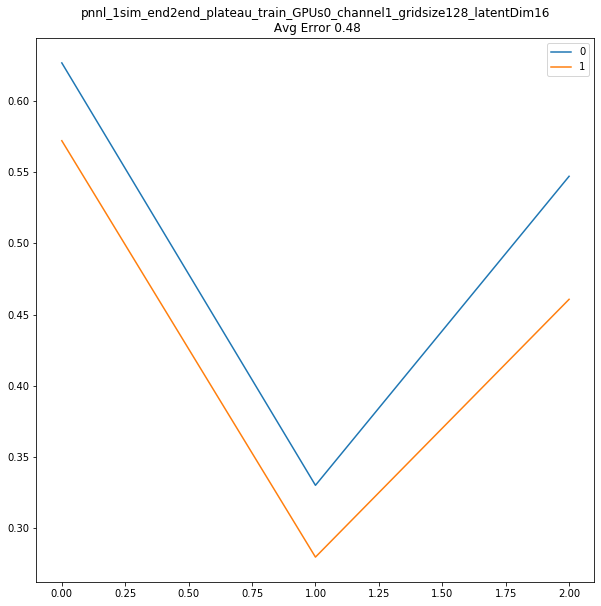

In [ ]:
plt.figure(figsize=(10,10))
title = versionName + '\n Avg Error {:.2f}'.format(rel_error)
plt.title(title)
plt.plot(reByFrame.T)
plt.legend([str(i) for i in range(len(Us))])
plt.show()